In [1]:
# Packages

import numpy as np
import matplotlib.pyplot as plt
import random

from utils import *
from environment import ButtonsToy
from learner import Learner, bayesian_update, compute_policy, projection
from teacher import NaiveTeacher, cost
from bayesian_ToM.bayesian_teacher import BaysesianTeacher

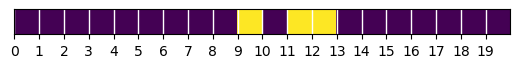

In [2]:
n_buttons = 20
n_music = 3

observation_env = ButtonsToy(n_buttons, n_music)
observation_env.render()

## Learners

Behaviours of the different learner types

In [69]:
types = [0, 1, 2, 3]
traj_size = 150
N = 100
N_envs = 5
dict_learner  = {}
for type in types:
    learner = Learner(type)
    dict_learner[type] = {'actions' : [],
                  'rewards' : []}
    for _ in range(N_envs):
        observation_env = ButtonsToy(n_buttons, n_music)
        for _ in range(N):
            learner.init_env(observation_env)
            actions, rewards = learner.act(traj_size)
            dict_learner[type]['actions'].append(actions)
            dict_learner[type]['rewards'].append(rewards)

/home/chetouani/Documents/STAGE_Clemence/ISIR_internship_ToM/experimental_setup_meta/utils.py:35: RuntimeWarning: divide by zero encountered in log2
  tab = proba_dist * np.log2(proba_dist)
/home/chetouani/Documents/STAGE_Clemence/ISIR_internship_ToM/experimental_setup_meta/utils.py:35: RuntimeWarning: invalid value encountered in multiply
  tab = proba_dist * np.log2(proba_dist)


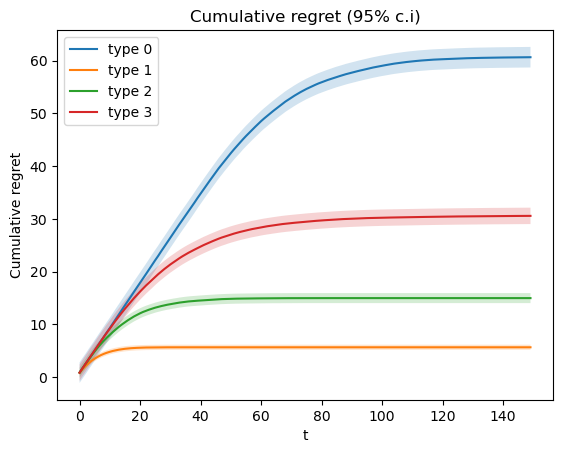

In [70]:
for ii,type in enumerate(types):
    all_rewards = np.array(dict_learner[type]['rewards'])
    all_cum_regrets = np.cumsum(np.ones_like(all_rewards) - all_rewards, axis=1)
    mean, std = np.mean(all_cum_regrets, axis=0), np.std(all_cum_regrets)

    plt.plot(mean, label=f'type {type}')
    plt.fill_between(np.arange(traj_size), mean + 1.96 * std / np.sqrt(N * N_envs), mean - 1.96 * std / np.sqrt(N * N_envs), alpha=0.2)
    plt.ylabel('Cumulative regret')
    plt.xlabel('t')
    plt.title('Cumulative regret (95% c.i)')
    plt.legend()

## Bayesian based ToM teacher

Evaluation of Bayesian teachers 
- Maximum a Posteriori teacher: selecting the best demonstration for the most probable learner type
- Bayesian teacher: selecting the best demonstration for a combinaison of learner types weighted by the beliefs of the teacher on the type of learners

Observation environment


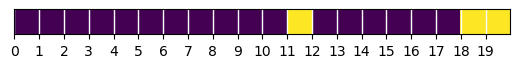

Demonstration environment


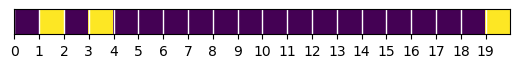

In [ ]:
observation_env = ButtonsToy(n_buttons, n_music)
print('Observation environment')
observation_env.render()
plt.show()

demonstration_env = ButtonsToy(n_buttons, n_music)
print('Demonstration environment')
demonstration_env.render()
plt.show()

num_types = 4
teacher = BaysesianTeacher(env=observation_env, num_types=num_types)
learner = Learner(type=3)
learner.init_env(observation_env)

### Predict learner type (Maximum A Posteriori)

Predict the type of the learner by taking the argmax of the Bayesian teacher beliefs (proba distribution over the set of possible learners)

In [ ]:
N = 200
N_envs = 10
num_obs = 100

dict = {}

for type in range(num_types):
    dict[type] = []
    for _ in range(N_envs):
        # Init envs
        observation_env = ButtonsToy(n_buttons, n_music)
        demonstration_env = ButtonsToy(n_buttons, n_music)
        for _ in range(N):
            # Init teacher
            teacher = BaysesianTeacher(env=observation_env,
                                    num_types=num_types)
            # Init learner
            learner = Learner(type)
            learner.init_env(observation_env)

            accuracies = []
            for _ in range(num_obs):
                accuracies.append(type == teacher.predict_learner_type())
                traj = learner.act()
                teacher.observe(traj)
            dict[type].append(accuracies)

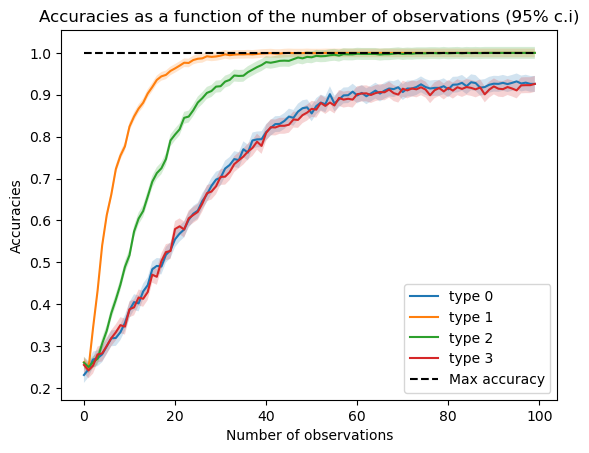

In [ ]:
for type in range(num_types):
    accuracies = np.array(dict[type])
    mean, std = np.mean(accuracies, axis=0), np.std(accuracies)

    plt.plot(mean, label=f'type {type}')
    plt.fill_between(np.arange(num_obs), mean + 1.96 * std / np.sqrt(N * N_envs), mean - 1.96 * std / np.sqrt(N * N_envs), alpha=0.2)
    plt.ylabel('Accuracies')
    plt.xlabel('Number of observations')
    plt.title('Accuracies as a function of the number of observations (95% c.i)')
plt.plot(np.arange(num_obs), [1] * num_obs, c='k', label="Max accuracy", ls='--')
plt.legend();

In [ ]:
## Failure mode studies

N = 100
N_envs = 1
num_obs = 300

LOG = True

dict = {}

for type in range(num_types):
    dict[type] = {}
    dict[type]['accuracies'] = []
    dict[type]['beliefs'] = []
    for _ in range(N_envs):
        # Init envs
        observation_env = ButtonsToy(n_buttons, n_music)
        demonstration_env = ButtonsToy(n_buttons, n_music)
        for _ in range(N):
            # Init teacher
            teacher = BaysesianTeacher(env=observation_env,
                                    num_types=num_types)
            # Init learner
            learner = Learner(type)
            learner.init_env(observation_env)

            accuracies = []
            all_beliefs = []
            tag_traj = []
            for _ in range(num_obs):
                all_beliefs.append(teacher.beliefs.copy())
                accuracies.append(type == teacher.predict_learner_type())
                traj = learner.act()
                teacher.observe(traj)
                tag_traj.append(traj)

            # If prediction failure after 300 observations
            if LOG and type != teacher.predict_learner_type():
                # print LOG
                print(f'LOG FAILURE : type {type} beliefs {teacher.beliefs} trajectory {tag_traj}')

            dict[type]['beliefs'].append(all_beliefs)
            dict[type]['accuracies'].append(accuracies)

### Demonstrate

Entire experiment:
- the teacher observes a learner trajectory (of varying size) on the observation environment 
- the teacher select the best demonstration for the evaluation environemnet (MAP or weighted mean for the Bayesian teacher)
- the learner observe the demonstration provided by the teacher for the evalution env and plays a trajectory of size 20 and gets a total reward

We display the evaluation metrics:
- Mean tot reward over all the types of learners 
- Tot reward per type of learner
- Beliefs evolution
- Cost regret
- Demonstration strategy: prop of each demonstration type selected by the teacher per type of learner for varying size of the learner trajectory observed by the teacher (i.e. amount of information the teacher has about the learner)

Observation environment


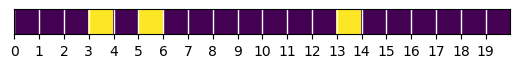

Demonstration environment


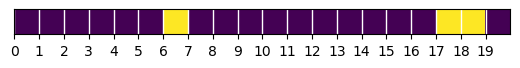

In [ ]:
observation_env = ButtonsToy(n_buttons, n_music)
print('Observation environment')
observation_env.render()
plt.show()

demonstration_env = ButtonsToy(n_buttons, n_music)
print('Demonstration environment')
demonstration_env.render()
plt.show()

num_types = 4
num_demo_types = 4
teacher = BaysesianTeacher(env=observation_env, num_types=num_types)
learner = Learner(type=2)
learner.init_env(observation_env)

In [ ]:
# Global evaluation parameters
# DICT = {}
# LOADED = False
DICT = load_output('./outputs/bayesian_ToM/teacher_eval.json')
LOADED = True

N = 100
N_envs = 3
num_obs = 50

n_eval = 20

#### Experiments and display

In [ ]:
def evaluate(method: str, alpha: float) -> None:
    if method not in DICT.keys():
        DICT[method] = {}
    DICT[method][alpha] = {}
    for type in range(num_types):
        DICT[method][alpha][type] = {}
        DICT[method][alpha][type]['rewards'] = []
        DICT[method][alpha][type]['demo'] = []
        DICT[method][alpha][type]['uncertainty'] = []
        DICT[method][alpha][type]['teacher_regret'] = []
        for _ in range(N_envs):
            # Init envs
            observation_env = ButtonsToy(n_buttons, n_music)
            demonstration_env = ButtonsToy(n_buttons, n_music)
            for _ in range(N):
                cum_rewards = []
                all_demo = []
                uncertainties = []
                teacher_regret = []
                for n in range(num_obs):
                    # Init teacher
                    if method == 'MAP' or method == 'Bayesian' or method == 'Oracle':
                        teacher = BaysesianTeacher(env=observation_env,
                                                    num_types=num_types)
                    elif method == 'Uniform' or method == 'Opt_non_adaptive':
                        teacher = NaiveTeacher(env=observation_env,
                                                    num_types=num_types)
                    # Init learner
                    learner = Learner(type)
                    learner.init_env(observation_env)
                    if method == 'MAP' or method == 'Bayesian':
                        # Observe the learner
                        traj = learner.act(size=n)
                        teacher.observe(traj)
                        # Teacher uncertainty
                        uncertainties.append(Shannon_entropy(teacher.beliefs))
                    # Chose demonstration
                    teacher.init_env(demonstration_env)
                    if method != 'Oracle':
                        demo = teacher.demonstrate(method=method, alpha=alpha)
                    else:
                        demo = teacher.demonstrate(method=method, alpha=alpha, true_learner_type=type)
                    # Teacher regret on its demonstration choice
                    teacher_regret.append(cost(demo, alpha=alpha) - cost(teacher.demonstrations[type], alpha=alpha))
                    # Show the demonstration
                    learner.init_env(demonstration_env)
                    learner.observe(demo)
                    # Evaluate hwo helpful has been the demonstration
                    _, rewards = learner.act(size=n_eval)
                    # Append
                    cum_rewards.append(np.sum(rewards))
                    all_demo.append(len(demo[0]))
                DICT[method][alpha][type]['rewards'].append(cum_rewards)
                DICT[method][alpha][type]['demo'].append(all_demo)
                DICT[method][alpha][type]['uncertainty'].append(uncertainties)
                DICT[method][alpha][type]['teacher_regret'].append(teacher_regret)

In [ ]:
def display_evaluation(method: str, alpha: float, save: bool=True) -> None:
    demo_colors = ['m', 'red', 'orange', 'pink']

    if LOADED:
        alpha = str(alpha)

    fig0 = plt.figure(figsize=(15,5))
    # Mean over the type of learner of the total reward on trajectory of size 20  (after seen the demo chosen by the teacher)
    all_evals = np.array([DICT[method][alpha][str(type)]['rewards'] if LOADED else DICT[method][alpha][type]['rewards'] for type in range(num_types)]).mean(axis=0)
    mean = np.mean(all_evals, axis=0)
    std = np.std(all_evals)

    plt.plot(mean, label=f'{method}', color='saddlebrown')
    plt.ylim(0, 21)
    plt.fill_between(np.arange(num_obs), mean + 1.96 * std / np.sqrt(N * N_envs), mean - 1.96 * std/np.sqrt(N * N_envs), alpha=0.2, color='saddlebrown')
    plt.plot(np.arange(num_obs), [20] * num_obs, c='k', label="Max", ls='--')
    
    # Baseline MAP --> Uniform
    if method == 'MAP':
        baseline = 'Uniform'
        if baseline in DICT.keys():
            all_evals = np.array([DICT[baseline][alpha][str(type)]['rewards'] if LOADED else DICT[baseline][alpha][type]['rewards'] for type in range(num_types)]).mean(axis=0)
            mean = np.mean(all_evals, axis=0)
            std = np.std(all_evals)
            plt.plot(mean, label=f'Baseline ({baseline})', color='crimson', ls='--')
            plt.fill_between(np.arange(num_obs), mean + 1.96 * std / np.sqrt(N * N_envs), mean - 1.96 * std/np.sqrt(N * N_envs), alpha=0.2, color='crimson')

    plt.title(fr' Mean total reward over all the type of learner'  + f'\n $\mathbf{{{method}}}$ teacher, cost parameter alpha={alpha}')
    plt.xlabel('Size of the learner trajectory observed by the teacher')
    plt.ylabel('Learner reward')
    plt.legend()

    fig1 = plt.figure(figsize=(15,5))
    # Learner total reward on trajectory of size 20 (after seen the demo chosen by the teacher for each type of learner)
    fig1.add_subplot(1,2,1)
    for type in range(num_types):
        if LOADED:
            type = str(type)
        all_evals = np.array(DICT[method][alpha][type]['rewards'])
        mean = np.mean(all_evals, axis=0)
        std = np.std(all_evals)

        plt.plot(mean, label=f'type = {type}')
        plt.ylim(0, 21)
        plt.fill_between(np.arange(num_obs), mean + 1.96 * std / np.sqrt(N * N_envs), mean - 1.96 * std / np.sqrt(N * N_envs), alpha=0.2)
    plt.plot(np.arange(num_obs), [20] * num_obs, c='k', label="Max", ls='--')
    plt.title(fr'Learner total reward per type'  + f'\n $\mathbf{{{method}}}$ teacher, cost parameter alpha={alpha}')

    plt.xlabel('Size of the learner trajectory observed by the teacher')
    plt.ylabel('Learner reward')
    plt.legend()

    # Teacher uncertainty
    if method == 'MAP' or method == 'Bayesian':
        fig1.add_subplot(1,2,2)
        for type in range(num_types):
            if LOADED:
                type = str(type)
            all_evals = np.array(DICT[method][alpha][type]['uncertainty'])
            mean = np.mean(all_evals, axis=0)
            std = np.std(all_evals)

            plt.plot(mean, label=f'type = {type}')
            plt.ylim(- 0.5 , Shannon_entropy(np.ones(num_types) / num_types) + 0.5)
            plt.fill_between(np.arange(num_obs), mean + 1.96 * std / np.sqrt(N * N_envs), mean - 1.96 * std/np.sqrt(N * N_envs), alpha=0.2)
        plt.plot(np.arange(num_obs), [0] * num_obs, c='k', label="Min", ls='--')
        plt.title(fr'Teacher uncertainty per type' + f'\n $\mathbf{{{method}}}$ teacher, cost parameter alpha={alpha}')

        plt.xlabel('Size of the learner trajectory observed by the teacher')
        plt.ylabel('Teacher uncertainty (Shannon entropy)')
        plt.legend()

    # Repartition btw type of demonstrations shown
    fig2, axes = plt.subplots(1, 4, figsize=(25,5))
    for type in range(num_types):
        ax = axes[type]
        if LOADED:
            type = str(type)
        for demo_type in range(num_demo_types):
            demo_rep = np.array(DICT[method][alpha][type]['demo'])
            if demo_type == 0:
                prop_demo = np.array(demo_rep == n_buttons)
            else:
                prop_demo = np.array(demo_rep == demo_type)
            mean = np.mean(prop_demo, axis=0)
            std = np.std(prop_demo)

            ax.plot(mean, label=f'demo type = {demo_type}', color=demo_colors[demo_type])
            ax.fill_between(np.arange(num_obs), mean + 1.96 * std / np.sqrt(N + N_envs), mean - 1.96 * std/np.sqrt(N + N_envs), alpha=0.2, color=demo_colors[demo_type])
        ax.plot(np.arange(num_obs), [1] * num_obs, c='k', label="Max", ls='--')

        ax.set_title(f'% of each demo type for learner of $\mathbf{{type}}$ ' + fr'$\mathbf{{{type}}}$' + f'\n {method} teacher, cost parameter alpha={alpha}')
        ax.set_xlabel('Size of the learner trajectory observed by the teacher')
        ax.set_ylabel('Proportion')
        ax.legend()

    # Teacher regret on the cost of the demonstration he showed
    fig3, axes = plt.subplots(1, 4, figsize=(25,5))
    for type in range(num_types):
        ax = axes[type]
        if LOADED:
            type = str(type)
        all_regrets = np.array(DICT[method][alpha][type]['teacher_regret'])
        mean = np.mean(all_regrets, axis=0)
        std = np.std(all_regrets)

        ax.plot(mean, label=f'type = {type}', color='c')
        ax.fill_between(np.arange(num_obs), mean + 1.96 * std / np.sqrt(N * N_envs), mean - 1.96 * std/np.sqrt(N * N_envs), alpha=0.2, color='c')
        ax.set_ylim( - (float(alpha) * (n_buttons - 1) + 0.02), float(alpha) * (n_buttons - 1) + 0.02)
        ax.plot(np.arange(num_obs), [0] * num_obs, c='k', ls='--')

        # Baseline
        if method == 'Bayesian':
            baseline = 'Opt_non_adaptive'
            all_regrets = np.array(DICT[baseline][alpha][type]['teacher_regret'])
            mean = np.mean(all_regrets, axis=0)
            std = np.std(all_regrets)

            ax.plot(mean, label=f'Baseline ({baseline})', color='crimson', ls='--')
            ax.fill_between(np.arange(num_obs), mean + 1.96 * std / np.sqrt(N * N_envs), mean - 1.96 * std/np.sqrt(N * N_envs), alpha=0.2, color='crimson')

        ax.set_title(f'Teacher cost regret for learner of $\mathbf{{type}}$ ' + fr'$\mathbf{{{type}}}$' +  f'\n {method} teacher, cost parameter alpha={alpha}')
        ax.set_xlabel('Size of the learner trajectory observed by the teacher')
        ax.set_ylabel('Cost regret')
        ax.legend()

    # Super figure
    figs = [fig0, fig1, fig2, fig3]
    saving_names = ['mean', 'per_type', 'chosen_demo', 'teacher_regret']
    if save:
        for ii, fig in enumerate(figs):
            fig.savefig(f'./bayesian_ToM/figures/{method}/eval_{saving_names[ii]}_{method}_{alpha}.png')

In [ ]:
def display_utility(alpha: float=0.01) -> None:
    _ = plt.figure(figsize=(15,5))
    method_values = ['MAP', 'Bayesian', 'Uniform', 'Opt_non_adaptive', 'Oracle']
    colors = ['orangered', 'mediumvioletred', 'darkturquoise', 'royalblue', 'darkgreen']
    for ii,method in enumerate(method_values):
        util = []
        for type in range(num_types):
            best_cost = alpha * n_buttons if type == 0 else alpha * type
            all_rewards = np.array([DICT[method][str(alpha)][str(type)]['rewards'] if LOADED else DICT[method][alpha][type]['rewards'] for type in range(num_types)]).mean(axis=0)
            all_cost = np.array([DICT[method][str(alpha)][str(type)]['teacher_regret'] + best_cost if LOADED else DICT[method][alpha][type]['rewards'] + best_cost for type in range(num_types)]).mean(axis=0)

            all_util = all_rewards / n_buttons - all_cost
            util.append(all_util)
            
        all = np.mean(util, axis=0)
        mean = np.mean(all, axis=0)
        std = np.std(all)
        plt.plot(mean, label=f'{method}', color=colors[ii])
        plt.fill_between(np.arange(num_obs), mean + 1.96 * std / np.sqrt(N * N_envs), mean - 1.96 * std/np.sqrt(N * N_envs), alpha=0.2, color=colors[ii])
    
    if alpha in [0.01, 0.02]:
        plt.ylim(0.5, 1)
    
    plt.xlabel('Size of the learner trajectory observed by the teacher')
    plt.ylabel('Utility')
    plt.title(f'Mean utility over all the type of learner (95% c.i) \n cost parameter alpha={alpha}')
    plt.legend();


#### Compute statistic on the planning model (understand as a policy prediction model)

Display the predicted reward of the learner after processing the demonstration selected by the teacher and the deduced predicted utility.

In [ ]:
N = 3
N_envs = 300

def evaluate_planning_model(method: str, alpha: float, n: int, distance: callable) -> tuple:

    image_pourcentage_musical = np.zeros((4, 4))
    image_entropy = np.zeros((4, 4))
    image_error_dist = np.zeros((4, 4))
    image_pred_reward = np.zeros((4, 4))
    image_pred_utility = np.zeros((4, 4))

    for type in range(num_types):
        # print('type', type)
        for _ in range(N_envs):
            # Init envs
            observation_env = ButtonsToy(n_buttons, n_music)
            demonstration_env = ButtonsToy(n_buttons, n_music)
            for _ in range(N):

                # Init teacher
                if method == 'MAP' or method == 'Bayesian' or method == 'Oracle':
                    teacher = BaysesianTeacher(env=observation_env,
                                                num_types=num_types)
                elif method == 'Uniform' or method == 'Opt_non_adaptive':
                    teacher = NaiveTeacher(env=observation_env,
                                                num_types=num_types)
                # Init learner
                learner = Learner(type)
                learner.init_env(observation_env)
                if method == 'MAP' or method == 'Bayesian':
                    # Observe the learner
                    traj = learner.act(size=n)
                    teacher.observe(traj)
                # Change env demonstration
                    teacher.init_env(demonstration_env)
                    learner.init_env(demonstration_env)

                for demo_type in range(num_demo_types):
                    demo = teacher.demonstrations[demo_type]
                    pred_rewards = np.array([teacher.predict_reward(demo, t) for t in range(num_types)])

                    if method == 'Bayesian':

                        # Predicted reward (ponderated sum)
                        image_pred_reward[type, demo_type] += np.sum(pred_rewards * teacher.beliefs)
                        # Predicted utility (ponderated sum)
                        image_pred_utility[type, demo_type] += np.sum([(pred_rewards[t] - cost(demo, alpha)) * teacher.beliefs[t] for t in range(num_types)])
                        
                        # Predicted policy (ponderated mean)
                        bayesian_pred_policy = np.zeros(n_buttons)
                        for t in range(num_types):
                            pred_learner_beliefs_demo_env = teacher.learner_beliefs.copy()
                            for a,r in zip(demo[0], demo[1]):
                                pred_learner_beliefs_demo_env = bayesian_update(pred_learner_beliefs_demo_env, a, r)
                            predicted_policy = compute_policy(projection(pred_learner_beliefs_demo_env, t), teacher.env)
                            bayesian_pred_policy += predicted_policy * teacher.beliefs[t]

                        # True policy 
                        learner_beliefs_demo_env = learner.beliefs.copy()
                        for a,r in zip(demo[0], demo[1]):
                            learner_beliefs_demo_env = bayesian_update(learner_beliefs_demo_env, a, r)
                        true_policy = compute_policy(projection(learner_beliefs_demo_env, type), teacher.env)
                        
                        # Distance btw the predicted and the true policy
                        image_error_dist[type, demo_type] = distance(bayesian_pred_policy, true_policy)
                        # Entropy of the predicted policy
                        image_entropy[type, demo_type] += Shannon_entropy(bayesian_pred_policy)

                        # % of the most probable buttons the learner will play are in the set of mucial buttons
                        argmax_set = np.where(np.isclose(bayesian_pred_policy, np.max(bayesian_pred_policy)))[0]
                        # print('argmax set', argmax_set)
                        image_pourcentage_musical[type, demo_type] += np.random.choice(argmax_set) in np.where(demonstration_env.R == 1)[0]

                    if method == 'MAP':
                        # Predicted learner type based on maximum a posteriori
                        pred_type = teacher.predict_learner_type()

                        # Predicted reward
                        image_pred_reward[type, demo_type] += pred_rewards[pred_type]
                        # Predicted utility
                        image_pred_utility[type, demo_type] += pred_rewards[pred_type] - cost(demo, alpha)
                        # Predicted policy
                        learner_beliefs_demo_env = teacher.learner_beliefs.copy()
                        for a,r in zip(demo[0], demo[1]):
                            learner_beliefs_demo_env = bayesian_update(learner_beliefs_demo_env, a, r)
                        predicted_policy = compute_policy(projection(learner_beliefs_demo_env, pred_type), teacher.env)
                        # Distance btw the predicted and the true policy
                        image_error_dist[type, demo_type] = distance(predicted_policy, compute_policy(learner.beliefs, learner.env))
                        # Entropy of the predicted policy
                        image_entropy[type, demo_type] += Shannon_entropy(predicted_policy)

                        # % of the most probable buttons the learner will play are in the set of mucial buttons
                        argmax_set = np.where(np.isclose(predicted_policy, np.max(predicted_policy)))[0]
                        image_pourcentage_musical[type, demo_type] += np.random.choice(argmax_set) in np.where(demonstration_env.R == 1)[0]

    return image_pred_reward / (N * N_envs), \
           image_pred_utility / (N * N_envs), \
           image_pourcentage_musical / (N * N_envs), \
           image_entropy / (N * N_envs), \
           image_error_dist / (N * N_envs)           

In [ ]:
method = 'Bayesian'
alpha = 0.01
distance = SE_dist
n = 60

image_pred_reward, image_pred_utility, image_pourcentage_musical, image_entropy, image_error_dist = evaluate_planning_model(method, alpha=alpha, n=n, distance=distance)

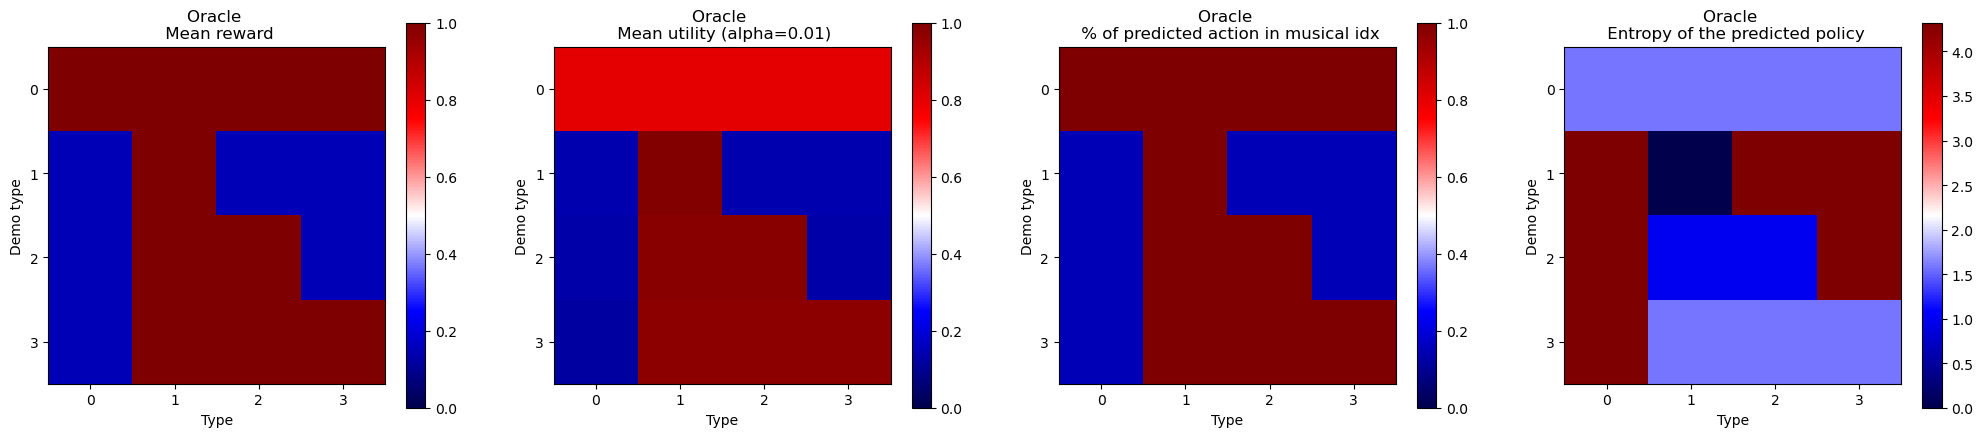

In [ ]:
# Oracle teacher

perf_image_entropy = np.zeros((4, 4))
perf_image_pourcentage_musical = np.zeros((4, 4))
perf_image_utility = np.zeros((4, 4))

for type in range(num_types):
    for demo_type in range(num_demo_types):
        
        len_demo = n_buttons if demo_type == 0 else demo_type

        if demo_type == 0:
            dist = np.zeros(n_buttons)
            dist[np.array([0, 1, 2])] = np.ones(3)
            dist /= dist.sum()
            perf_image_entropy[type, demo_type] = Shannon_entropy(dist)
            perf_image_pourcentage_musical[type, demo_type] = 1
        elif demo_type == 3:
            if type == 0:
                # Uniform policy
                perf_image_entropy[type, demo_type] = Shannon_entropy(np.ones(n_buttons) / n_buttons)
                perf_image_pourcentage_musical[type, demo_type] = 3/20
            else:
                # Peaked on 3 (musical) buttons policy
                dist = np.zeros(n_buttons)
                dist[np.array([0, 1, 2])] = np.ones(3)
                dist /= dist.sum()
                perf_image_entropy[type, demo_type] = Shannon_entropy(dist)
                perf_image_pourcentage_musical[type, demo_type] = 1
        elif demo_type == 2:
            if type == 0 or type == 3:
                # Uniform policy
                perf_image_entropy[type, demo_type] = Shannon_entropy(np.ones(n_buttons) / n_buttons)
                perf_image_pourcentage_musical[type, demo_type] = 3/20
            else:
                # Peaked on 2 (musical) buttons policy
                dist = np.zeros(n_buttons)
                dist[np.array([0, 1])] = np.ones(2)
                dist /= dist.sum()
                perf_image_entropy[type, demo_type] = Shannon_entropy(dist)
                perf_image_pourcentage_musical[type, demo_type] = 1
        elif demo_type == 1:
            if type == 0 or type == 3 or type == 2:
                # Uniform policy
                perf_image_entropy[type, demo_type] = Shannon_entropy(np.ones(n_buttons) / n_buttons)
                perf_image_pourcentage_musical[type, demo_type] = 3/20
            else:
                # Peaked on 1 (musical) buttons policy
                dist = np.zeros(n_buttons)
                dist[0] = np.ones(1)
                dist /= dist.sum()
                perf_image_entropy[type, demo_type] = Shannon_entropy(dist)
                perf_image_pourcentage_musical[type, demo_type] = 1

        perf_image_utility[type, demo_type] = perf_image_pourcentage_musical[type, demo_type] - alpha * len_demo


fig = plt.figure(figsize=(25,5))

fig.add_subplot(1,4,1)
plt.imshow(perf_image_pourcentage_musical.T, cmap='seismic', vmin=0, vmax=1)
plt.colorbar()
plt.xticks([3,2,1,0])
plt.yticks([3,2,1,0])
plt.xlabel('Type')
plt.ylabel('Demo type')
plt.title('Oracle \n Mean reward')

fig.add_subplot(1,4,2)
plt.imshow(perf_image_utility.T, cmap='seismic', vmin=0, vmax=1)
plt.colorbar()
plt.xticks([3,2,1,0])
plt.yticks([3,2,1,0])
plt.xlabel('Type')
plt.ylabel('Demo type')
plt.title(f'Oracle \n Mean utility (alpha={alpha})')

fig.add_subplot(1,4,3)
plt.imshow(perf_image_pourcentage_musical.T, cmap='seismic', vmin=0, vmax=1)
plt.colorbar()
plt.xticks([3,2,1,0])
plt.yticks([3,2,1,0])
plt.xlabel('Type')
plt.ylabel('Demo type')
plt.title('Oracle \n % of predicted action in musical idx')

fig.add_subplot(1,4,4)
plt.imshow(perf_image_entropy.T, cmap='seismic', vmin=0, vmax=(Shannon_entropy(np.ones(n_buttons) / n_buttons)))
plt.colorbar()
plt.xticks([3,2,1,0])
plt.yticks([3,2,1,0])
plt.xlabel('Type')
plt.ylabel('Demo type')
plt.title('Oracle \n Entropy of the predicted policy');

fig.savefig(f"./bayesian_ToM/figures/Statistics/oracle.png")

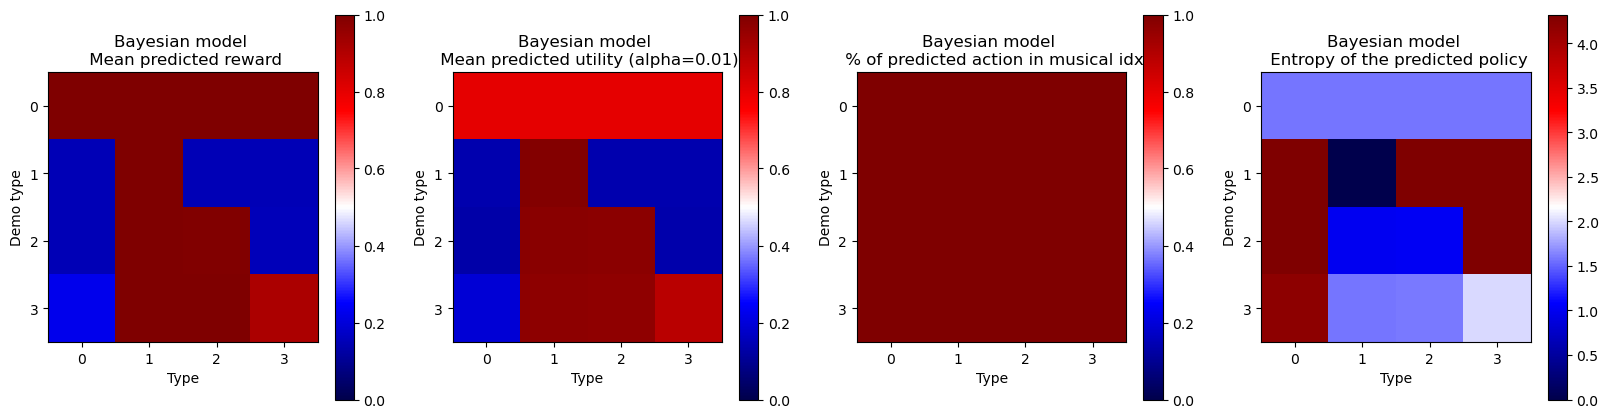

In [ ]:
# Predicted reward and utility (additional stat argmax and shannon entropy)

fig = plt.figure(figsize=(20,5))

fig.add_subplot(1,4,1)
plt.imshow(image_pred_reward.T, cmap='seismic', vmin=0, vmax=1)
plt.colorbar()
plt.xticks([3,2,1,0])
plt.yticks([3,2,1,0])
plt.xlabel('Type')
plt.ylabel('Demo type')
plt.title(f'{method} model \n Mean predicted reward')

fig.add_subplot(1,4,2)
plt.imshow(image_pred_utility.T, cmap='seismic', vmin=0, vmax=1)
plt.colorbar()
plt.xticks([3,2,1,0])
plt.yticks([3,2,1,0])
plt.xlabel('Type')
plt.ylabel('Demo type')
plt.title(f'{method} model \n Mean predicted utility (alpha={alpha})')

fig.add_subplot(1,4,3)
plt.imshow(image_pourcentage_musical.T, cmap='seismic', vmin=0, vmax=1)
plt.colorbar()
plt.xticks([3,2,1,0])
plt.yticks([3,2,1,0])
plt.xlabel('Type')
plt.ylabel('Demo type')
plt.title(f'{method} model \n % of predicted action in musical idx')

fig.add_subplot(1,4,4)
plt.imshow(image_entropy.T, cmap='seismic', vmin=0, vmax=(Shannon_entropy(np.ones(n_buttons) / n_buttons)))
plt.colorbar()
plt.xticks([3,2,1,0])
plt.yticks([3,2,1,0])
plt.xlabel('Type')
plt.ylabel('Demo type')
plt.title(f'{method} model \n Entropy of the predicted policy');

fig.savefig(f"./bayesian_ToM/figures/Statistics/{method}.png")

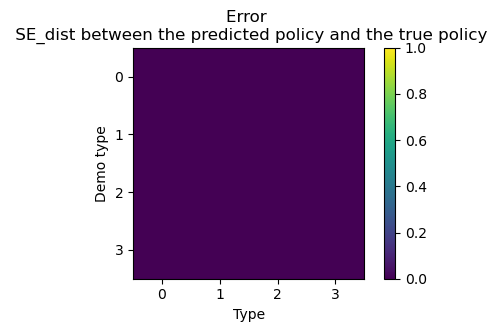

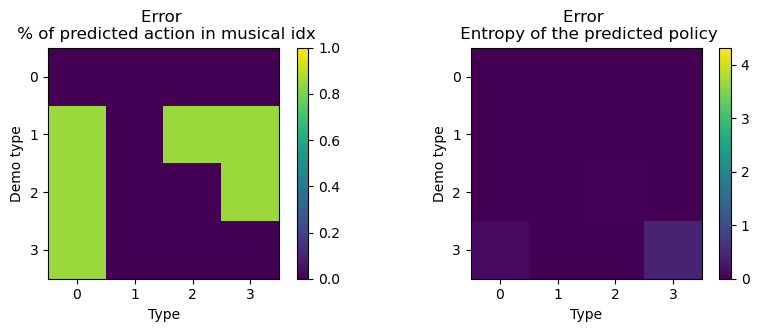

In [ ]:
# Error on the predicted policy

fig = plt.figure(figsize=(5,3))

plt.imshow(image_error_dist.T, cmap='viridis', vmin=0, vmax=1)
plt.colorbar()
plt.xticks([3,2,1,0])
plt.yticks([3,2,1,0])
plt.xlabel('Type')
plt.ylabel('Demo type')
plt.title(f'Error \n {distance.__name__} between the predicted policy and the true policy')

fig.savefig(f"./bayesian_ToM/figures/Statistics/{method}_error_L2.png")

fig = plt.figure(figsize=(10,3))

fig.add_subplot(1,2,1)
plt.imshow(np.abs(perf_image_pourcentage_musical - image_pourcentage_musical).T, cmap='viridis', vmin=0, vmax=1)
plt.colorbar()
plt.xticks([3,2,1,0])
plt.yticks([3,2,1,0])
plt.xlabel('Type')
plt.ylabel('Demo type')
plt.title('Error \n % of predicted action in musical idx')


fig.add_subplot(1,2,2)
plt.imshow(np.abs(perf_image_entropy - image_entropy).T, cmap='viridis', vmin=0, vmax=(Shannon_entropy(np.ones(n_buttons) / n_buttons)))
plt.colorbar()
plt.xticks([3,2,1,0])
plt.yticks([3,2,1,0])
plt.xlabel('Type')
plt.ylabel('Demo type')
plt.title('Error \n Entropy of the predicted policy');

fig.savefig(f"./bayesian_ToM/figures/Statistics/{method}_error.png")

#### Mean utility for all the teachers

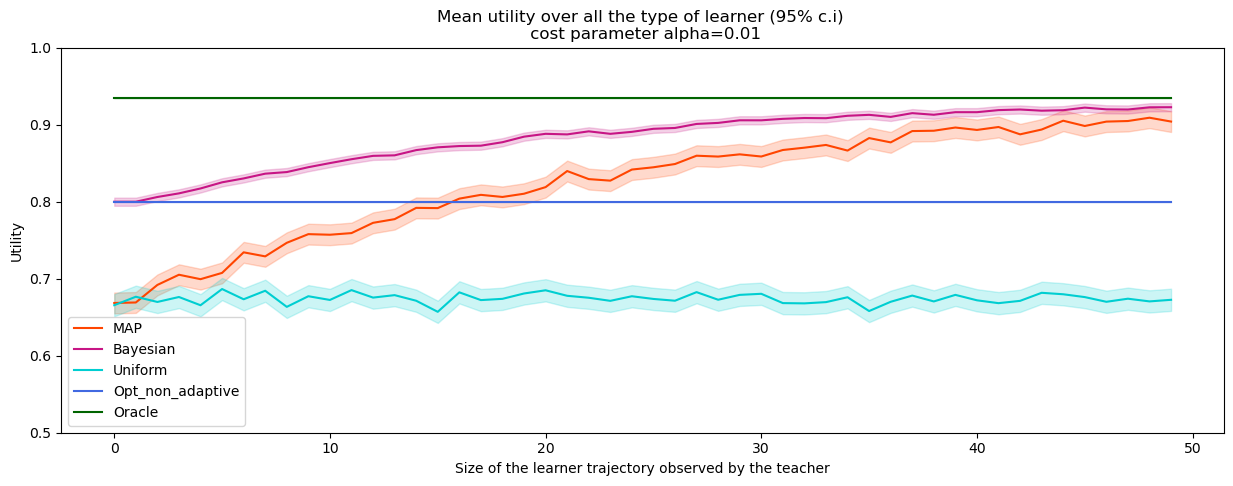

In [ ]:
display_utility(alpha=0.01)

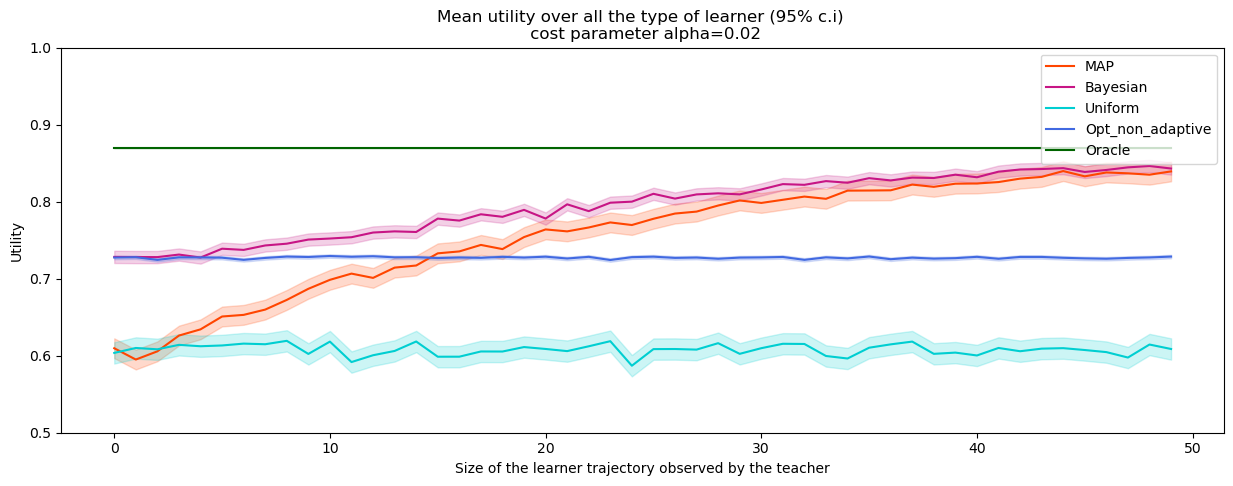

In [ ]:
display_utility(alpha=0.02)

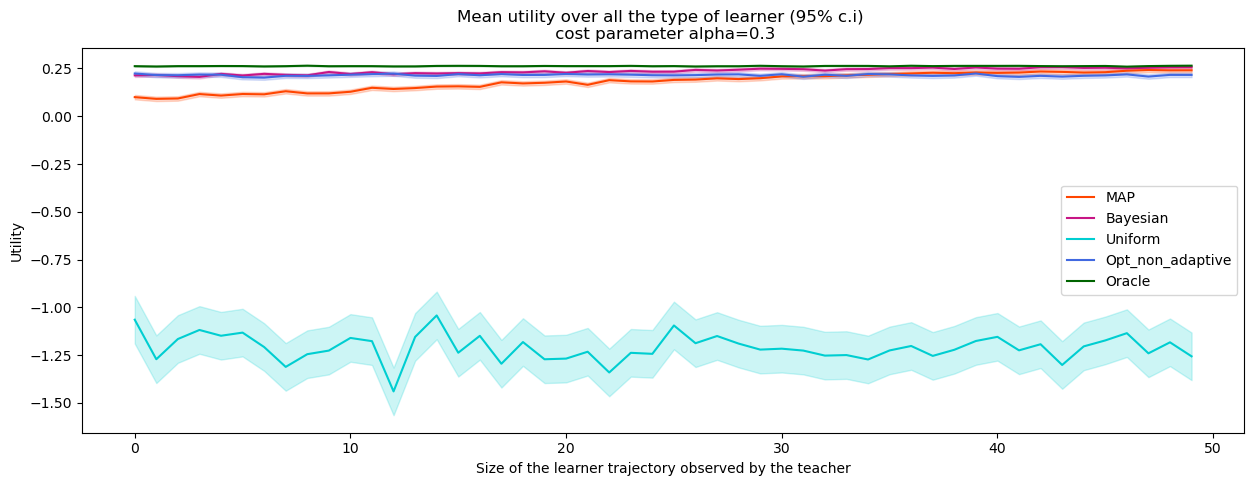

In [ ]:
display_utility(alpha=0.3)

#### MAP teacher

In [ ]:
method = 'MAP'
alpha_values = [0.03] #[0.01, 0.02]

for alpha in alpha_values:
    evaluate(method, alpha)

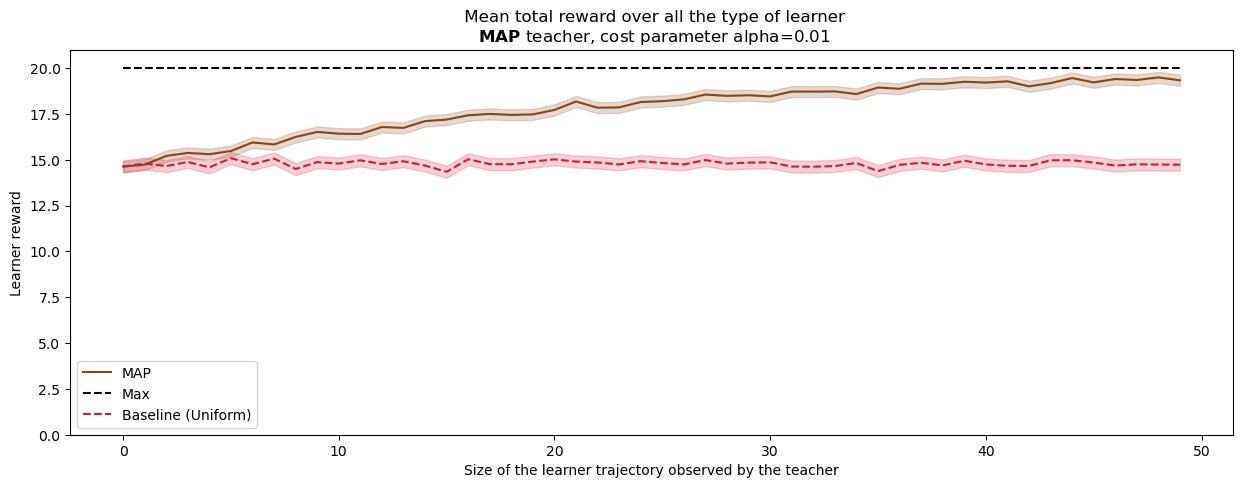

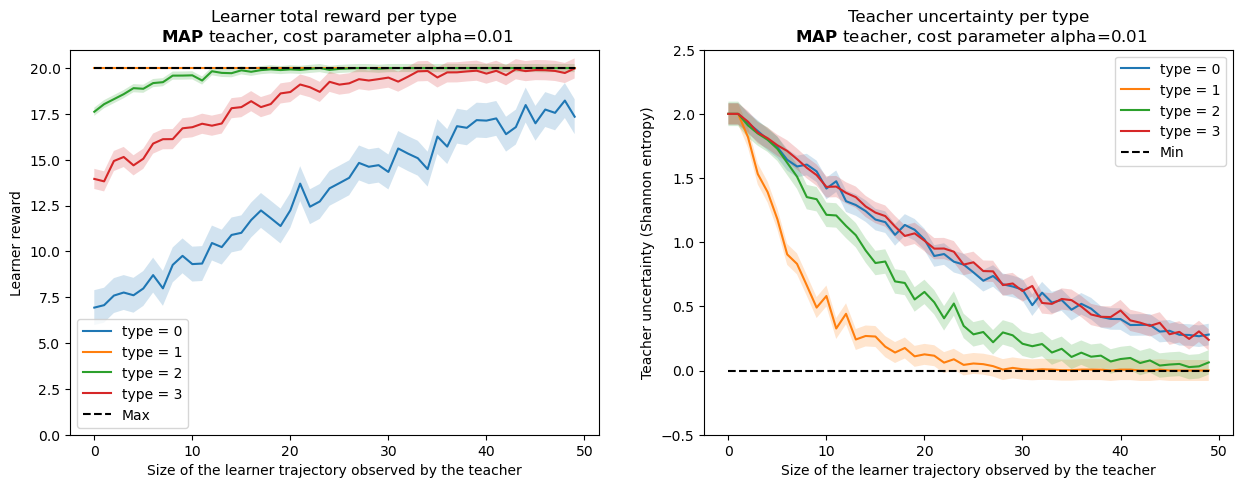

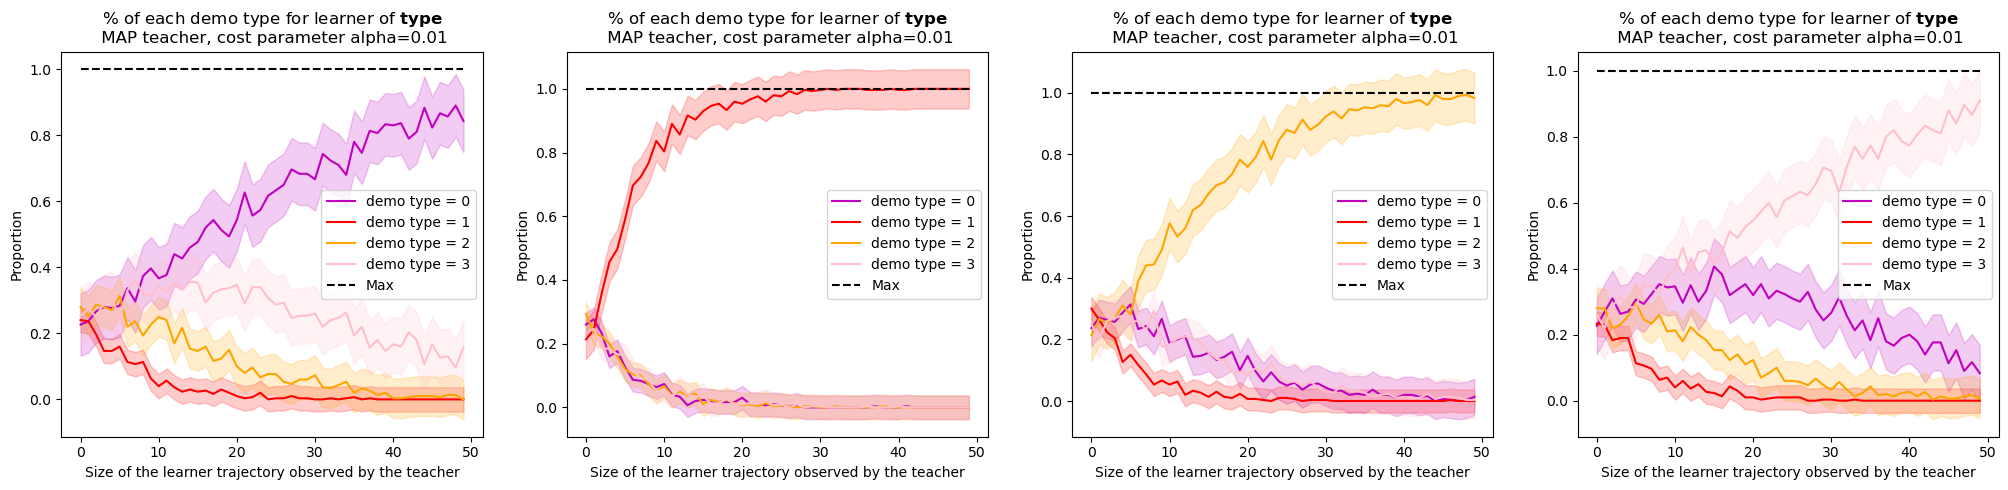

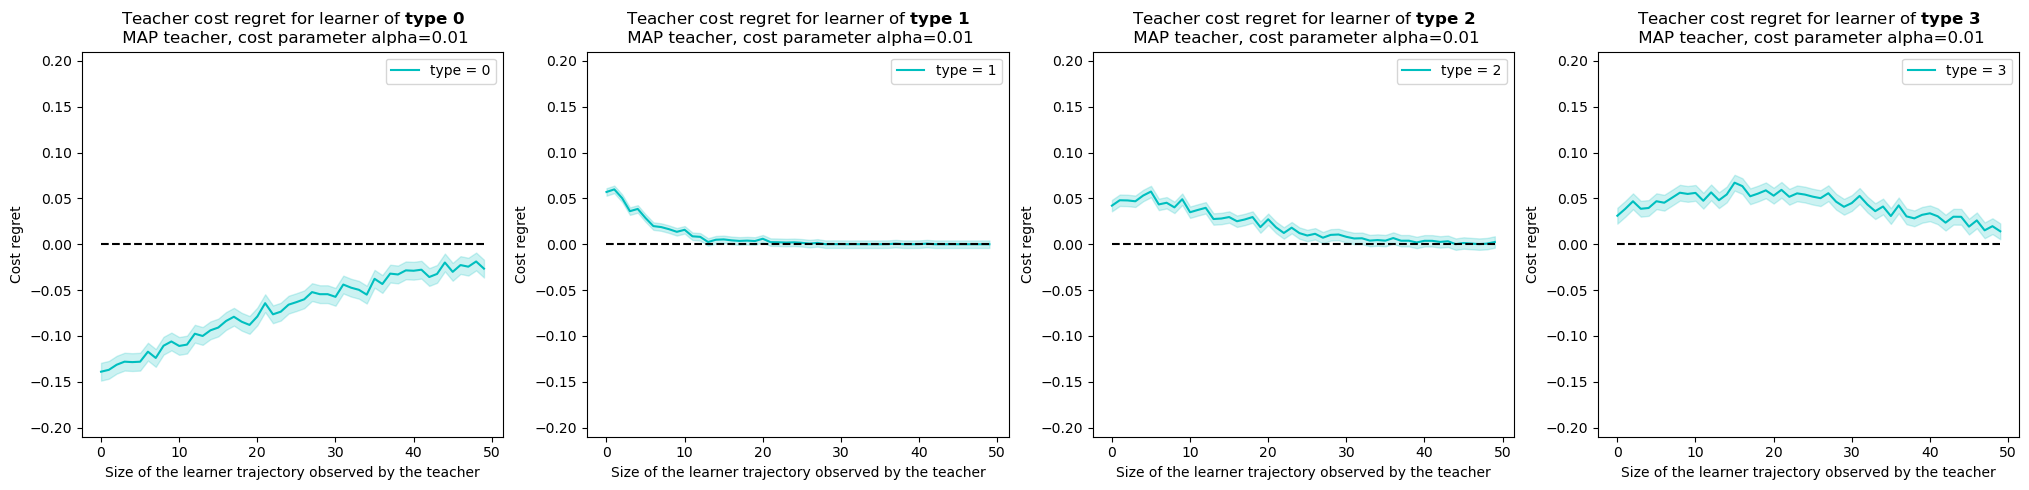

In [ ]:
method, alpha = 'MAP', alpha_values[0]
display_evaluation(method, alpha)

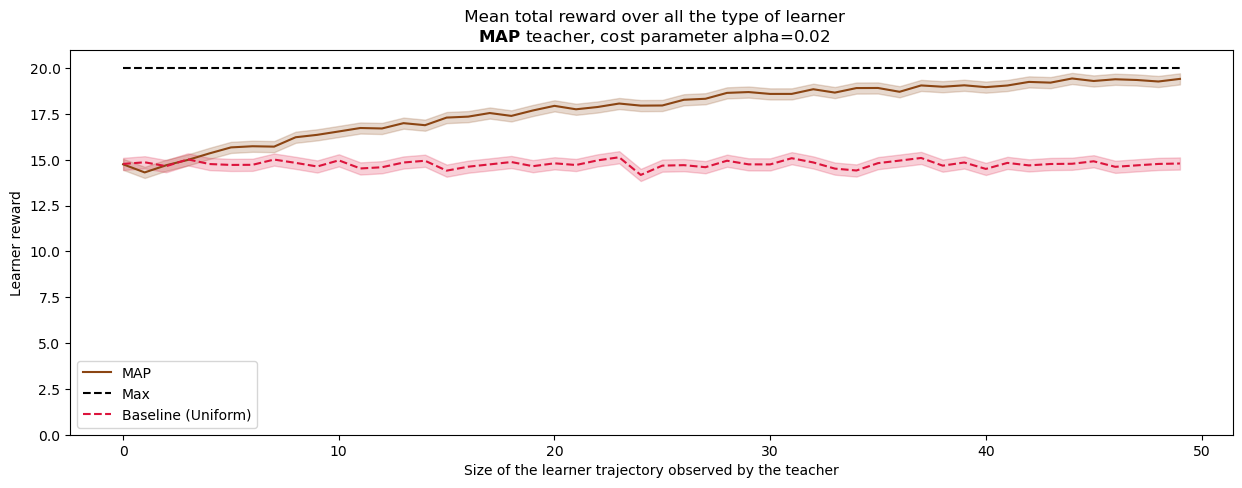

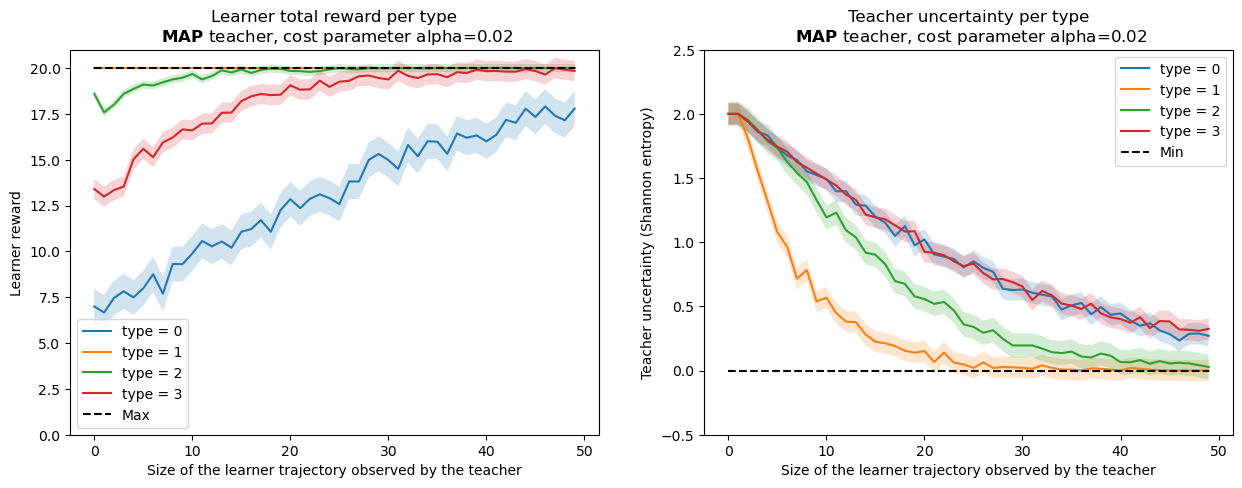

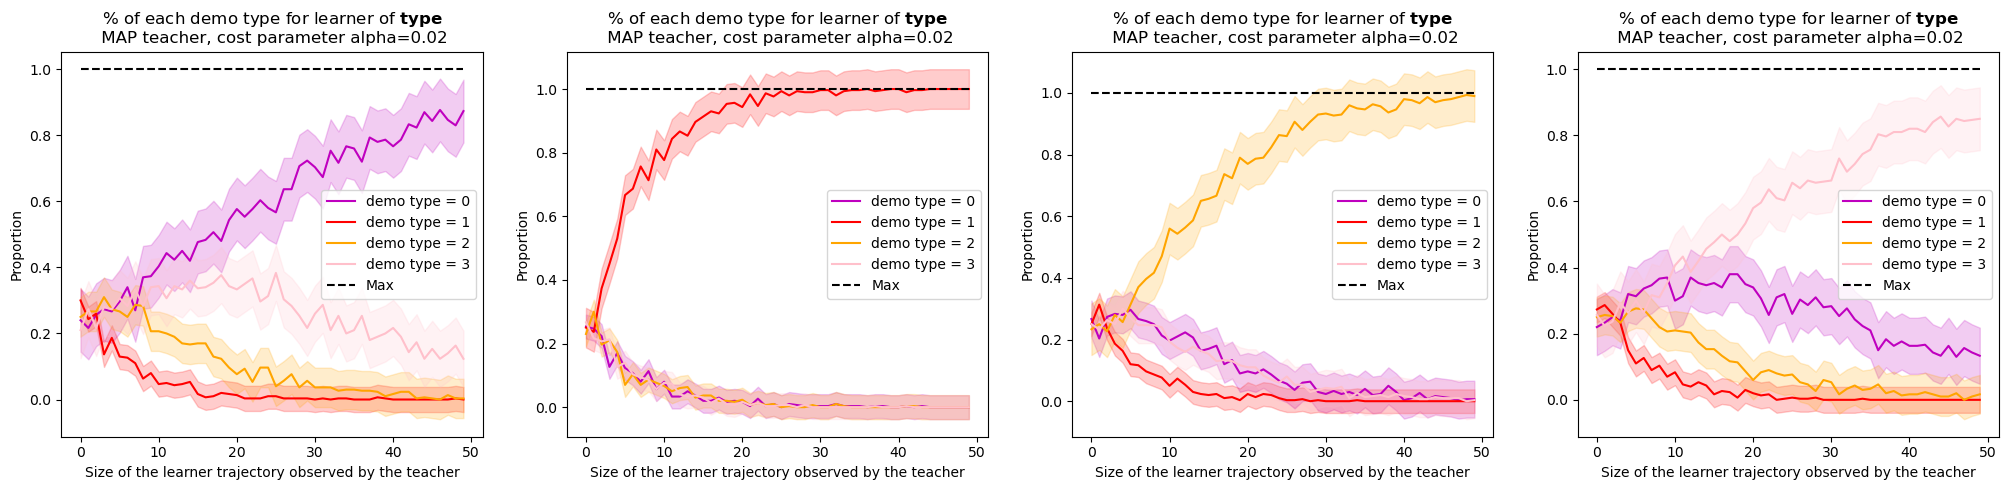

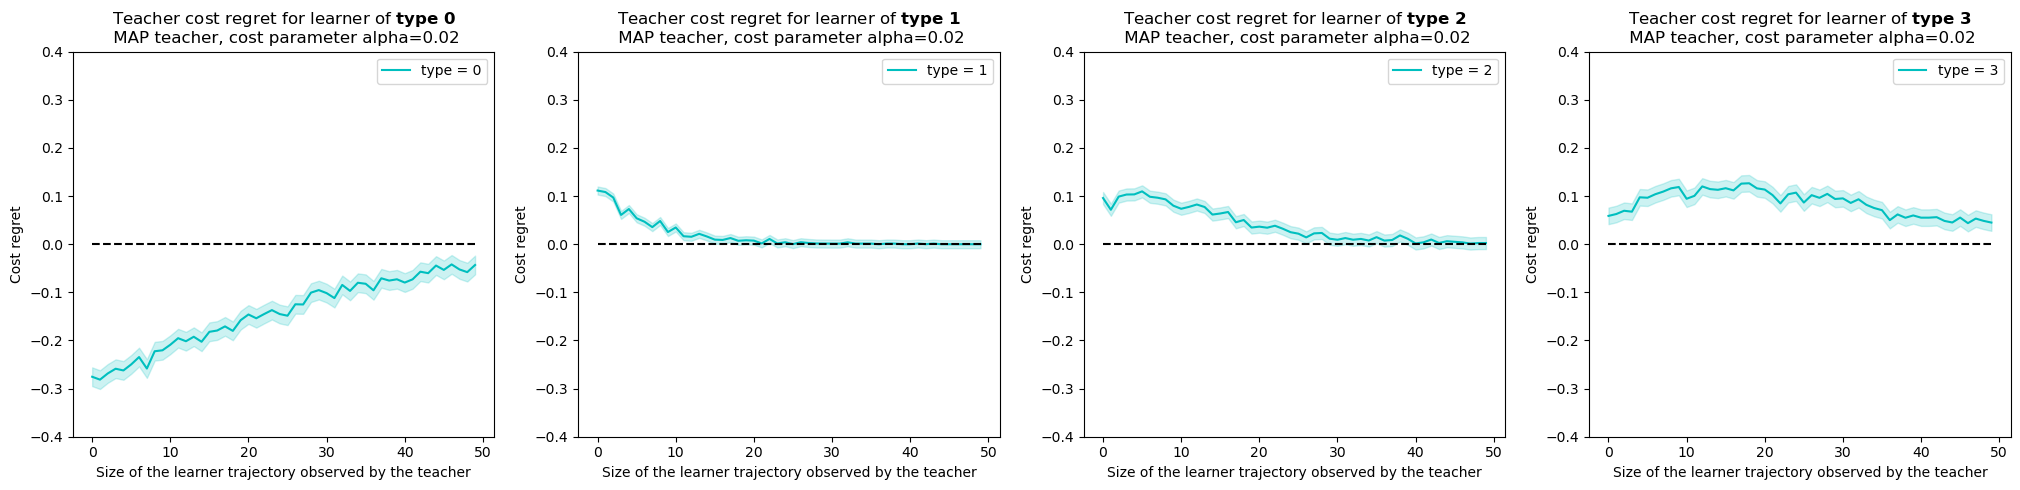

In [ ]:
method, alpha = 'MAP', alpha_values[1]
display_evaluation(method, alpha)

#### Bayesian teacher

In [ ]:
method = 'Bayesian'
alpha_values = [0.03] #[0.01, 0.02, 0.03]

for alpha in alpha_values:
    evaluate(method, alpha)

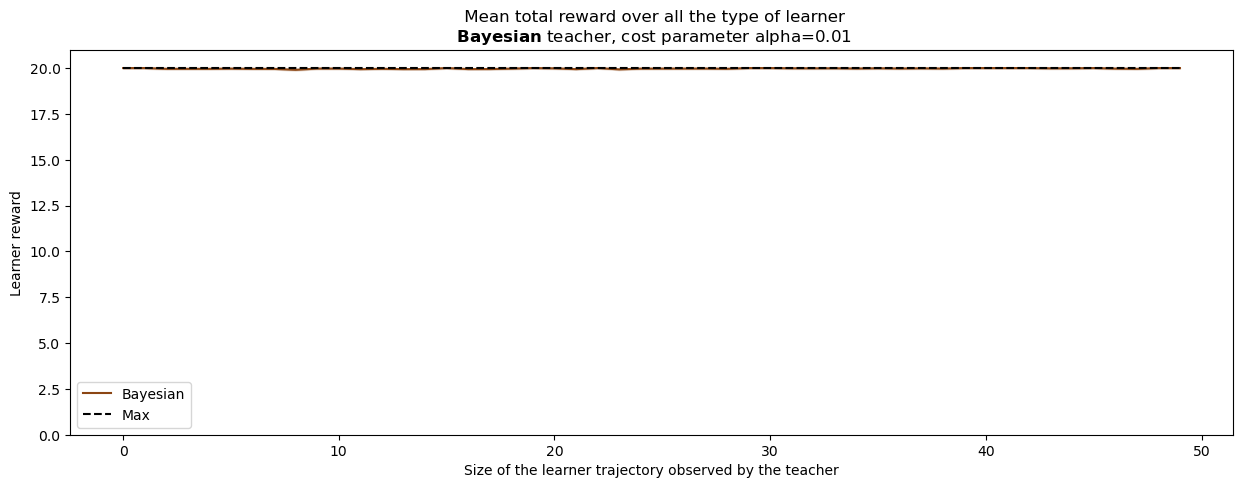

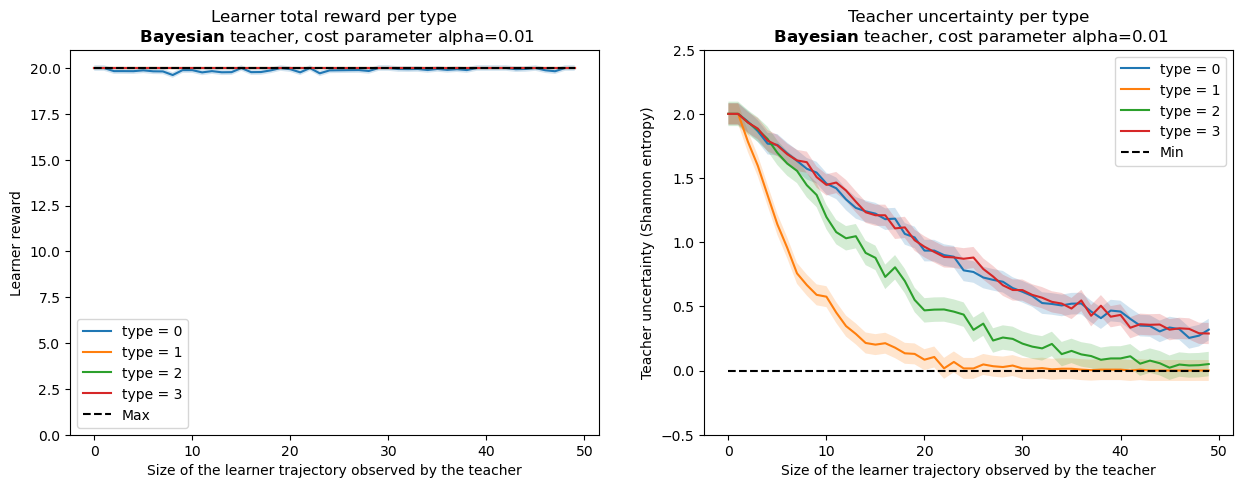

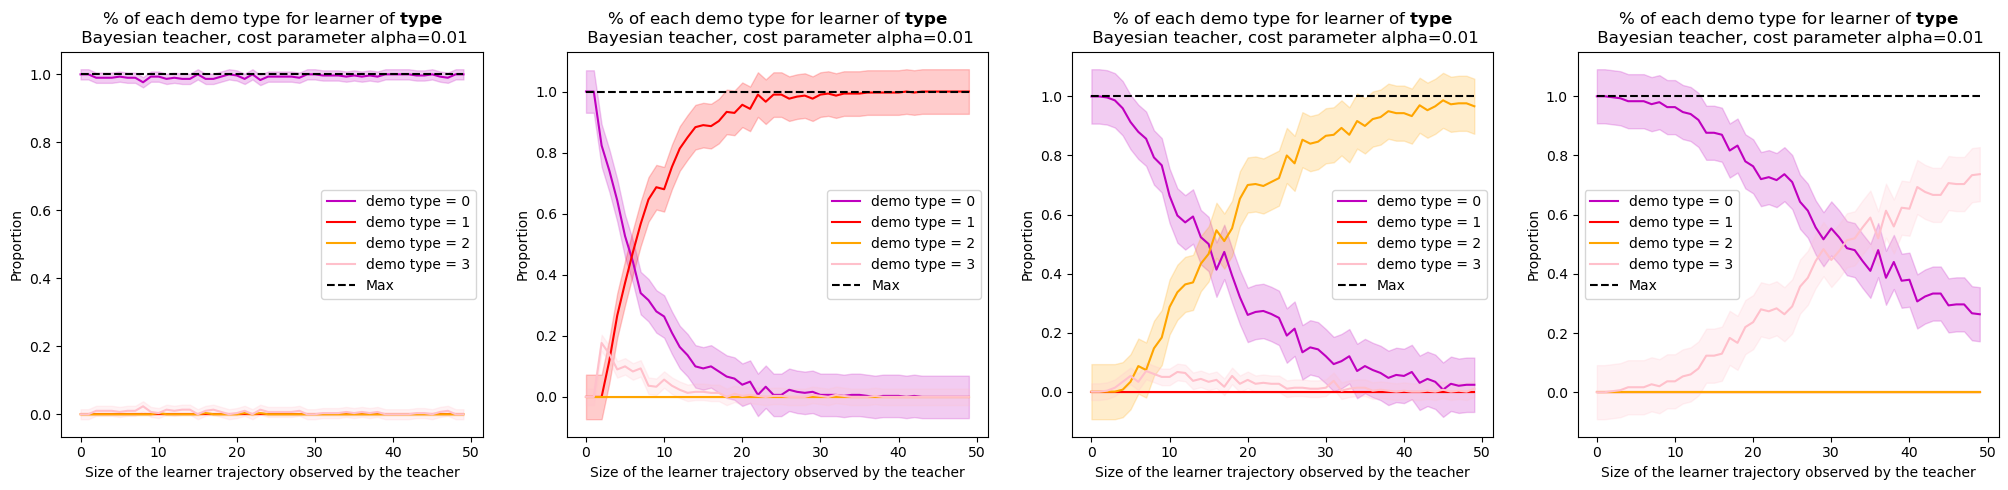

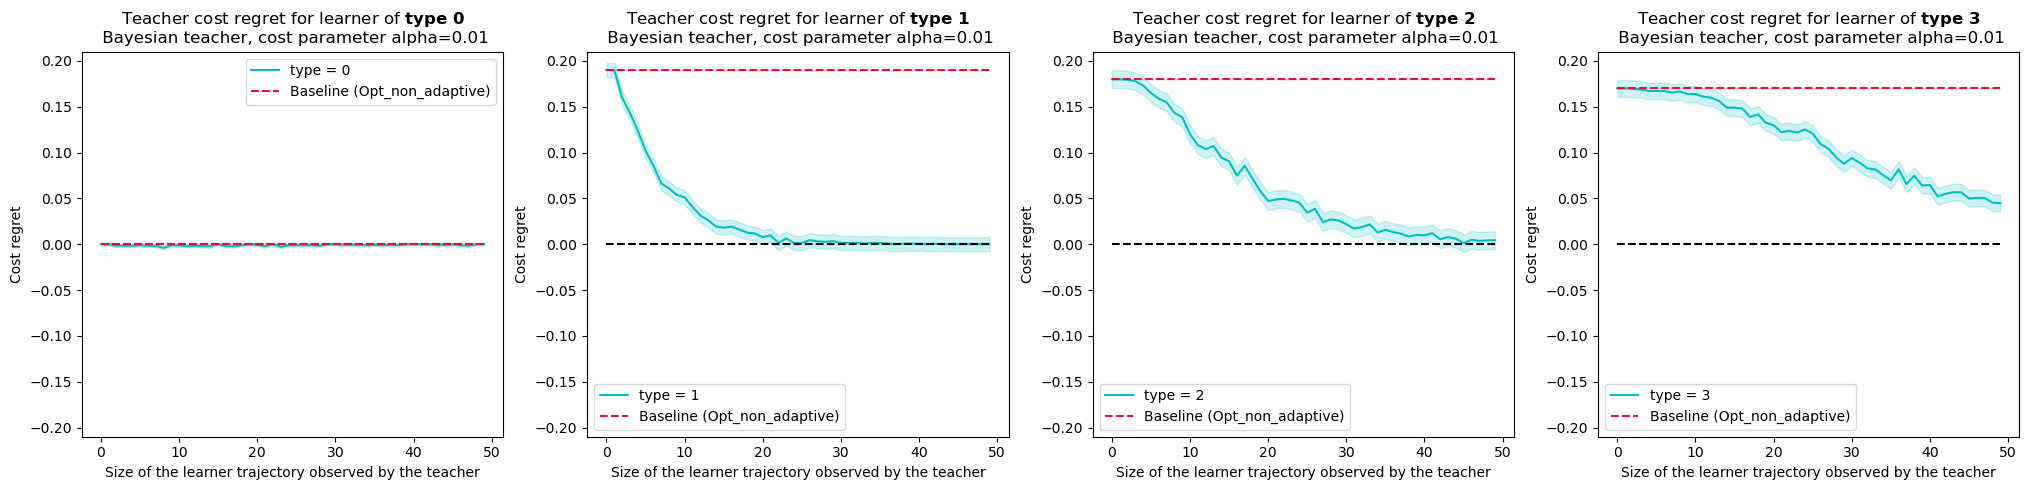

In [ ]:
method, alpha = 'Bayesian', alpha_values[0]
display_evaluation(method, alpha)

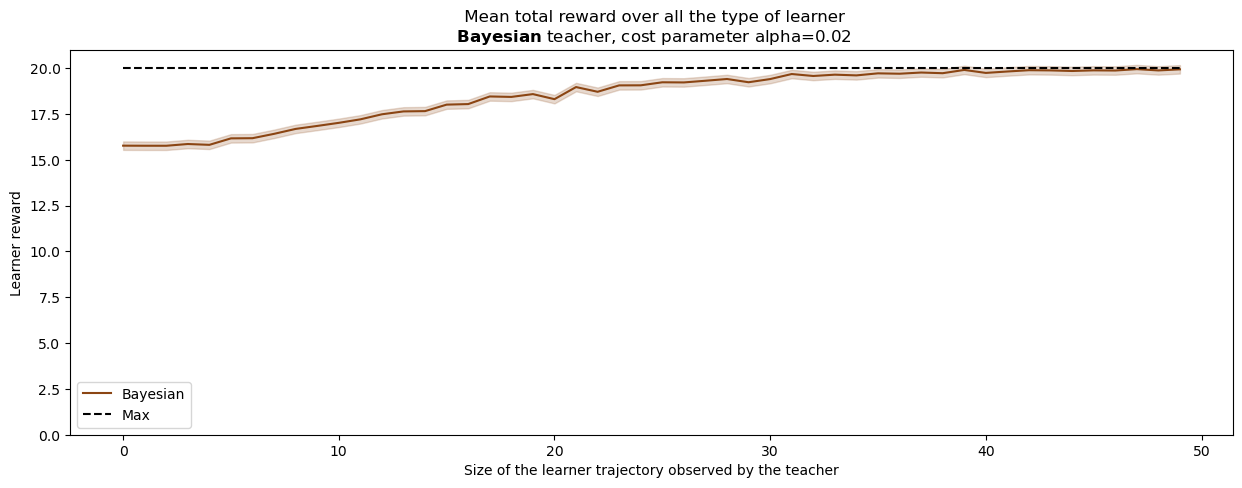

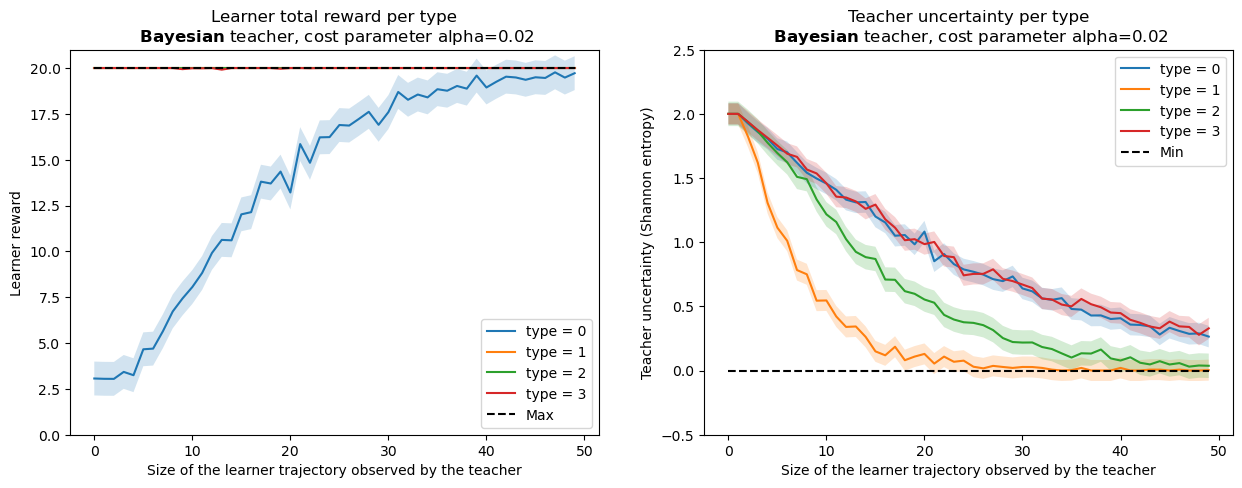

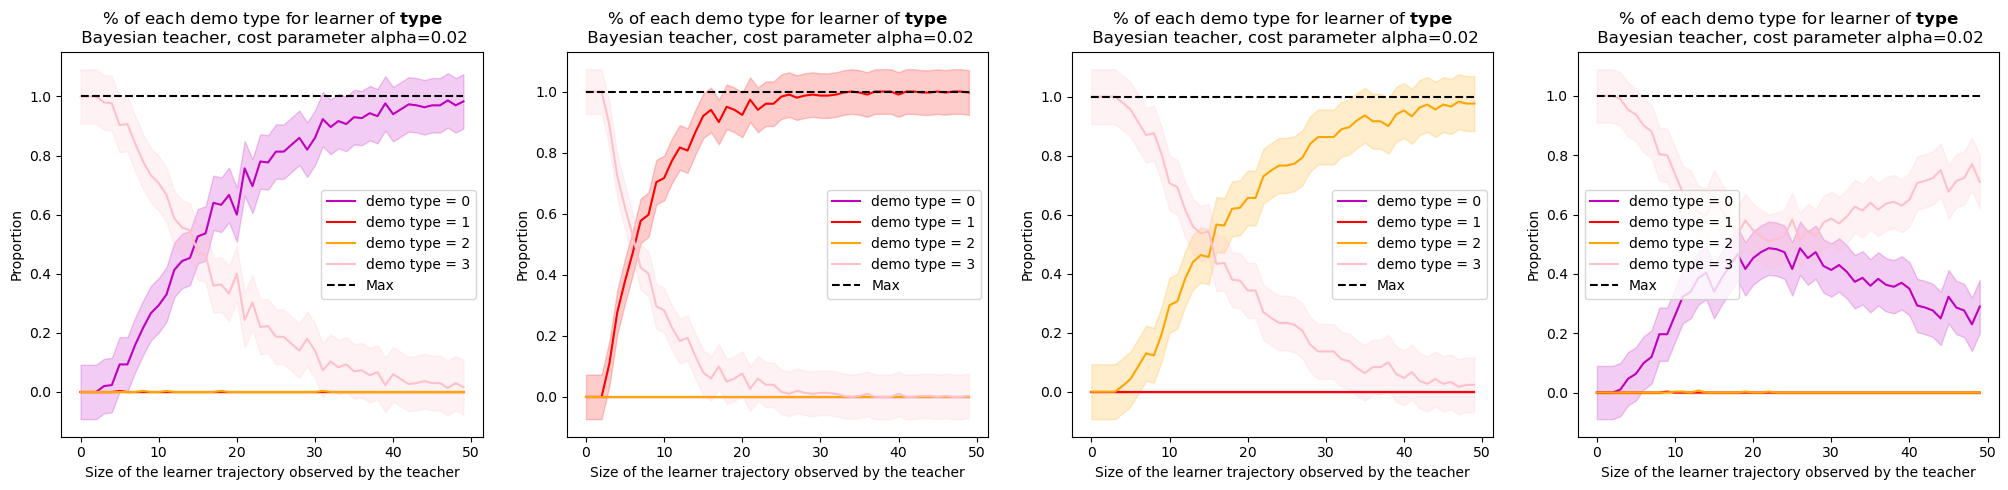

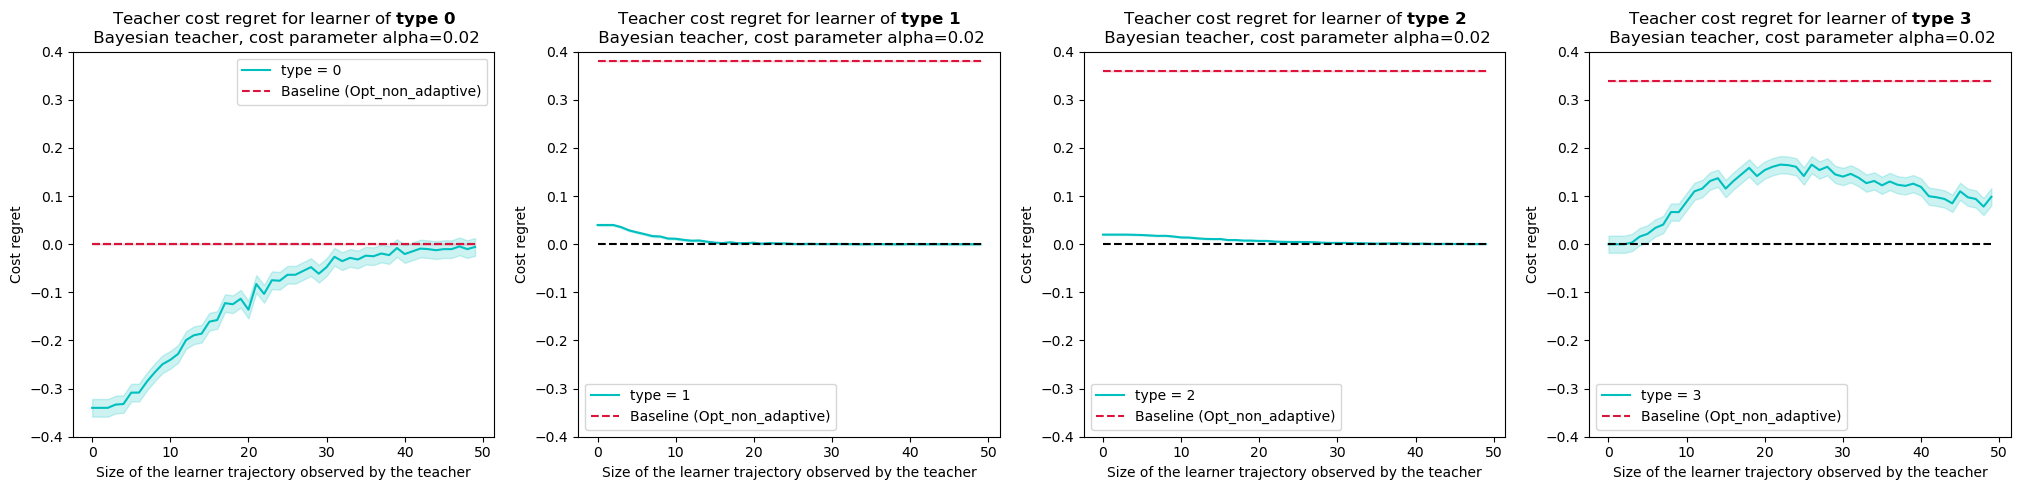

In [ ]:
method, alpha = 'Bayesian', alpha_values[1]
display_evaluation(method, alpha)

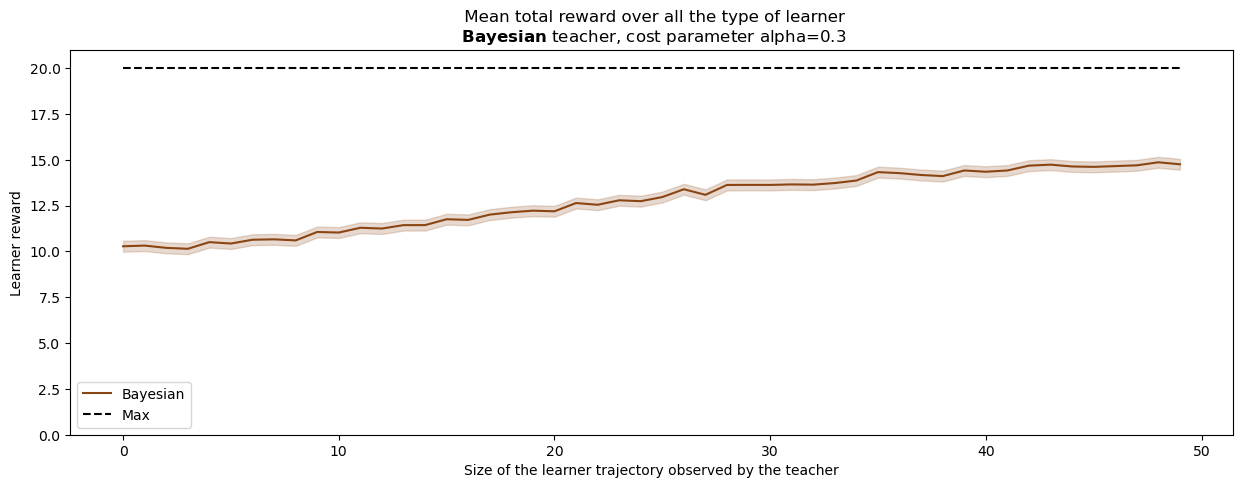

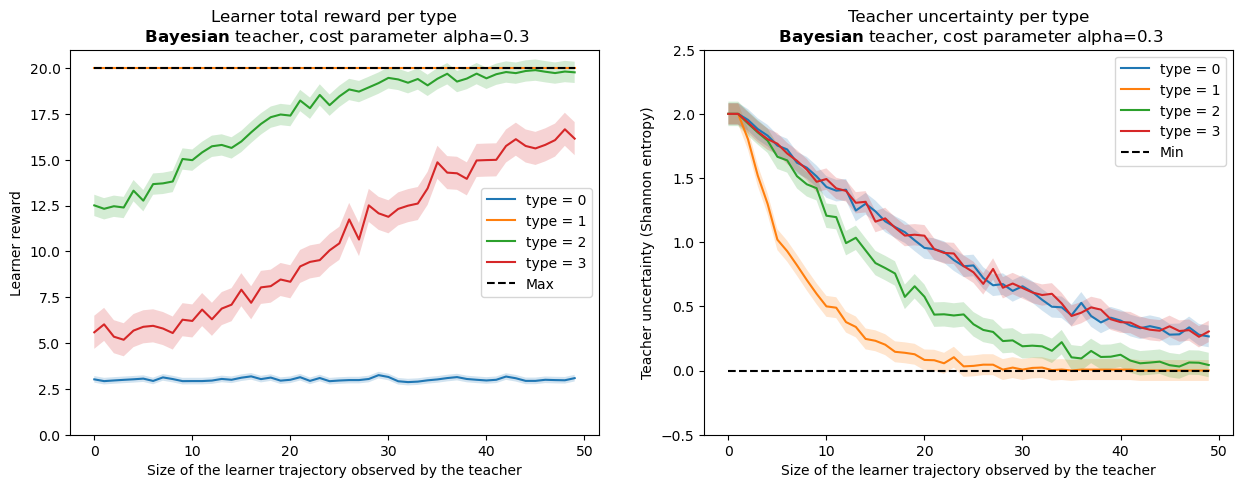

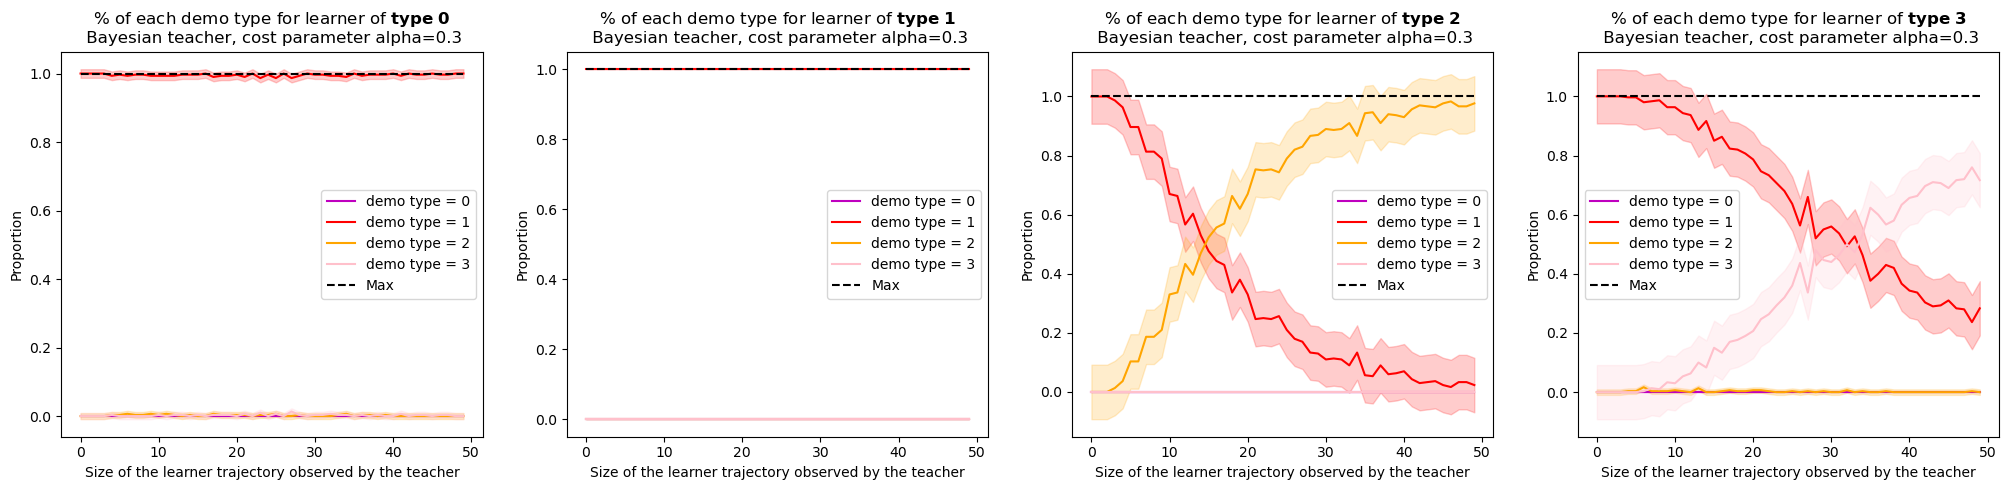

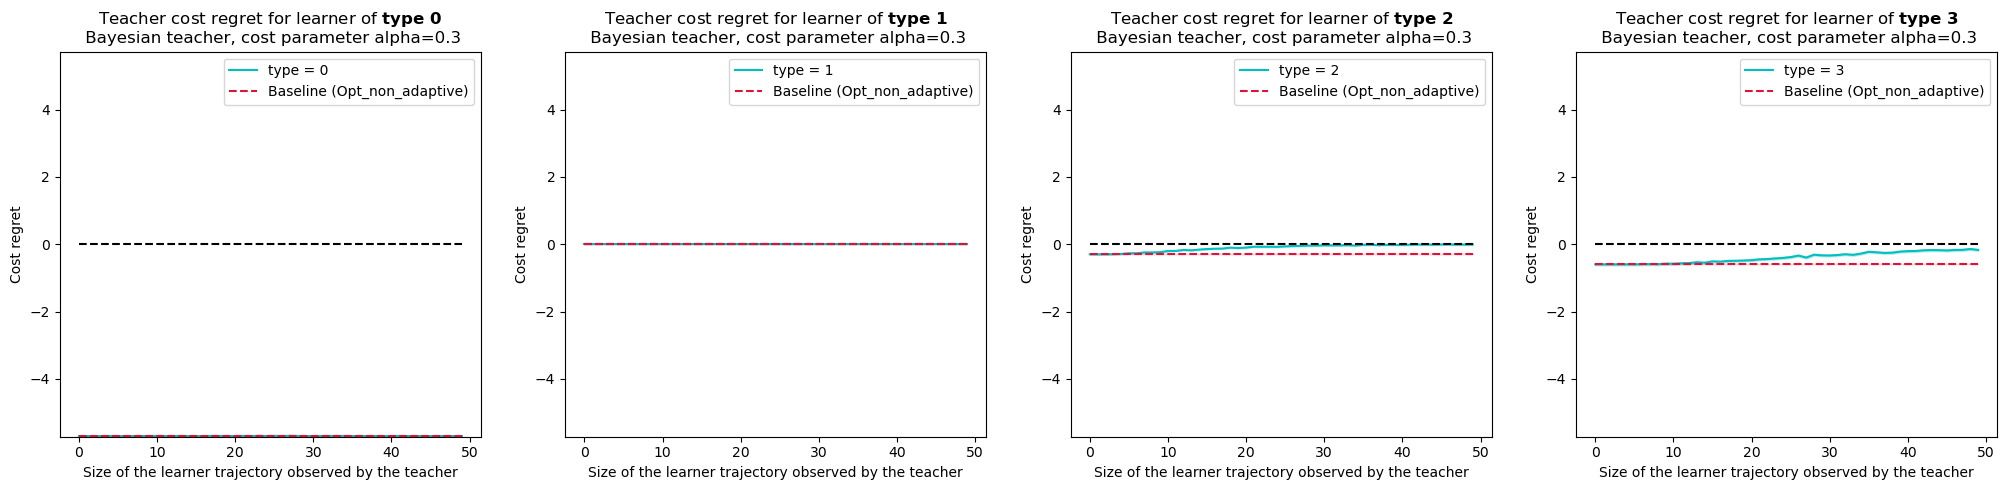

In [ ]:
method, alpha = 'Bayesian', 0.3
display_evaluation(method, alpha)

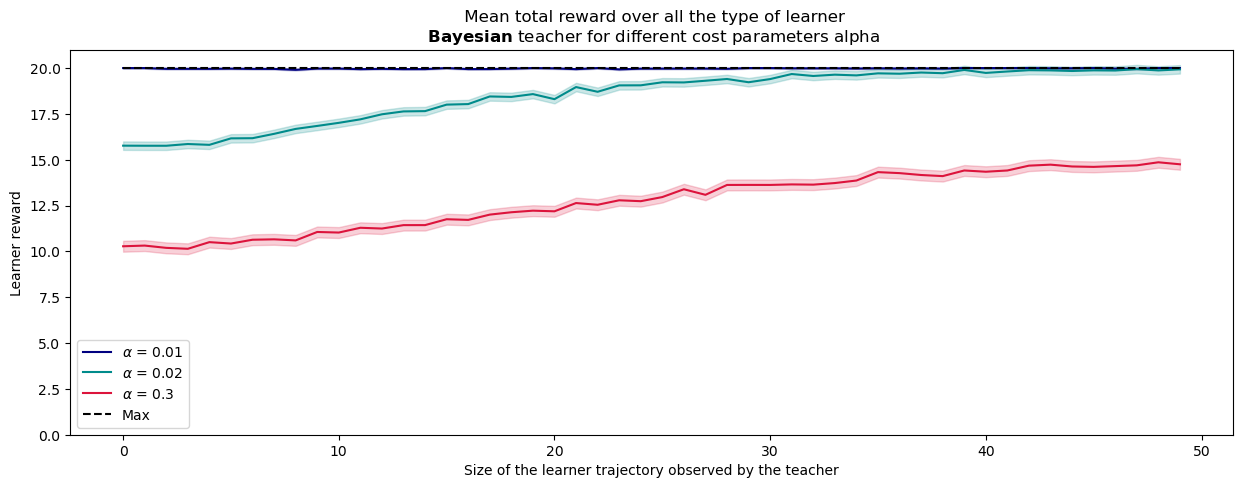

In [ ]:
method = 'Bayesian'
colors = ['navy', 'darkcyan', 'crimson']
fig0 = plt.figure(figsize=(15,5))
for aa,alpha in enumerate([0.01, 0.02, 0.3]):
    if LOADED:
        alpha = str(alpha)
    # Mean over the type of learner of the total reward on trajectory of size 20  (after seen the demo chosen by the teacher)
    all_evals = np.array([DICT[method][alpha][str(type)]['rewards'] if LOADED else DICT[method][alpha][type]['rewards'] for type in range(num_types)]).mean(axis=0)
    mean = np.mean(all_evals, axis=0)
    std = np.std(all_evals)

    plt.plot(mean, label=fr"$\alpha$ = {alpha}", color=colors[aa])
    plt.ylim(0, 21)
    plt.fill_between(np.arange(num_obs), mean + 1.96 * std / np.sqrt(N * N_envs), mean - 1.96 * std/np.sqrt(N * N_envs), alpha=0.2, color=colors[aa])
plt.plot(np.arange(num_obs), [20] * num_obs, c='k', label="Max", ls='--')
plt.xlabel('Size of the learner trajectory observed by the teacher')
plt.ylabel('Learner reward')
plt.title(fr' Mean total reward over all the type of learner'  + f'\n $\mathbf{{{method}}}$ teacher for different cost parameters alpha')
plt.legend();

#### Uniform teacher

In [ ]:
method = 'Uniform'
alpha_values = [0.03] #[0.01, 0.02] # Only to compute teacher regret

for alpha in alpha_values:
    evaluate(method, alpha) 

#### Optimal non adaptive teacher

In [ ]:
method = 'Opt_non_adaptive'
alpha_values = [0.3] #[0.01, 0.02, 0.3]

for alpha in alpha_values:
    evaluate(method, alpha)

/home/chetouani/Documents/STAGE_Clemence/ISIR_internship_ToM/experimental_setup_meta/utils.py:35: RuntimeWarning: divide by zero encountered in log2
  tab = proba_dist * np.log2(proba_dist)
/home/chetouani/Documents/STAGE_Clemence/ISIR_internship_ToM/experimental_setup_meta/utils.py:35: RuntimeWarning: invalid value encountered in multiply
  tab = proba_dist * np.log2(proba_dist)
/home/chetouani/Documents/STAGE_Clemence/ISIR_internship_ToM/experimental_setup_meta/learner.py:31: RuntimeWarning: invalid value encountered in divide
  updated_beliefs[a, :] /= updated_beliefs[a, :].sum()


#### Oracle

In [ ]:
method = 'Oracle'
alpha_values = [0.01, 0.02, 0.3]

for alpha in alpha_values:
    evaluate(method, alpha)

#### Saving

In [ ]:
save_output(DICT, './outputs/bayesian_ToM', 'teacher_eval')

### Tracking changeable learner

Experiment:
During the trajectory observed by the teacher, the learner changes its type. We want to observe if the ToM teacher keeps track of this change.

In [ ]:
# Global evaluation parameters
# DICT_tracking = {}
# LOADED = False
DICT_tracking = load_output('/home/chetouani/Documents/STAGE_Clemence/ISIR_internship_ToM/experimental_setup_meta/outputs/bayesian_ToM/teacher_eval_change_tracking.json')
LOADED = True

N = 100
N_envs = 3
num_obs = 60

n_eval = 20

num_types = 4
num_demo_types = num_types

#### Experiments and display

In [ ]:
def evaluate_tracking(changing_step: int, method: str, init_type: int, final_type: int, alpha: float=0.01, save: bool=True) -> None:
    if method not in DICT_tracking.keys():
        DICT_tracking[method] = {}
    DICT_tracking[method][changing_step] = {}
    DICT_tracking[method][changing_step]['rewards'] = []
    DICT_tracking[method][changing_step]['demo'] = []
    DICT_tracking[method][changing_step]['uncertainty'] = []
    for _ in range(N_envs):
        # Init envs
        observation_env = ButtonsToy(n_buttons, n_music)
        demonstration_env = ButtonsToy(n_buttons, n_music)
        for _ in range(N):
            cum_rewards = []
            all_demo = []
            uncertainties = []
            for n in range(num_obs):
                # Init teacher
                if method == 'MAP' or method == 'Bayesian':
                    teacher = BaysesianTeacher(env=observation_env,
                                                num_types=num_types)
                elif method == 'Uniform' or method == 'Opt_non_adaptive':
                    teacher = NaiveTeacher(env=observation_env,
                                                num_types=num_types)
                # Init learner
                learner = Learner(init_type)
                learner.init_env(observation_env)
                if method == 'MAP' or method == 'Bayesian':
                    # Observe the learner
                    traj = learner.act(size = min(changing_step, n))
                    teacher.observe(traj)
                    if n > changing_step:
                        # Change learner type
                        learner.type = final_type
                        traj = learner.act(size = n - changing_step)
                        teacher.observe(traj)
                    # Teacher uncertainty
                    uncertainties.append(Shannon_entropy(teacher.beliefs))
                # Chose demonstration
                teacher.init_env(demonstration_env)
                demo = teacher.demonstrate(method=method, alpha=alpha)
                # Show the demonstration
                learner.init_env(demonstration_env)
                learner.observe(demo)
                # Evaluate hwo helpful has been the demonstration
                _, rewards = learner.act(size=n_eval)
                # Append 
                cum_rewards.append(np.sum(rewards))
                all_demo.append(len(demo[0]))
            DICT_tracking[method][changing_step]['rewards'].append(cum_rewards)
            DICT_tracking[method][changing_step]['demo'].append(all_demo)
            DICT_tracking[method][changing_step]['uncertainty'].append(uncertainties)

In [ ]:
def display_tracking(method: str, init_type: int, final_type: int, alpha: float=0.01, save: bool=True) -> None:
    colors = ['indigo','orchid', 'hotpink', 'coral', 'red', 'brown']
    step_colors = ['indigo', 'purple', 'deeppink', 'orangered', 'darkred', 'saddlebrown']

    if method == 'MAP' or method == 'Bayesian':
        fig0, axes = plt.subplots(2, 1, figsize=(15,10))
    else:
        fig0, axes = plt.subplots(1, 1, figsize=(15,5))
        
    for ii, changing_step in enumerate(DICT_tracking[method].keys()):        
        if method == 'MAP' or method == 'Bayesian':
            ax = axes[0]
        else:
            ax = axes

        # Learner reward
        all_evals = DICT_tracking[method][changing_step]['rewards']
        mean = np.mean(all_evals, axis=0)
        std = np.std(all_evals)

        ax.plot(mean, label=f'changing step = {changing_step}', color=colors[ii])
        ax.set_ylim(0,21)
        ax.fill_between(np.arange(num_obs), mean + 1.96 * std / np.sqrt(N * N_envs), mean - 1.96 * std/np.sqrt(N * N_envs), alpha=0.2, color=colors[ii])
        ax.plot([int(changing_step)] * num_obs, np.linspace(0, 20, num_obs), ls='--', color=step_colors[ii])

        # Teacher uncertainty
        if method == 'MAP' or method == 'Bayesian':
            ax = axes[1]
            all_evals = DICT_tracking[method][changing_step]['uncertainty']
            mean = np.mean(all_evals, axis=0)
            std = np.std(all_evals)

            ax.plot(mean, label=f'changing step = {changing_step}', color=colors[ii])
            ax.set_ylim(- 0.5, Shannon_entropy(np.ones(num_types) / num_types) + 0.5)
            ax.fill_between(np.arange(num_obs), mean + 1.96 * std / np.sqrt(N * N_envs), mean - 1.96 * std/np.sqrt(N * N_envs), alpha=0.2, color=colors[ii])
            ax.plot([int(changing_step)] * num_obs, np.linspace(-0.5, 10, num_obs), ls='--', color=step_colors[ii])

    if method == 'MAP' or method == 'Bayesian':
        ax = axes[0]
    else:
        ax = axes
    # Learner total reward on trajectory of size 20 (after seen the teacher demonstration)
    ax.plot(np.arange(num_obs), [20] * num_obs, c='k', label="Max", ls='--')
    ax.set_xlabel('Size of the learner trajectory observed by the teacher')
    ax.set_ylabel('Learner reward')
    ax.legend()

    if method == 'MAP' or method == 'Bayesian':
        # Teacher uncertainty (Shannon entropy)
        axes[1].plot(np.arange(num_obs), [0] * num_obs, c='k', label="Min", ls='--')
        axes[1].set_xlabel('Size of the learner trajectory observed by the teacher')
        axes[1].set_ylabel('Teacher uncertainty')
        axes[1].legend()
    # Suptitle
    fig0.suptitle(fr' Demonstration chosen by $\mathbf{{{method}}}$ teacher ' + '\n' + \
        fr' Learner changing from type $\mathbf{{{init_type}}}$ to type $\mathbf{{{final_type}}}$')
    

    # Repartition btw type of demonstrations shown
    demo_colors = ['m', 'red', 'orange', 'pink']
    dict_length = len(DICT_tracking[method].keys())
    num_col = 3
    fig1, axes = plt.subplots(dict_length // num_col + 1 * (dict_length % num_col > 0), num_col, figsize=(20, 10))
    for ii, changing_step in enumerate(DICT_tracking[method].keys()):
        if dict_length > 1:
            ax = axes[ii // num_col, ii % num_col]
        else:
            ax = axes
        for demo_type in range(num_demo_types):
            demo_rep = np.array(DICT_tracking[method][changing_step]['demo'])
            if demo_type == 0:
                prop_demo = np.array(demo_rep == n_buttons)
            else:
                prop_demo = np.array(demo_rep == demo_type)
            mean = np.mean(prop_demo, axis=0)
            std = np.std(prop_demo)

            ax.plot(mean, label=f'demo type = {demo_type}', color=demo_colors[demo_type])
            ax.fill_between(np.arange(num_obs), mean + 1.96 * std / np.sqrt(N + N_envs), mean - 1.96 * std/np.sqrt(N + N_envs), alpha=0.2, color=demo_colors[demo_type])
            ax.plot([int(changing_step)] * num_obs, np.linspace(0, 1, num_obs), ls='--', color=step_colors[ii])
        ax.plot(np.arange(num_obs), [1] * num_obs, c='k', label="Max", ls='--')

        ax.set_title(f'Learner changing from type {init_type} to type {final_type} ' + \
                      fr'at $\mathbf{{step}}$ $\mathbf{{{changing_step}}}$')

        ax.set_xlabel('Size of the learner trajectory observed by the teacher')
        ax.set_ylabel('Proportion')
        ax.legend()

    # Super figure
    figs = [fig0, fig1]
    saving_names = ['per_step','chosen_demo']
    if save:
        for ii, fig in enumerate(figs):
            fig.savefig(f'./bayesian_ToM/figures/{method}/eval_with_changing_learner_from_{init_type}_to_{final_type}_{saving_names[ii]}_{method}_{alpha}.png')

#### MAP teacher

In [ ]:
changing_step_values = [0, 10, 20, 30, 40, 50]
for changin_step in changing_step_values:
    evaluate_tracking(changin_step, 'MAP', init_type=2, final_type=3)

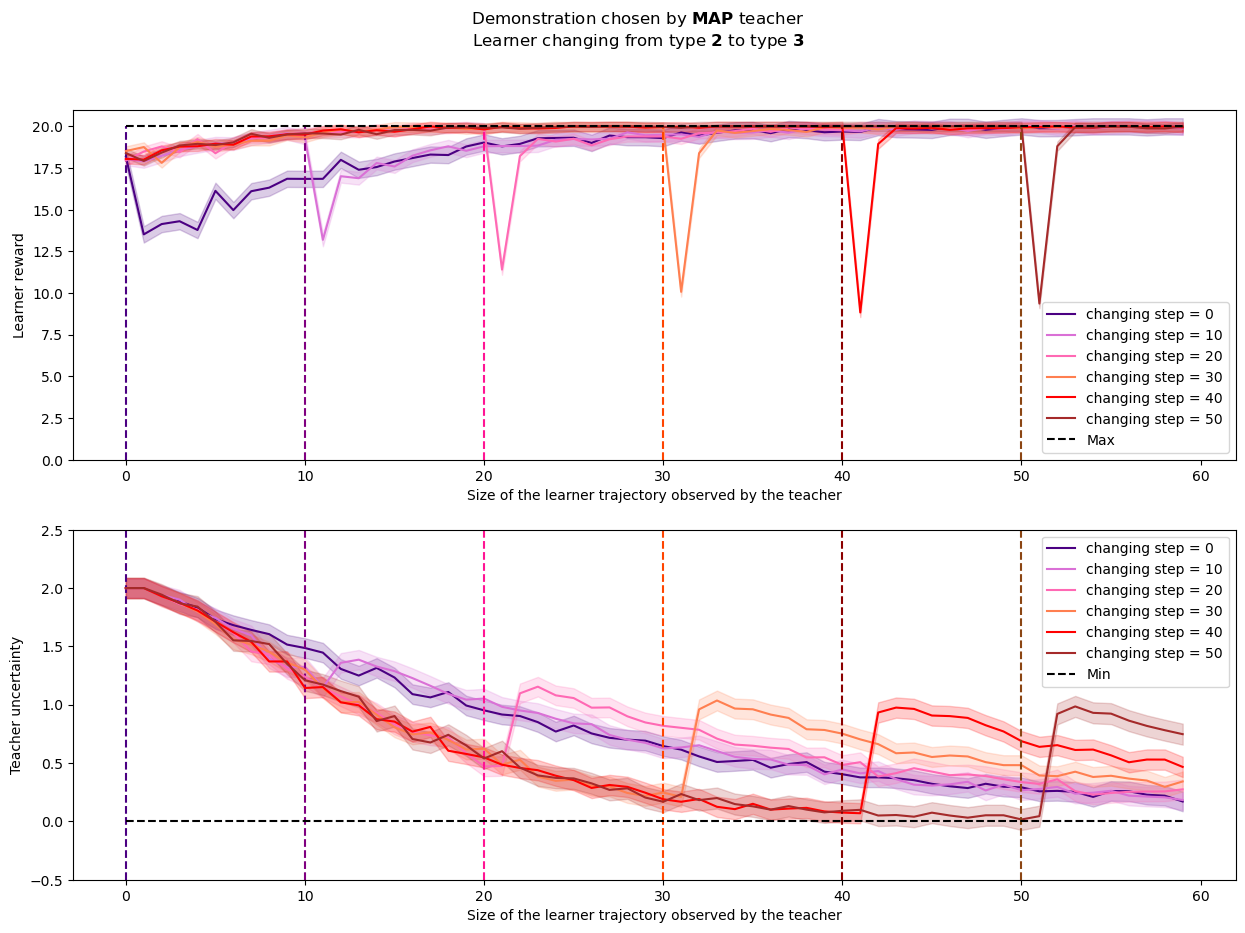

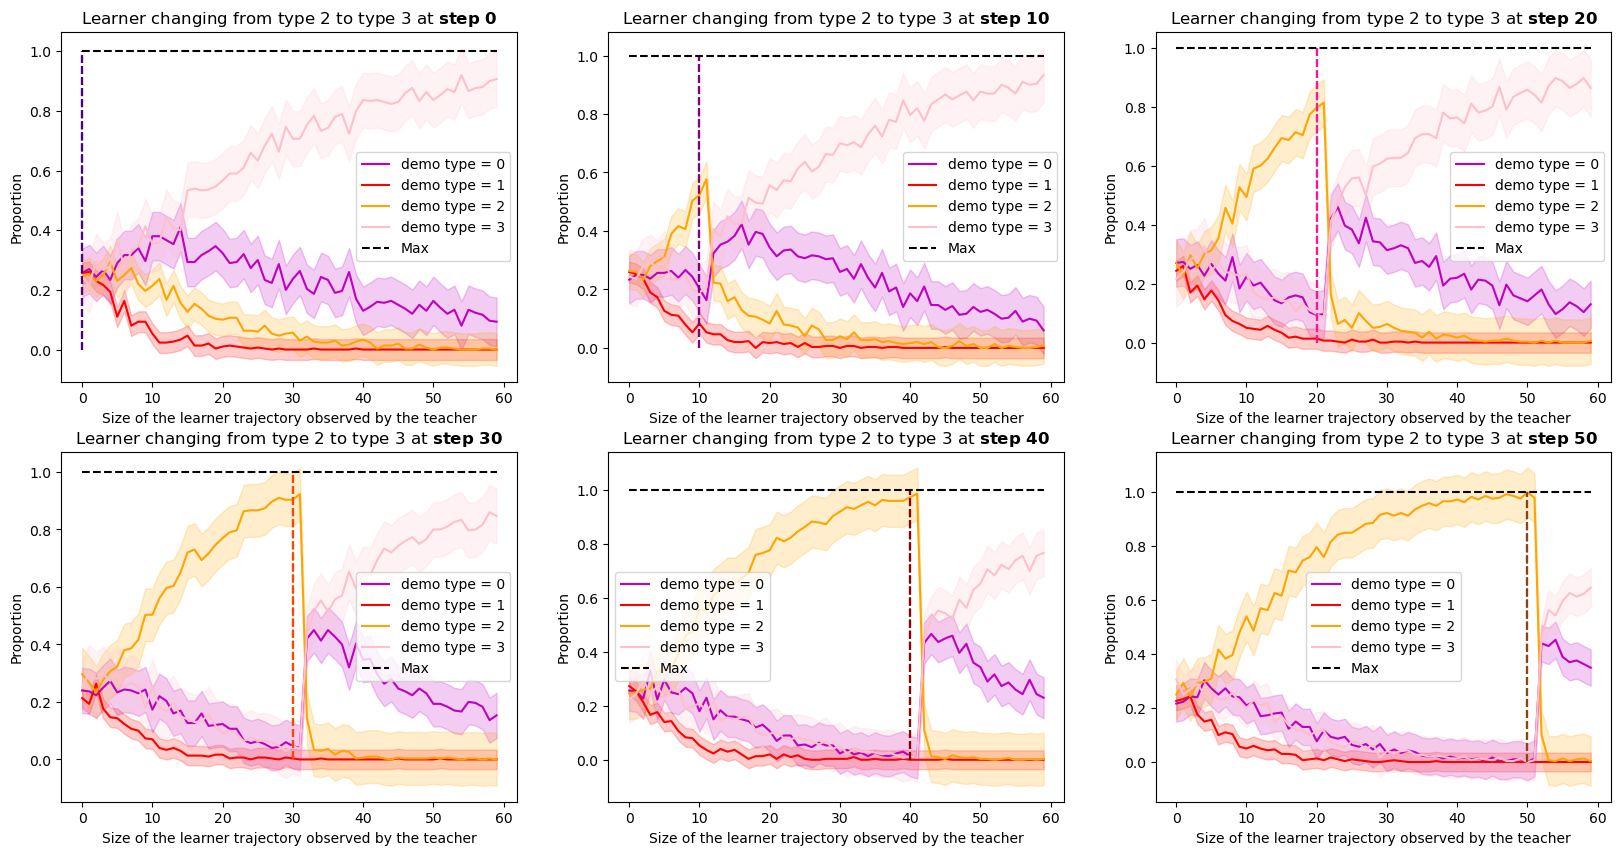

In [ ]:
display_tracking('MAP', init_type=2, final_type=3)

#### Bayesian Teacher

In [ ]:
changing_step_values = [0, 10, 20, 30, 40, 50]
for changin_step in changing_step_values:
    evaluate_tracking(changin_step, 'Bayesian', init_type=2, final_type=3)

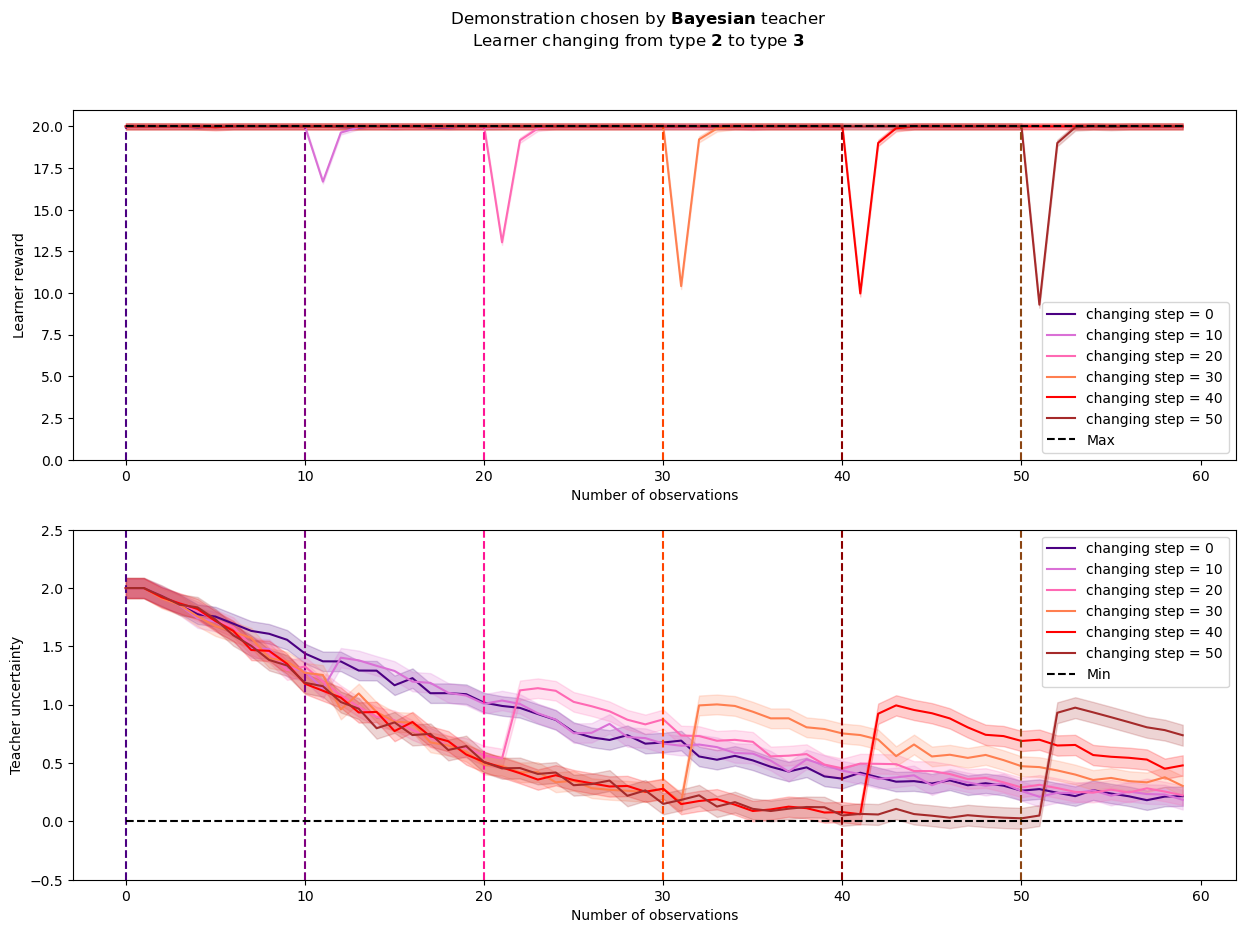

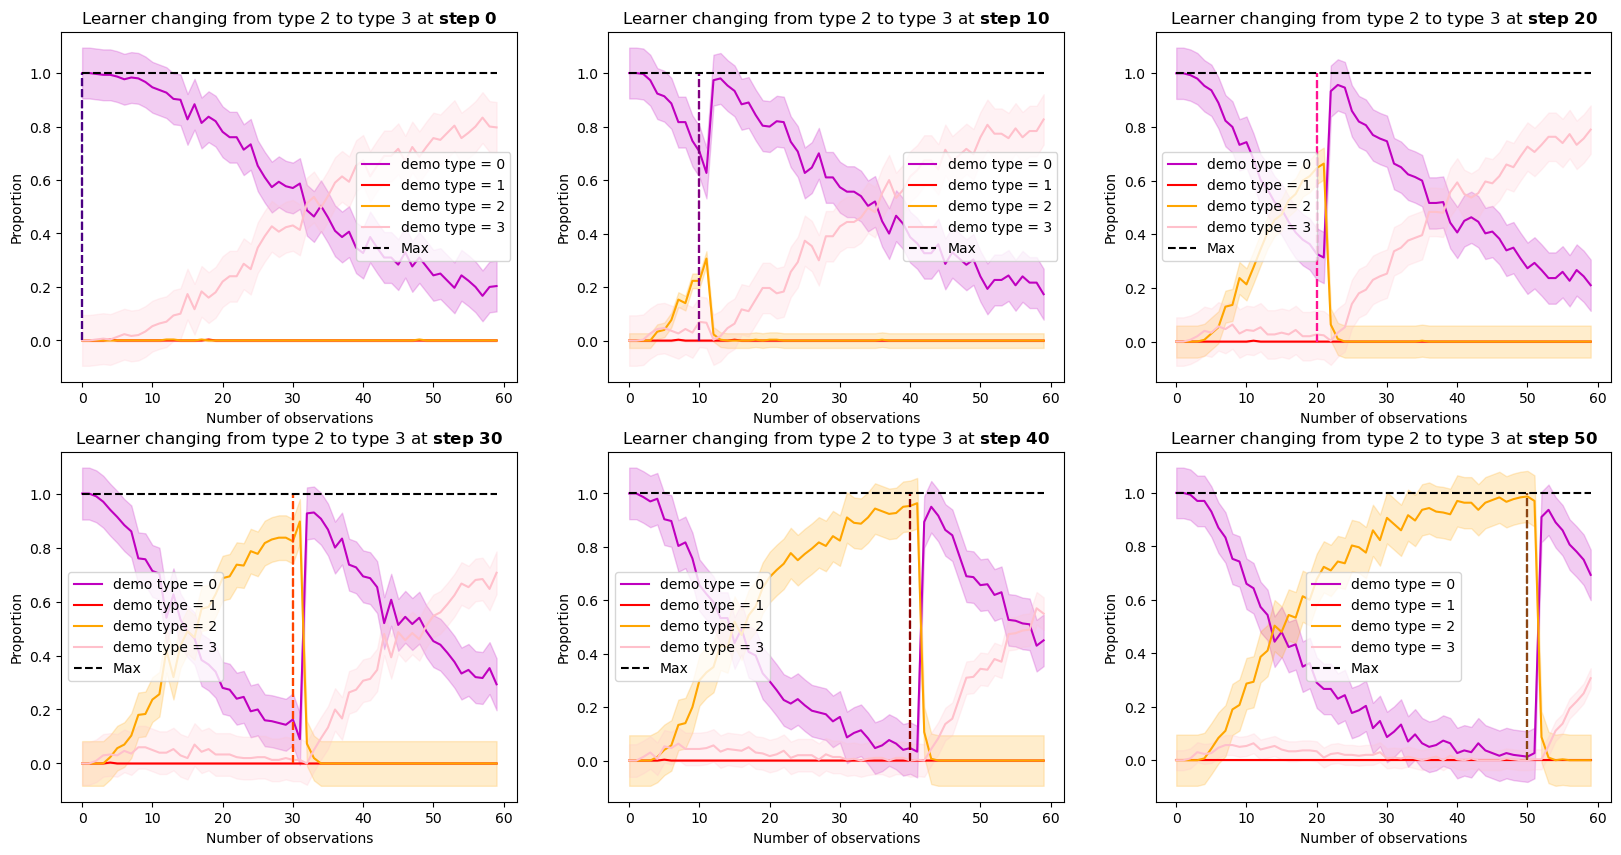

In [ ]:
display_tracking('Bayesian', init_type=2, final_type=3)

#### Uniform teacher

In [ ]:
changing_step_values = [0, 10, 20, 30, 40, 50]
for changin_step in changing_step_values:
    evaluate_tracking(changin_step, 'Uniform', init_type=2, final_type=3)

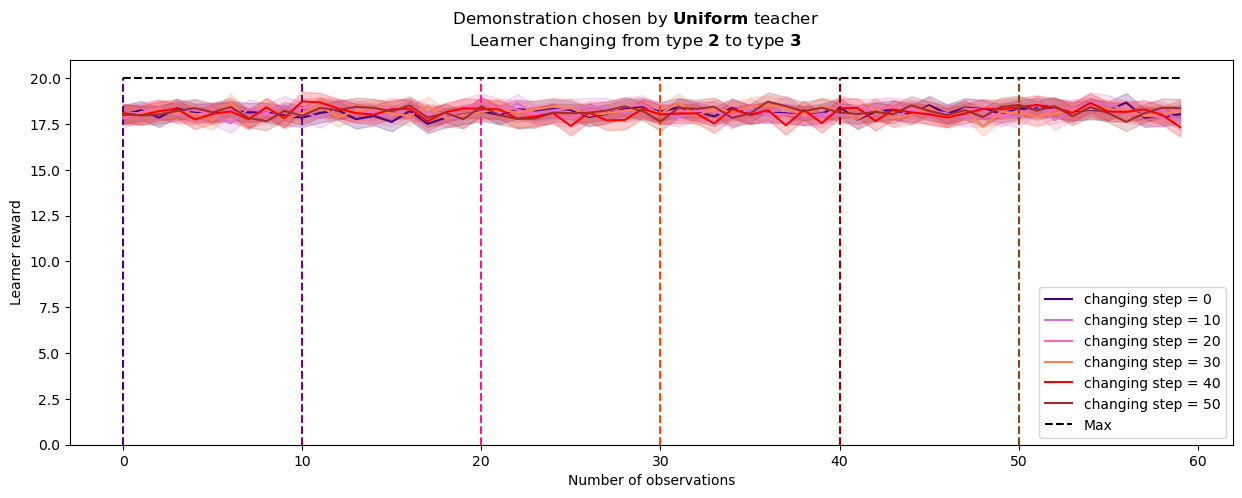

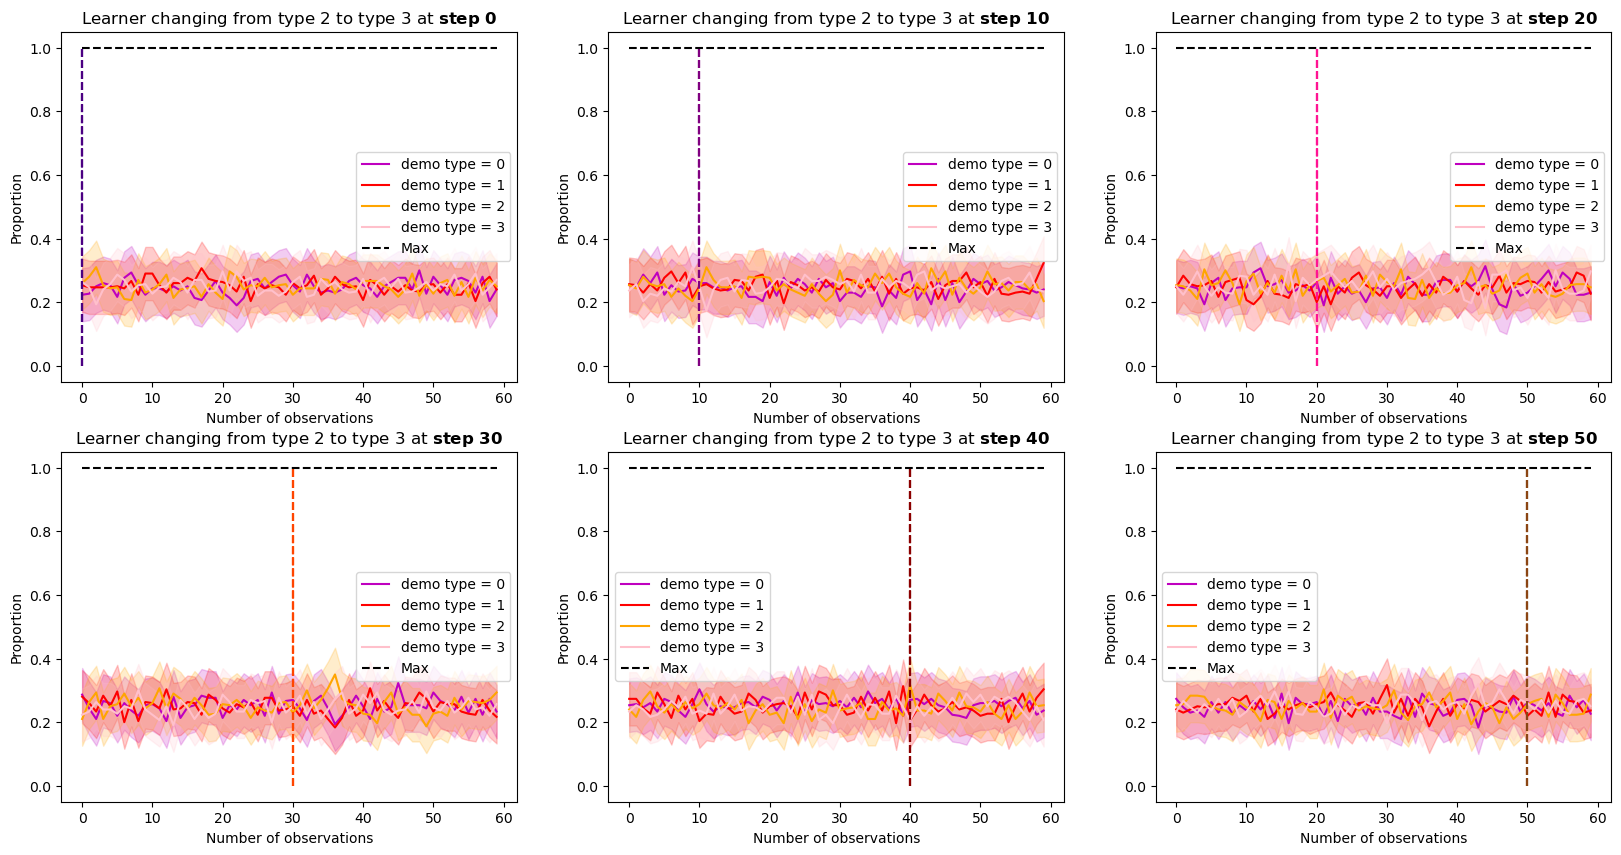

In [ ]:
display_tracking('Uniform', init_type=2, final_type=3)

#### Optimal non adaptive teacher

In [ ]:
changing_step_values = [0, 10, 20, 30, 40, 50]
for changin_step in changing_step_values:
    evaluate_tracking(changin_step, 'Opt_non_adaptive', init_type=2, final_type=3)

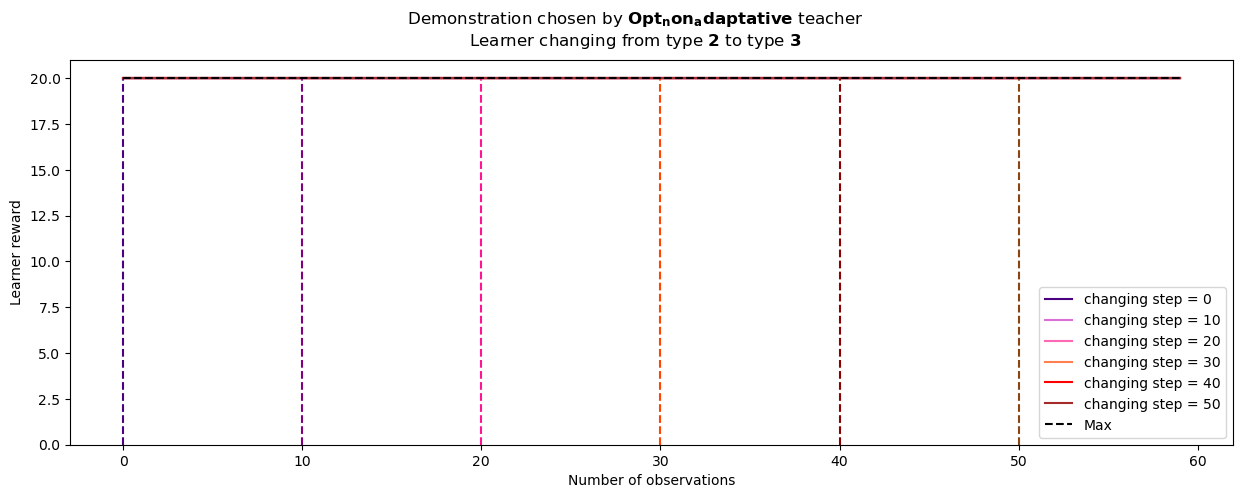

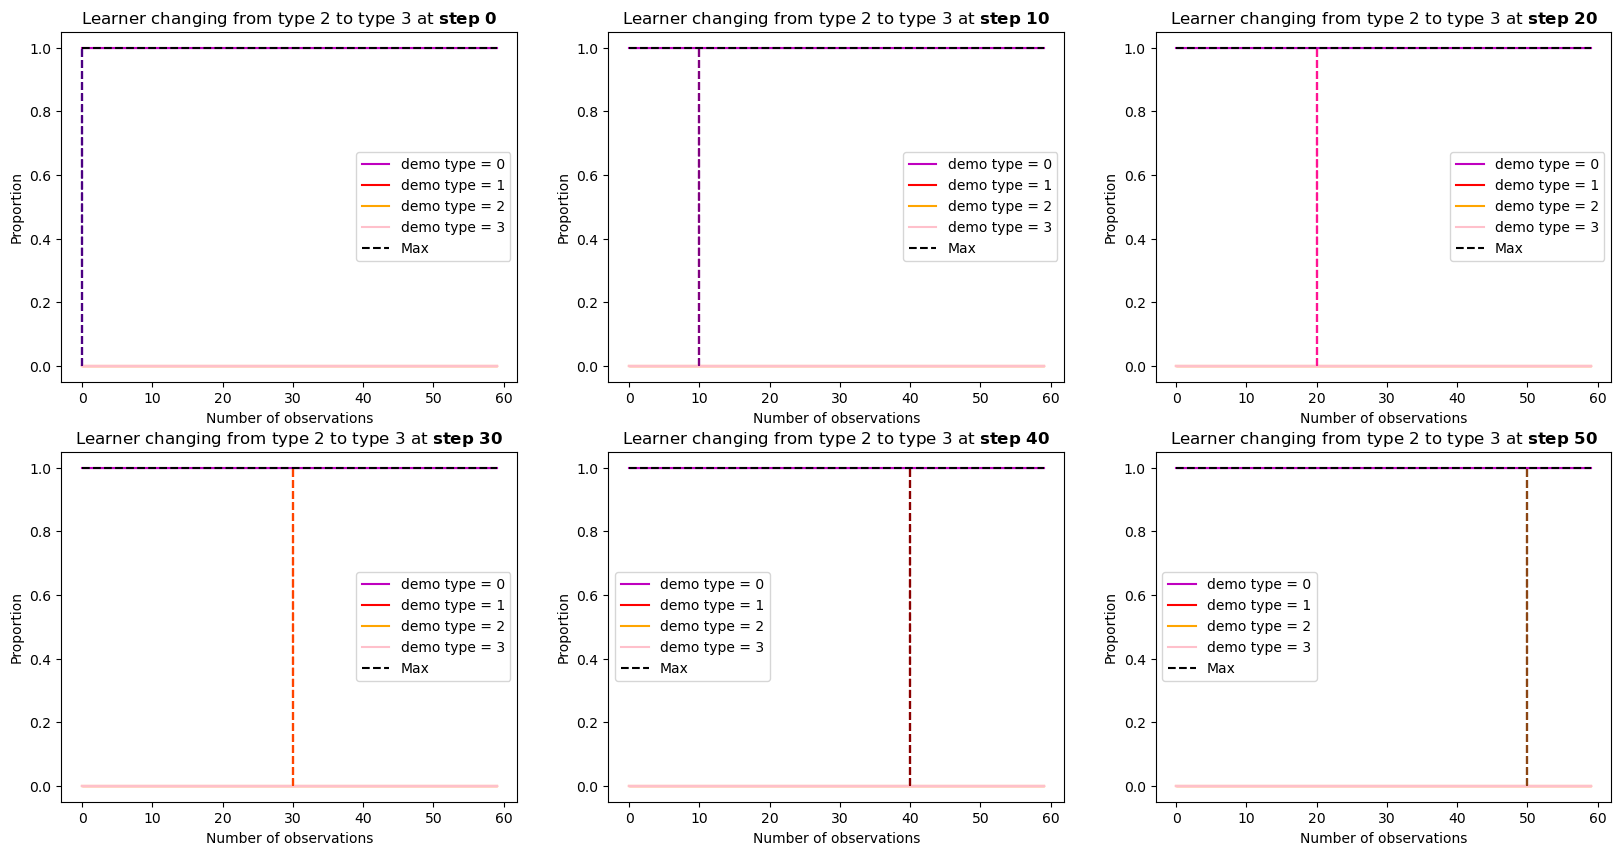

In [ ]:
display_tracking('Opt_non_adaptive', init_type=2, final_type=3)

#### Saving

In [ ]:
save_output(DICT_tracking, './outputs/bayesian_ToM', 'teacher_eval_change_tracking')

### Unknown learner type

The true type of the learner is out of the support of the teacher beliefs.
In this experiment, the teacher has a beliefs over the set of possible learners {type 0, type 1, type 2} and the learner observed by the teacher is of type 3.

Observation environment


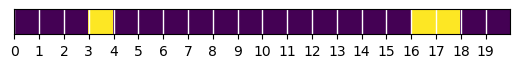

Demonstration environment


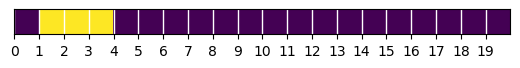

In [ ]:
observation_env = ButtonsToy(n_buttons, n_music)
print('Observation environment')
observation_env.render()
plt.show()

demonstration_env = ButtonsToy(n_buttons, n_music)
print('Demonstration environment')
demonstration_env.render()
plt.show()

num_types = 3 # Remove learner of type 3 (and associated demo) from the support of the teacher beliefs
num_demo_types = num_types
unknown_type = 3

In [ ]:
# Global evaluation parameters
# DICT_unknown = {}
# LOADED = False
DICT_unknown = load_output('./outputs/bayesian_ToM/teacher_eval_unknown_learner.json')
LOADED = True

N = 100
N_envs = 3
num_obs = 100

n_eval = 20

#### Experiments and display

In [ ]:
def evaluate_unknown(method: str, alpha: float) -> None:
    if method not in DICT_unknown.keys():
        DICT_unknown[method] = {}
    DICT_unknown[method][alpha] = {}
    DICT_unknown[method][alpha][unknown_type] = {}
    DICT_unknown[method][alpha][unknown_type]['rewards'] = []
    DICT_unknown[method][alpha][unknown_type]['demo'] = []
    DICT_unknown[method][alpha][unknown_type]['uncertainty'] = []
    DICT_unknown[method][alpha][unknown_type]['teacher_beliefs'] = []
    for _ in range(N_envs):
        # Init envs
        observation_env = ButtonsToy(n_buttons, n_music)
        demonstration_env = ButtonsToy(n_buttons, n_music)
        for _ in range(N):
            cum_rewards = []
            all_demo = []
            uncertainties = []
            teacher_beliefs = []
            for n in range(num_obs):
                # Init teacher
                if method == 'MAP' or method == 'Bayesian':
                    teacher = BaysesianTeacher(env=observation_env,
                                                num_types=num_types)
                elif method == 'Uniform' or method == 'Opt_non_adaptive':
                    teacher = NaiveTeacher(env=observation_env,
                                                num_types=num_types)
                # Init learner
                learner = Learner(unknown_type) # unknown type for the teacher
                learner.init_env(observation_env)
                if method == 'MAP' or method == 'Bayesian':
                    # Observe the learner
                    traj = learner.act(size=n)
                    teacher.observe(traj)
                    # Teacher uncertainty
                    uncertainties.append(Shannon_entropy(teacher.beliefs))
                    teacher_beliefs.append(teacher.beliefs)
                # Chose demonstration
                teacher.init_env(demonstration_env)
                demo = teacher.demonstrate(method=method, alpha=alpha)
                # Show the demonstration
                learner.init_env(demonstration_env)
                learner.observe(demo)
                # Evaluate hwo helpful has been the demonstration
                _, rewards = learner.act(size=n_eval)
                # Append
                cum_rewards.append(np.sum(rewards))
                all_demo.append(len(demo[0]))
            DICT_unknown[method][alpha][unknown_type]['rewards'].append(cum_rewards)
            DICT_unknown[method][alpha][unknown_type]['demo'].append(all_demo)
            DICT_unknown[method][alpha][unknown_type]['uncertainty'].append(uncertainties)
            DICT_unknown[method][alpha][unknown_type]['teacher_beliefs'].append(teacher_beliefs)

In [ ]:
def display_evaluation_unknwon(method: str, alpha: float, save: bool=True):
    demo_colors = ['m', 'red', 'orange', 'pink']
    if LOADED:
        alpha = str(alpha)
        unknown_type_str = str(unknown_type)
    else:
        unknown_type_str = unknown_type

    suptitle = f'Evaluation of the {str(method)} teacher on unknwon learner type {unknown_type_str} (with cost parameter alpha={alpha})'
    centered_suptitle = suptitle.center(150)
    print(f"\033[1m" + centered_suptitle + f"\033[0m ")

    fig0 = plt.figure(figsize=(15,5))
    # Learner total reward on trajectory of size 20 (after seen the demo chosen by the teacher (unknown learner type)
    all_evals = np.array(DICT_unknown[method][alpha][unknown_type_str]['rewards'])
    mean = np.mean(all_evals, axis=0)
    std = np.std(all_evals)

    plt.plot(mean, label=f'mean')
    plt.ylim(0, 21)
    plt.fill_between(np.arange(num_obs), mean + 1.96 * std / np.sqrt(N * N_envs), mean - 1.96 * std / np.sqrt(N * N_envs), alpha=0.2)
    plt.plot(np.arange(num_obs), [20] * num_obs, c='k', label="Max", ls='--')
    
    # Baseline
    if method == 'MAP' or method == 'Bayesian':
        baseline = 'Uniform' if method == 'MAP' else 'Opt_non_adaptive'
        all_evals = np.array(DICT_unknown[baseline][alpha][unknown_type_str]['rewards'])
        mean = np.mean(all_evals, axis=0)
        std = np.std(all_evals)

        plt.plot(mean, label=f'Baseline ({baseline})', color='crimson')
        plt.fill_between(np.arange(num_obs), mean + 1.96 * std / np.sqrt(N * N_envs), mean - 1.96 * std / np.sqrt(N * N_envs), alpha=0.2, color='crimson')

    plt.title(fr'Learner total reward ' + '\n' + fr'$\mathbf{{{method}}}$ teacher for $\mathbf{{unknwon \quad learner \quad of \quad type \quad {unknown_type_str}}}$' + f'\n cost parameter alpha={alpha} (95% c.i)')

    plt.xlabel('Size of the learner trajectory observed by the teacher')
    plt.ylabel('Learner reward')
    plt.legend()

    fig1 = plt.figure(figsize=(25,5))

    # Teacher uncertainty
    if method == 'MAP' or method == 'Bayesian':
        fig1.add_subplot(1,3,1)
        all_evals = np.array(DICT_unknown[method][alpha][unknown_type_str]['uncertainty'])
        mean = np.mean(all_evals, axis=0)
        std = np.std(all_evals)

        plt.plot(mean)
        plt.ylim(- 0.5 , Shannon_entropy(np.ones(num_types) / num_types) + 0.5)
        plt.fill_between(np.arange(num_obs), mean + 1.96 * std / np.sqrt(N * N_envs), mean - 1.96 * std/np.sqrt(N * N_envs), alpha=0.2)
        plt.plot(np.arange(num_obs), [0] * num_obs, c='k', label="Min", ls='--')
        plt.title(fr'Teacher uncertainty ' + '\n' + fr'$\mathbf{{{method}}}$ teacher (95% c.i)')

        plt.xlabel('Size of the learner trajectory observed by the teacher')
        plt.ylabel('Teacher uncertainty (Shannon entropy)')
        plt.legend()

        fig1.add_subplot(1,3,2)
        # Teacher beliefs (per type of learner)
        for type in range(np.array(DICT_unknown[method][alpha][unknown_type_str]['teacher_beliefs']).shape[-1]):
            all_evals = np.array(DICT_unknown[method][alpha][unknown_type_str]['teacher_beliefs'])[:, :, type] ### TEST WARNING
            mean = np.mean(all_evals, axis=0)
            std = np.std(all_evals, axis=0)

            plt.plot(mean, label=f'type = {type}')
            plt.fill_between(np.arange(num_obs), mean + 1.96 * std / np.sqrt(N * N_envs), mean - 1.96 * std/np.sqrt(N * N_envs), alpha=0.2)
        plt.plot(np.arange(num_obs), [1] * num_obs, c='k', label="Max", ls='--')
        plt.title(fr'Teacher beliefs per type of learner ' + '\n' + fr'$\mathbf{{{method}}}$ teacher (95% c.i)')

        plt.xlabel('Size of the learner trajectory observed by the teacher')
        plt.ylabel('Teacher beliefs')
        plt.legend()

    # Repartition btw type of demonstrations shown
    fig1.add_subplot(1,3,3)
    for demo_type in range(num_demo_types):
        demo_rep = np.array(DICT_unknown[method][alpha][unknown_type_str]['demo'])
        if demo_type == 0:
            prop_demo = np.array(demo_rep == n_buttons)
        else:
            prop_demo = np.array(demo_rep == demo_type)
        mean = np.mean(prop_demo, axis=0)
        std = np.std(prop_demo)

        plt.plot(mean, label=f'demo type = {demo_type}', color=demo_colors[demo_type])
        plt.fill_between(np.arange(num_obs), mean + 1.96 * std / np.sqrt(N + N_envs), mean - 1.96 * std/np.sqrt(N + N_envs), alpha=0.2, color=demo_colors[demo_type])
    plt.plot(np.arange(num_obs), [1] * num_obs, c='k', label="Max", ls='--')

    plt.title(f'% of each demo type for learner of unknown $\mathbf{{type}}$ ' + fr'$\mathbf{{{unknown_type_str}}}$' + '\n' + f'{method} teacher, cost parameter alpha={alpha} (95% c.i)')
    plt.xlabel('Size of the learner trajectory observed by the teacher')
    plt.ylabel('Proportion')
    plt.legend()

# Super figure
    figs = [fig0, fig1]
    saving_names = ['reward','chosen_demo']
    if save:
        for ii, fig in enumerate(figs):
            fig.savefig(f'./bayesian_ToM/figures/{method}/eval_with_unknown_learner_{saving_names[ii]}_{method}_{alpha}.png')

#### MAP teacher

In [ ]:
method, alpha = 'MAP', 0.01
evaluate_unknown(method, alpha)

                               Evaluation of the MAP teacher on unknwon learner type 3 (with cost parameter alpha=0.01)                                


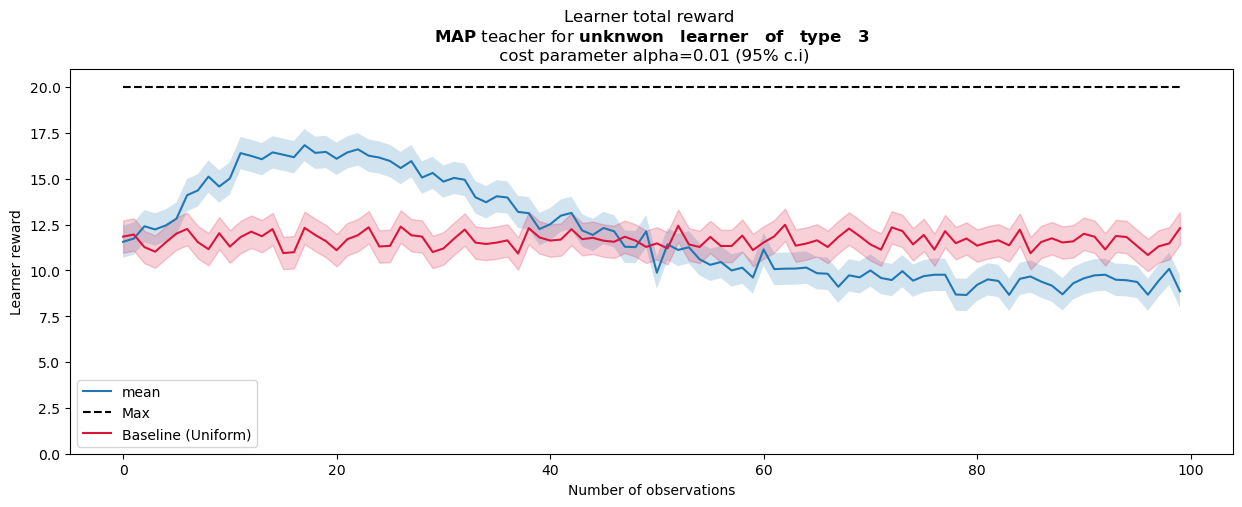

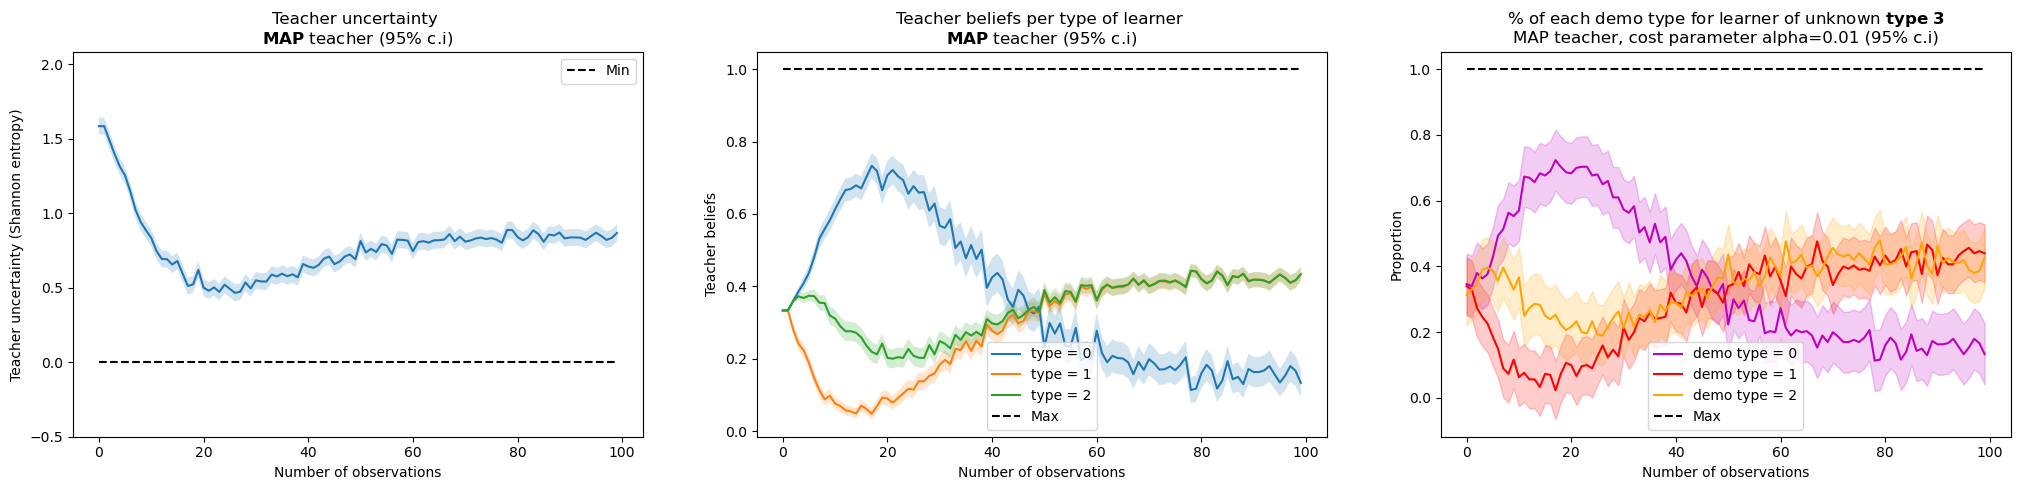

In [ ]:
display_evaluation_unknwon('MAP', alpha, save=True)

#### Bayesian teacher

In [ ]:
method, alpha = 'Bayesian', 0.01
evaluate_unknown(method, alpha)

                            Evaluation of the Bayesian teacher on unknwon learner type 3 (with cost parameter alpha=0.01)                              


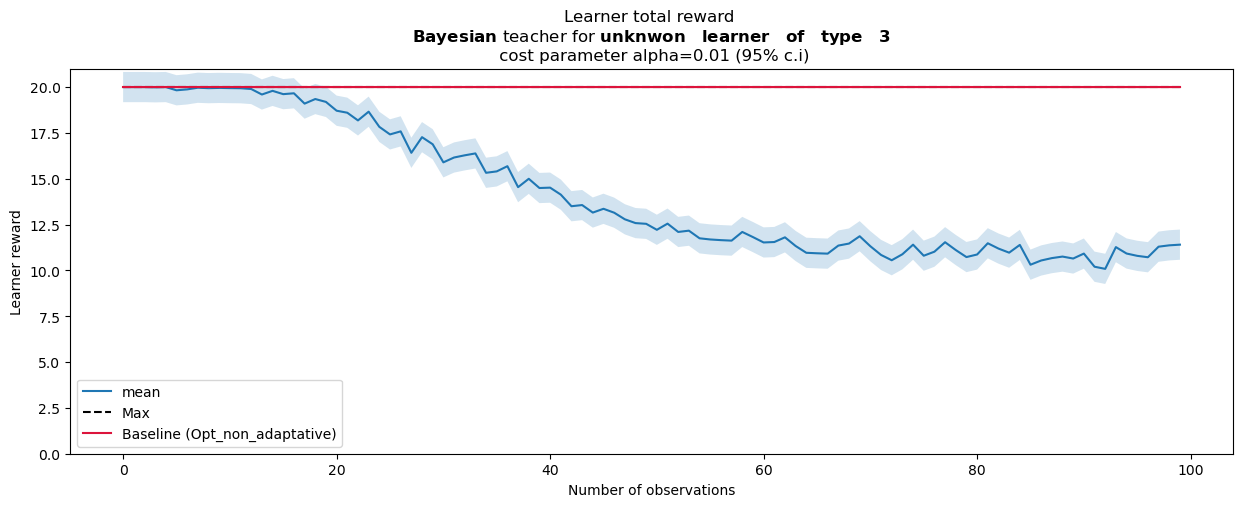

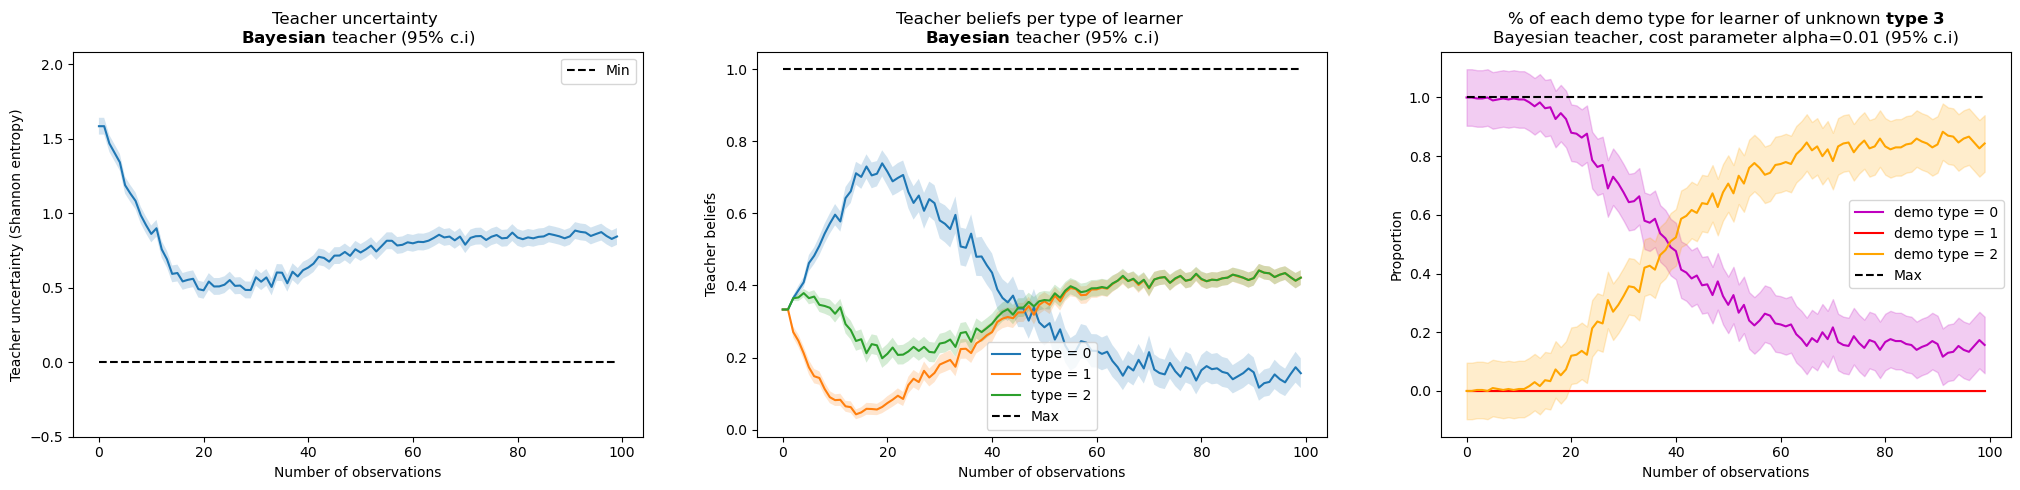

In [ ]:
display_evaluation_unknwon('Bayesian', alpha, save=True)

#### Uniform teacher

In [ ]:
method, alpha = 'Uniform', 0.01
evaluate_unknown(method, alpha)

#### Optimal non adaptive teacher

In [ ]:
method, alpha = 'Opt_non_adaptive', 0.01
evaluate_unknown(method, alpha)

#### Saving

In [ ]:
save_output(DICT_unknown, './outputs/bayesian_ToM', 'teacher_eval_unknown_learner')

## ToMNet Teacher

Evaluation of the ToMNet policy prediction deep model (adatation from the paper Machine Theory of Mind Rabinowitz et al. 2018)
- training curves
- inference vizualisation
- display of the predicted reward (and associated predicted utility) and the distance to the predicted policy as map (per type per demo type)

Evaluation of the ToMNet teacher which is the teacher using the ToMNet prediction model to select the best demonstration to show to the learner

In [4]:
import torch
import os

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from tqdm import trange

from neural_network_ToM.dataset import ToMNetDataset
from neural_network_ToM.nn_utils import load_data, load_config

from neural_network_ToM.model import PredNet
from neural_network_ToM.model_with_mask import PredNet

from neural_network_ToM.storage import Storage
from torch.utils.data import DataLoader

from neural_network_ToM.nn_result_viz import *

### Policy prediction model (ToMNet)

In [15]:
# Settup parameters
num_types = 4
num_demo_types = num_types

In [16]:
criterion = 'acc'

# Load PreNet model
loading_path = './neural_network_ToM/model_weights/super_big_single_no_current_varying_length_12.06.2023.11.20'
saving_name = loading_path[35:]
print(f'Saving statistics and figures at {saving_name}')

model_loading_path = os.path.join(loading_path, f'prednet_model_best_{criterion}.pt')
device = 'cpu'

model_config = load_config(os.path.join(loading_path, f'config_best_{criterion}.json'))
training_outputs = load_config(os.path.join(loading_path, 'outputs.json'))

# # Evaluation dataset with single past trajectory and empty current trajectory
# data_loading_path = os.path.join('neural_network_ToM', './data/eval_single')
# data_loading_path = os.path.join('neural_network_ToM', './data/eval_single_no_current')

data_loading_path = os.path.join('neural_network_ToM', model_config['data_path'])
config = load_config(os.path.join(data_loading_path, 'config_dataset.json'))

# Dataset parameters
n_buttons, n_music = config['n_buttons'], config['n_music']
num_past, max_steps, min_steps, max_steps_current = config['num_past'], config['max_steps'], config['min_steps'], config['max_steps_current']
n_agent_train, n_agent_val, n_agent_test = config['n_agent_train'], config['n_agent_val'], config['n_agent_test']

using_dist = config['true_types'] if 'true_types' in config.keys() else False
print(f'Dataset with true learner types: {using_dist}')

varying_length = config['varying_length'] if 'varying_length' in config.keys() else False
print(f'Observed past trajectories with varying length: {varying_length}') 

use_e_mental = not (max_steps_current == 0)
print(f'Using MentalNet block: {use_e_mental}')

print(f"\n \
      max_step: {max_steps} \n \
      num_past: {num_past} \n \
      max_steps_current: {max_steps_current} \n \
      \n \
      batch_size: {model_config['batch_size']} \n \
      e_char_dim: {model_config['e_char_dim']} \n \
      basic layer: {model_config['basic_layer']} \n")

prednet = PredNet(num_input=2,
                  num_step=max_steps, 
                  n_buttons=n_buttons,
                  num_output_char=model_config['e_char_dim'],
                  basic_layer= model_config['basic_layer'],
                  device=device,
                  use_e_mental=use_e_mental)

prednet.load_state_dict(torch.load(model_loading_path))

print(f'Model with mask: {prednet.with_mask}')

model_epochs = str(model_config['n_epochs'])
print(f"Best model in validation achieved in epoch {model_epochs}")
print(f"Train | Loss | {training_outputs['train'][model_epochs]['loss']:.4f} | Acc | {training_outputs['train'][model_epochs]['accuracy']:.4f} | " + \
      f"Val | Loss | {training_outputs['val'][model_epochs]['loss']:.4f} | Acc | {training_outputs['val'][model_epochs]['accuracy']:.4f} | ")

Saving statistics and figures at super_big_single_no_current_varying_length_12.06.2023.11.20
Dataset with true learner types: False
Observed past trajectories with varying length: True
Using MentalNet block: False

       max_step: 60 
       num_past: 1 
       max_steps_current: 0 
       
       batch_size: 1 
       e_char_dim: 8 
       basic layer: ResConv 

Model with mask: True
Best model in validation achieved in epoch 26
Train | Loss | 1.8431 | Acc | 0.3608 | Val | Loss | 2.0576 | Acc | 0.2981 | 


In [17]:
tot_params = sum(p.numel() for p in prednet.parameters())
print(f'Working with ToMNet model with {tot_params} parameters')

Working with ToMNet model with 194428 parameters


In [18]:
# Load data
train_data = load_data(os.path.join(data_loading_path, 'train_dataset.pickle')) 
val_data = load_data(os.path.join(data_loading_path, 'val_dataset.pickle')) 
test_data = load_data(os.path.join(data_loading_path, 'test_dataset.pickle'))

In [19]:
train_dataset = ToMNetDataset(**train_data)
print('Training data {}'.format(len(train_data['target_actions'])))

val_dataset = ToMNetDataset(**val_data)
print('Validation data {}'.format(len(val_data['target_actions'])))

test_dataset = ToMNetDataset(**test_data)
print('Test data {}'.format(len(test_data['target_actions'])))

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

Training data 32000
Validation data 1600
Test data 1600


#### Training curves

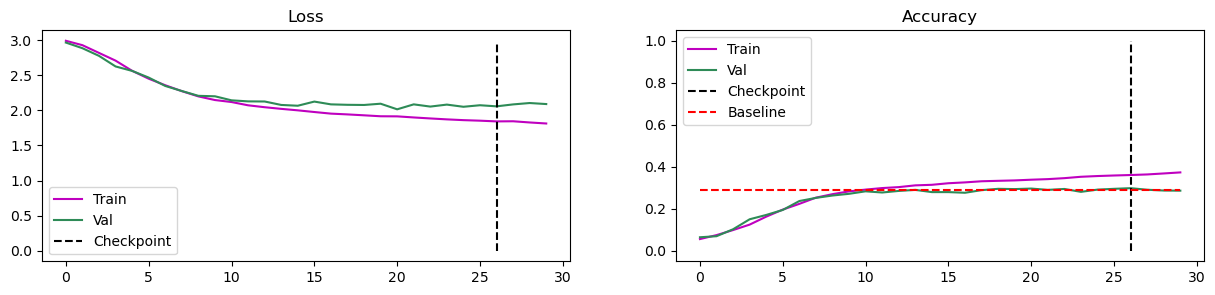

In [9]:
all_train_loss = []
all_train_acc = []

all_val_loss = []
all_val_acc = []
all_val_dist = []

max_true_acc = (1 + 1/2 + 1/3 + 1/3 + 1/20 + 1/2 + 1/3 + 1/3 + 1/20 + 1/20 + 1/3 + 1/3 + 1/20 + 1/20 + 1/20 + 1/3) / 16

N = 30

for epoch in range(N):
    all_train_loss.append(training_outputs['train'][str(epoch)]['loss'])
    all_train_acc.append(training_outputs['train'][str(epoch)]['accuracy'])

    all_val_loss.append(training_outputs['val'][str(epoch)]['loss'])
    all_val_acc.append(training_outputs['val'][str(epoch)]['accuracy'])
    if using_dist:
        all_val_dist.append(training_outputs['val'][str(epoch)]['dist'])

if using_dist:
    ff = 3
else:
    ff = 2

fig = plt.figure(figsize=(15, 3))

fig.add_subplot(1,ff,1)
plt.plot(np.arange(N), all_train_loss, label='Train', c='m')
plt.plot(np.arange(N), all_val_loss, label='Val', c='seagreen')
plt.plot([model_config['n_epochs']] * N, np.linspace(0,np.max(all_val_loss), N), ls='--', label='Checkpoint', c='k')
plt.title('Loss')
plt.legend()

fig.add_subplot(1,ff,2)
plt.plot(np.arange(N), all_train_acc, label='Train', c='m')
plt.plot(np.arange(N), all_val_acc, label='Val', c='seagreen')
plt.plot([model_config['n_epochs']] * N, np.linspace(0,1, N), ls='--', label='Checkpoint', c='k')
plt.plot(np.arange(N), [max_true_acc] * N, ls='--', label='Baseline', c='red')
plt.title('Accuracy')
plt.legend()

if using_dist:
    fig.add_subplot(1,ff,3)
    plt.plot(np.arange(N), all_val_dist, label='Val', c='seagreen')
    plt.plot([model_config['n_epochs']] * N, np.linspace(0,1, N), ls='--', label='Checkpoint', c='k')
    plt.title('Square error btw the true and the predicted policy')
    plt.legend();

fig.savefig(f"./neural_network_ToM/figures/Training_curves/{saving_name}_e_char_dim_{model_config['e_char_dim']}_{criterion}.png")

#### Utils data preprocessing

In [20]:
# Remove zero-padding and one-hot encoding 
def process_demo(demo: np.ndarray) -> np.ndarray:
    processed_demo = []
    for step in demo:
        if np.all(step == 0):
            break
        else:
            a = np.where(step[:, 0] == 1)[0][0] if not np.all(step[:, 0]==0) else 0
            r = int(step[0, 1])
            processed_demo.append([a, r])

    return np.array(processed_demo)

# Compute the true policy ONLY IF THE TRAJECTORY ON THE CURRENT ENV IS EMPTY (config['max_steps_current']==0)
def compute_true_policy(type: int, demo: np.ndarray) -> np.ndarray:
    processed_demo =  process_demo(demo)

    policy = np.zeros(n_buttons)
    given_musical_idx = processed_demo[np.where(processed_demo[:, 1] == 1)[0], 0]
    policy[given_musical_idx] = np.ones(len(given_musical_idx))
    policy /= policy.sum()

    if len(processed_demo) == 3:
        if type == 0:
            policy = np.ones(n_buttons) / n_buttons
            
    elif len(processed_demo) == 2:
        if type == 0 or type == 3:
            policy = np.ones(n_buttons) / n_buttons

    elif len(processed_demo) == 1:
        if type == 0 or type == 3 or type == 2:
            policy = np.ones(n_buttons) / n_buttons

    return policy

#### Evaluation with batch size of 1

In [ ]:
# Eval on training set
train_dict = prednet.evaluate(train_loader)
# Eval on validation set
val_dict = prednet.evaluate(val_loader)
# Eval on test set
test_dict = prednet.evaluate(test_loader)

100%|██████████| 1600/1600 [00:06<00:00, 237.01it/s]


In [ ]:
train_msg ='Eval on train | Loss | {:.4f} | Acc | {:.4f} |'.format(train_dict['loss'], train_dict['accuracy'])
print(train_msg)

val_msg ='Eval on val | Loss | {:.4f} | Acc | {:.4f} |'.format(val_dict['loss'], val_dict['accuracy'])
print(val_msg)

test_msg ='Eval on test | Loss | {:.4f} | Acc | {:.4f} |'.format(test_dict['loss'], test_dict['accuracy'])
print(test_msg)

Eval on train | Loss | 1.7761 | Acc | 0.3719 |
Eval on val | Loss | 1.9770 | Acc | 0.2800 |
Eval on test | Loss | 1.9929 | Acc | 0.2750 |


#### Vizualize inference

In [21]:
distance = SE_dist

In [22]:
idx = 1129

if using_dist:
    past_traj, current_traj, demo, target_action, true_idx_music, _ = test_dataset[idx]
else:
    past_traj, current_traj, demo, target_action, true_idx_music = test_dataset[idx]
type = idx // (n_agent_test * num_demo_types)

print(f'Learner of type {type}')

Learner of type 2


In [23]:
def display_traj(traj):
    l = []
    for step in traj:
        a = np.where(step[:, 0] == 1)[0][0] if not np.all(step[:, 0]==0) else 0
        print(f'({a},{int(step[0, 1])})', end='')

In [24]:
for nn in range(len(past_traj)):
    print(f'Past traj {nn}:', end='')
    display_traj(past_traj[nn])
    print()

Past traj 0:(11,1)(3,0)(10,1)(10,1)(10,1)(10,1)(10,1)(11,1)(10,1)(11,1)(10,1)(10,1)(10,1)(11,1)(10,1)(10,1)(11,1)(11,1)(10,1)(10,1)(10,1)(11,1)(10,1)(10,1)(10,1)(11,1)(10,1)(10,1)(10,1)(11,1)(10,1)(11,1)(10,1)(10,1)(11,1)(10,1)(11,1)(11,1)(10,1)(10,1)(11,1)(11,1)(11,1)(11,1)(10,1)(11,1)(10,1)(11,1)(11,1)(10,1)(10,1)(11,1)(11,1)(10,1)(11,1)(10,1)(10,1)(11,1)(11,1)(10,1)


In [15]:
print('Current traj: ', end='')
display_traj(current_traj)

Current traj: (0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)

In [16]:
print('Demo: ', end='')
display_traj(demo)

Demo: (8,1)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)(0,0)

In [17]:
past_traj_tensor = torch.from_numpy(past_traj[None,...])
current_traj_tensor = torch.from_numpy(current_traj[None,...])
demo_tensor = torch.from_numpy(demo[None,...])

pred_action, e_char, e_mental, e_demo = prednet(past_traj_tensor, current_traj_tensor, demo_tensor)

In [18]:
pred_policy = np.exp((pred_action).detach().numpy())
pred_policy /= pred_policy.sum()


       Type: 2 
       Demo: [[8, 1]]

       SE_dist distance: 0.9373

       Predicted reward: 0.9937


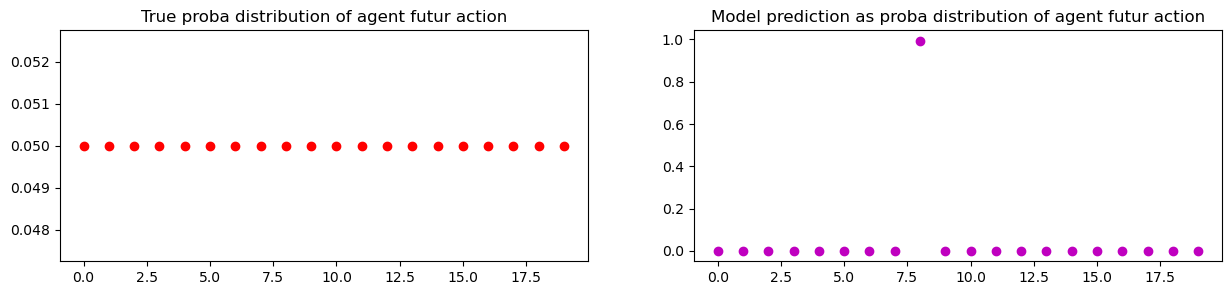

In [19]:
print(f'\n \
      Type: {type} \n \
      Demo: {process_demo(demo).tolist()}')
true_policy = compute_true_policy(type, demo)

fig = plt.figure(figsize=(15, 3))

fig.add_subplot(1, 2, 1)
plt.scatter(np.arange(20), true_policy, c='r')
plt.title('True proba distribution of agent futur action')

fig.add_subplot(1, 2, 2)
plt.scatter(np.arange(20), pred_policy, c='m')
plt.title('Model prediction as proba distribution of agent futur action')

print(f'\n \
      {distance.__name__} distance: {distance(pred_policy, true_policy):.4f}')

env_R = np.zeros(n_buttons)
env_R[np.array(true_idx_music, dtype=int)] = np.ones(n_music)
print(f'\n \
      Predicted reward: {(pred_policy * env_R).sum():.4f}');

In [20]:
print('Sorted buttons wrt predicted proba dist:', np.argsort(pred_policy)[0].tolist())

Sorted buttons wrt predicted proba dist: [13, 0, 1, 17, 3, 14, 18, 19, 15, 5, 11, 12, 16, 9, 2, 10, 6, 4, 7, 8]


In [21]:
print(f'\n \
      True action {int(target_action)} \n \
      Pred action {np.argmax((pred_action).detach().numpy())}')


       True action 18 
       Pred action 8


In [29]:
# Worse prediction (computed AFTER 'Further stat')
max_idx = np.argsort(dict_metric['error_dist'].ravel())[-10:]

print('Ravelled idx', max_idx)
unravel_max_idx = np.unravel_index(max_idx, (num_types, num_demo_types, n_agent_test))
print(f"Distance {np.round(dict_metric['error_dist'][unravel_max_idx], 4).tolist()})")

unravel_idx = np.array(unravel_max_idx)[:, 7]
idx = unravel_idx[0] * n_agent_test * num_demo_types + unravel_idx[2] * num_demo_types + unravel_idx[1]
print('idx:', idx)

Ravelled idx [914 959 968 913 932 998 934 993 982 904]
Distance [0.8348, 0.9044, 0.9048, 0.9073, 0.9153, 0.9208, 0.9308, 0.9321, 0.9373, 0.9414])
idx: 1173


#### Further stat

We display the predicted reward and resulting predicted utility as well as distance btw the true policy and the policy returned by the NN model.

In [25]:
distance = SE_dist
alpha = 0.01

dict_metric = {}
dict_metric['entropy'] = np.zeros((num_types, num_demo_types, n_agent_test))
dict_metric['loss'] = np.zeros((num_types, num_demo_types, n_agent_test))
dict_metric['accuracy'] = np.zeros((num_types, num_demo_types, n_agent_test))
dict_metric['metric_in'] = np.zeros((num_types, num_demo_types, n_agent_test))

dict_metric['e_char'] = np.zeros((num_types, num_demo_types, n_agent_test, model_config['e_char_dim']))
dict_metric['error_dist'] = np.zeros((num_types, num_demo_types, n_agent_test))
dict_metric['pred_reward'] = np.zeros((num_types, num_demo_types, n_agent_test))

n_agent = n_agent_test
dataset = test_dataset

for type in range(num_types):
    for n in range(n_agent):
        for demo_type in range(num_demo_types):
            idx = type * n_agent * num_demo_types + n * num_demo_types + demo_type

            if using_dist:
                past_traj, current_traj, demo, target_action, true_idx_music, _ = dataset[idx]
            else:
                past_traj, current_traj, demo, target_action, true_idx_music = dataset[idx]

            # Convert into tensors
            past_traj_tensor = torch.from_numpy(past_traj[None,...])
            current_traj_tensor = torch.from_numpy(current_traj[None,...])
            demo_tensor = torch.from_numpy(demo[None,...])
            target_action_tensor = torch.from_numpy(target_action[None,...]).long()

            # Sanity check
            if demo_type == 0:
                assert(np.any(np.array(demo_tensor[0,:,:,0] != 0), axis=1).sum() == n_buttons)
            else:
                assert(np.any(np.array(demo_tensor[0,:,:,0] != 0), axis=1).sum() == demo_type)

            # Model inference
            pred_action, e_char, e_mental, e_demo = prednet(past_traj_tensor, current_traj_tensor, demo_tensor)
            # Compute metrics
            pred_policy = np.exp(pred_action.detach().numpy()) / np.exp(pred_action.detach().numpy()).sum()
            dict_metric['accuracy'][type, demo_type, n] = np.argmax(pred_policy) == target_action
            dict_metric['loss'][type, demo_type, n] = torch.nn.NLLLoss()(pred_action, target_action_tensor)
            dict_metric['entropy'][type, demo_type, n] = Shannon_entropy(pred_policy)
            dict_metric['metric_in'][type, demo_type, n] = np.argmax(pred_policy) in true_idx_music
            env_R = np.zeros(n_buttons)
            env_R[np.array(true_idx_music, dtype=int)] = np.ones(n_music)
            dict_metric['pred_reward'][type, demo_type, n] = (pred_policy * env_R).sum()
            if model_config['basic_layer'] == 'ResConv':
                dict_metric['e_char'][type, demo_type, n, :] = e_char[:,:,0].detach().numpy()
            if model_config['basic_layer'] == 'Linear':
                dict_metric['e_char'][type, demo_type, n, :] = e_char.detach().numpy()

            if config['max_steps_current'] == 0:
                true_policy = compute_true_policy(type, demo)
                dist = distance(pred_policy, true_policy)
                dict_metric['error_dist'][type, demo_type, n] = dist

In [26]:
image_entropy = np.zeros((4, 4))
image_pourcentage_musical = np.zeros((4, 4))
image_error_dist = np.zeros((4, 4))
image_pred_reward = np.zeros((4, 4))
image_pred_utility = np.zeros((4, 4))

for type in range(num_types):
    print()
    for demo_type in range(num_demo_types):
        print(f"\033[1mLearner\033[0m {type} demo {demo_type} : " + \
              f"\033[1mLoss\033[0m | {np.mean(dict_metric['loss'][type, demo_type, :]):.4f} +/- {1.96 * np.std(dict_metric['loss'][type, demo_type, :]) / n_agent:.4f} | " +  \
              f"\033[1mAccuracy\033[0m | {np.mean(dict_metric['accuracy'][type, demo_type, :]):.4f} +/- {1.96 * np.std(dict_metric['accuracy'][type, demo_type, :]) / n_agent:.4f} | " + \
              f"\033[1mPrediction entropy\033[0m | {np.mean(dict_metric['entropy'][type, demo_type, :]):.4f} +/- {1.96 * np.std(dict_metric['entropy'][type, demo_type, :]) / n_agent:.4f} | " + \
              f" \033[1m% pred action in musical idx\033[0m | {np.mean(dict_metric['metric_in'][type, demo_type, :]):.4f} +/- {1.96 * np.std(dict_metric['metric_in'][type, demo_type, :]) / n_agent:.4f} |" + \
              f" \033[1mMean predicted reward idx\033[0m | {np.mean(dict_metric['pred_reward'][type, demo_type, :]):.4f} +/- {1.96 * np.std(dict_metric['pred_reward'][type, demo_type, :]) / n_agent:.4f} |" +\
              f" \033[1mMean {distance.__name__} btw true and predicted policies \033[0m | {np.mean(dict_metric['error_dist'][type, demo_type, :]):.4f} +/- {1.96 * np.std(dict_metric['error_dist'][type, demo_type, :]) / n_agent:.4f} |")
        
        image_entropy[type, demo_type] = np.mean(dict_metric['entropy'][type, demo_type, :])
        image_pourcentage_musical[type, demo_type] = np.mean(dict_metric['metric_in'][type, demo_type, :])
        image_error_dist[type, demo_type] = np.mean(dict_metric['error_dist'][type, demo_type, :])
        image_pred_reward[type, demo_type] = np.mean(dict_metric['pred_reward'][type, demo_type, :])
        len_demo = n_buttons if demo_type == 0 else demo_type
        image_pred_utility[type, demo_type] = np.mean(dict_metric['pred_reward'][type, demo_type, :]) - alpha * len_demo


Learner 0 demo 0 : Loss | 1.6614 +/- 0.0190 | Accuracy | 0.3100 +/- 0.0091 | Prediction entropy | 1.7433 +/- 0.0095 |  % pred action in musical idx | 1.0000 +/- 0.0000 | Mean predicted reward idx | 0.9070 +/- 0.0017 | Mean SE_dist btw true and predicted policies  | 0.1504 +/- 0.0025 |
Learner 0 demo 1 : Loss | 2.9970 +/- 0.0014 | Accuracy | 0.0700 +/- 0.0050 | Prediction entropy | 4.3182 +/- 0.0000 |  % pred action in musical idx | 0.1800 +/- 0.0075 | Mean predicted reward idx | 0.1506 +/- 0.0001 | Mean SE_dist btw true and predicted policies  | 0.0003 +/- 0.0000 |
Learner 0 demo 2 : Loss | 3.0354 +/- 0.0028 | Accuracy | 0.0500 +/- 0.0043 | Prediction entropy | 4.3003 +/- 0.0010 |  % pred action in musical idx | 0.4000 +/- 0.0096 | Mean predicted reward idx | 0.1651 +/- 0.0006 | Mean SE_dist btw true and predicted policies  | 0.0018 +/- 0.0001 |
Learner 0 demo 3 : Loss | 3.3708 +/- 0.0227 | Accuracy | 0.0400 +/- 0.0038 | Prediction entropy | 3.8566 +/- 0.0141 |  % pred action in music

In [27]:
print(f'Means dist over all combinaisons learner/demo: {np.mean(image_error_dist):.4f}')
print(f'Std dist over all combinaisons learner/demo: {np.std(image_error_dist):.4f}')

Means dist over all combinaisons learner/demo: 0.0924
Std dist over all combinaisons learner/demo: 0.0585


/home/chetouani/Documents/STAGE_Clemence/ISIR_internship_ToM/experimental_setup_meta/utils.py:35: RuntimeWarning: divide by zero encountered in log2
  tab = proba_dist * np.log2(proba_dist)
/home/chetouani/Documents/STAGE_Clemence/ISIR_internship_ToM/experimental_setup_meta/utils.py:35: RuntimeWarning: invalid value encountered in multiply
  tab = proba_dist * np.log2(proba_dist)


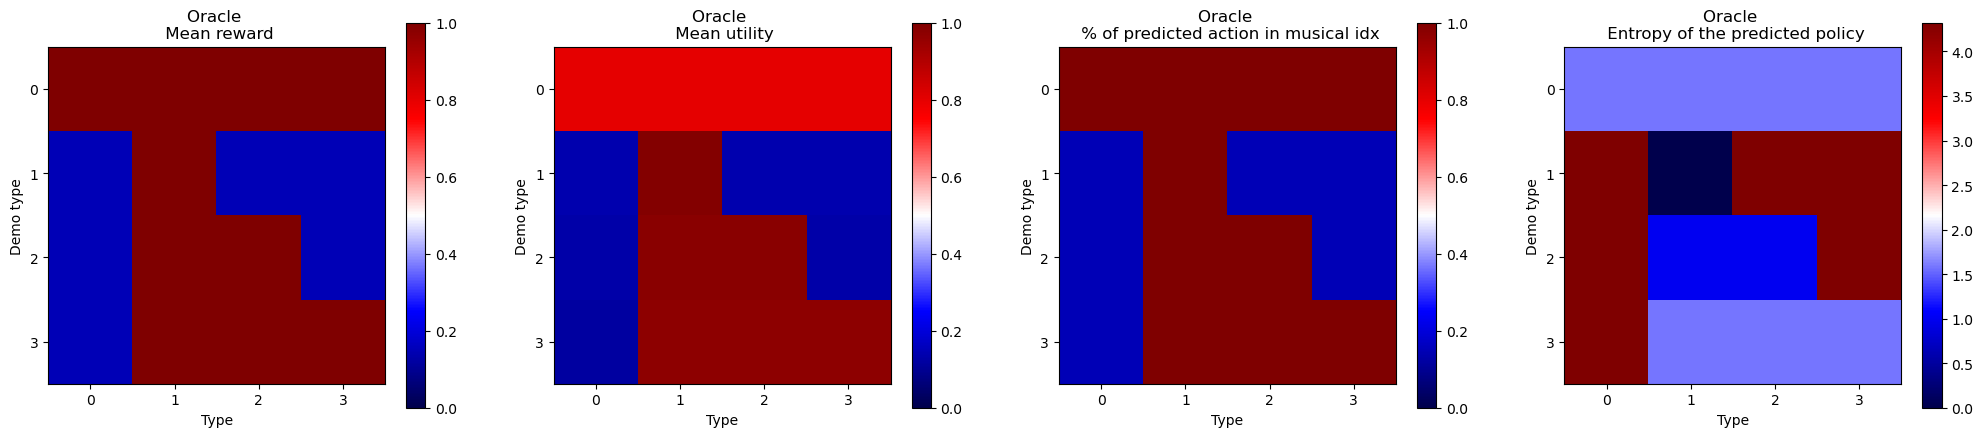

In [26]:
# Oracle teacher

perf_image_entropy = np.zeros((4, 4))
perf_image_pourcentage_musical = np.zeros((4, 4))
perf_image_utility = np.zeros((4, 4))

for type in range(num_types):
    for demo_type in range(num_demo_types):
        
        len_demo = n_buttons if demo_type == 0 else demo_type

        if demo_type == 0:
            dist = np.zeros(n_buttons)
            dist[np.array([0, 1, 2])] = np.ones(3)
            dist /= dist.sum()
            perf_image_entropy[type, demo_type] = Shannon_entropy(dist)
            perf_image_pourcentage_musical[type, demo_type] = 1
        elif demo_type == 3:
            if type == 0:
                # Uniform policy
                perf_image_entropy[type, demo_type] = Shannon_entropy(np.ones(n_buttons) / n_buttons)
                perf_image_pourcentage_musical[type, demo_type] = 3/20
            else:
                # Peaked on 3 (musical) buttons policy
                dist = np.zeros(n_buttons)
                dist[np.array([0, 1, 2])] = np.ones(3)
                dist /= dist.sum()
                perf_image_entropy[type, demo_type] = Shannon_entropy(dist)
                perf_image_pourcentage_musical[type, demo_type] = 1
        elif demo_type == 2:
            if type == 0 or type == 3:
                # Uniform policy
                perf_image_entropy[type, demo_type] = Shannon_entropy(np.ones(n_buttons) / n_buttons)
                perf_image_pourcentage_musical[type, demo_type] = 3/20
            else:
                # Peaked on 2 (musical) buttons policy
                dist = np.zeros(n_buttons)
                dist[np.array([0, 1])] = np.ones(2)
                dist /= dist.sum()
                perf_image_entropy[type, demo_type] = Shannon_entropy(dist)
                perf_image_pourcentage_musical[type, demo_type] = 1
        elif demo_type == 1:
            if type == 0 or type == 3 or type == 2:
                # Uniform policy
                perf_image_entropy[type, demo_type] = Shannon_entropy(np.ones(n_buttons) / n_buttons)
                perf_image_pourcentage_musical[type, demo_type] = 3/20
            else:
                # Peaked on 1 (musical) buttons policy
                dist = np.zeros(n_buttons)
                dist[0] = np.ones(1)
                dist /= dist.sum()
                perf_image_entropy[type, demo_type] = Shannon_entropy(dist)
                perf_image_pourcentage_musical[type, demo_type] = 1

        perf_image_utility[type, demo_type] = perf_image_pourcentage_musical[type, demo_type] - alpha * len_demo


fig = plt.figure(figsize=(25,5))

fig.add_subplot(1,4,1)
plt.imshow(perf_image_pourcentage_musical.T, cmap='seismic', vmin=0, vmax=1)
plt.colorbar()
plt.xticks([3,2,1,0])
plt.yticks([3,2,1,0])
plt.xlabel('Type')
plt.ylabel('Demo type')
plt.title('Oracle \n Mean reward')

fig.add_subplot(1,4,2)
plt.imshow(perf_image_utility.T, cmap='seismic', vmin=0, vmax=1)
plt.colorbar()
plt.xticks([3,2,1,0])
plt.yticks([3,2,1,0])
plt.xlabel('Type')
plt.ylabel('Demo type')
plt.title('Oracle \n Mean utility')

fig.add_subplot(1,4,3)
plt.imshow(perf_image_pourcentage_musical.T, cmap='seismic', vmin=0, vmax=1)
plt.colorbar()
plt.xticks([3,2,1,0])
plt.yticks([3,2,1,0])
plt.xlabel('Type')
plt.ylabel('Demo type')
plt.title('Oracle \n % of predicted action in musical idx')

fig.add_subplot(1,4,4)
plt.imshow(perf_image_entropy.T, cmap='seismic', vmin=0, vmax=(Shannon_entropy(np.ones(n_buttons) / n_buttons)))
plt.colorbar()
plt.xticks([3,2,1,0])
plt.yticks([3,2,1,0])
plt.xlabel('Type')
plt.ylabel('Demo type')
plt.title('Oracle \n Entropy of the predicted policy');

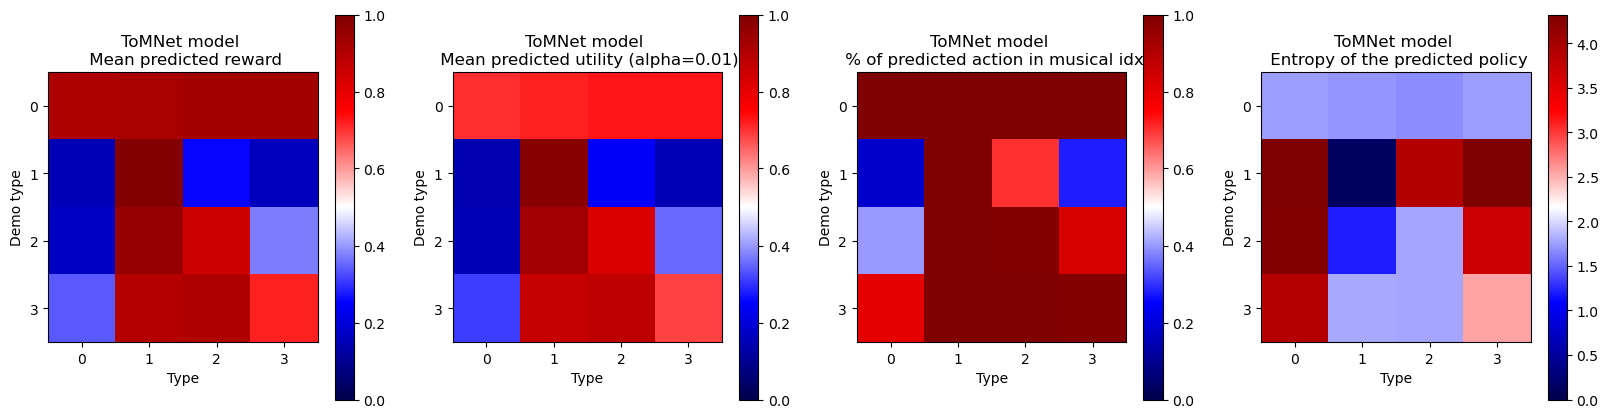

In [27]:
fig = plt.figure(figsize=(20,5))

fig.add_subplot(1,4,1)
plt.imshow(image_pred_reward.T, cmap='seismic', vmin=0, vmax=1)
plt.colorbar()
plt.xticks([3,2,1,0])
plt.yticks([3,2,1,0])
plt.xlabel('Type')
plt.ylabel('Demo type')
plt.title('ToMNet model \n Mean predicted reward')

fig.add_subplot(1,4,2)
plt.imshow(image_pred_utility.T, cmap='seismic', vmin=0, vmax=1)
plt.colorbar()
plt.xticks([3,2,1,0])
plt.yticks([3,2,1,0])
plt.xlabel('Type')
plt.ylabel('Demo type')
plt.title(f'ToMNet model \n Mean predicted utility (alpha={alpha})')

fig.add_subplot(1,4,3)
plt.imshow(image_pourcentage_musical.T, cmap='seismic', vmin=0, vmax=1)
plt.colorbar()
plt.xticks([3,2,1,0])
plt.yticks([3,2,1,0])
plt.xlabel('Type')
plt.ylabel('Demo type')
plt.title('ToMNet model \n % of predicted action in musical idx')

fig.add_subplot(1,4,4)
plt.imshow(image_entropy.T, cmap='seismic', vmin=0, vmax=(Shannon_entropy(np.ones(n_buttons) / n_buttons)))
plt.colorbar()
plt.xticks([3,2,1,0])
plt.yticks([3,2,1,0])
plt.xlabel('Type')
plt.ylabel('Demo type')
plt.title('ToMNet model \n Entropy of the predicted policy');

fig.savefig(f"./neural_network_ToM/figures/Statistics/{saving_name}_e_char_dim_{model_config['e_char_dim']}_{criterion}.png")

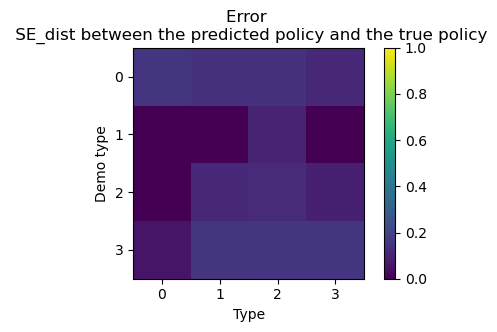

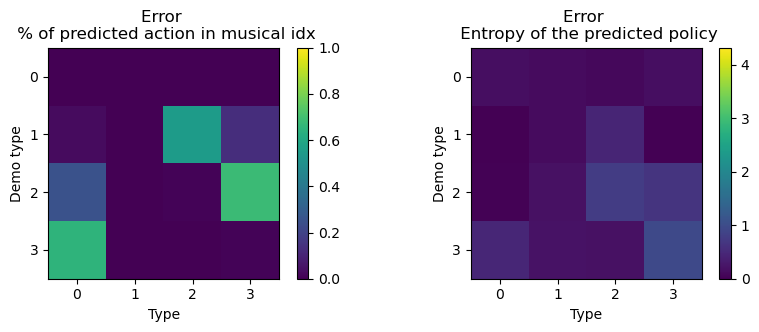

In [28]:
fig = plt.figure(figsize=(5,3))

if config['max_steps_current'] == 0:
    plt.imshow(image_error_dist.T, cmap='viridis', vmin=0, vmax=1)
    plt.colorbar()
    plt.xticks([3,2,1,0])
    plt.yticks([3,2,1,0])
    plt.xlabel('Type')
    plt.ylabel('Demo type')
    plt.title(f'Error \n {distance.__name__} between the predicted policy and the true policy')

fig.savefig(f"./neural_network_ToM/figures/Statistics/Error/{saving_name}_e_char_dim_{model_config['e_char_dim']}_{criterion}_error_L2.png")

fig = plt.figure(figsize=(10,3))

fig.add_subplot(1,2,1)
plt.imshow(np.abs(perf_image_pourcentage_musical - image_pourcentage_musical).T, cmap='viridis', vmin=0, vmax=1)
plt.colorbar()
plt.xticks([3,2,1,0])
plt.yticks([3,2,1,0])
plt.xlabel('Type')
plt.ylabel('Demo type')
plt.title('Error \n % of predicted action in musical idx')


fig.add_subplot(1,2,2)
plt.imshow(np.abs(perf_image_entropy - image_entropy).T, cmap='viridis', vmin=0, vmax=(Shannon_entropy(np.ones(n_buttons) / n_buttons)))
plt.colorbar()
plt.xticks([3,2,1,0])
plt.yticks([3,2,1,0])
plt.xlabel('Type')
plt.ylabel('Demo type')
plt.title('Error \n Entropy of the predicted policy');

fig.savefig(f"./neural_network_ToM/figures/Statistics/Error/{saving_name}_e_char_dim_{model_config['e_char_dim']}_{criterion}_error.png")

#### PCA

In [29]:
type_embedding = dict_metric['e_char'].reshape(num_types * num_demo_types * n_agent, model_config['e_char_dim'])

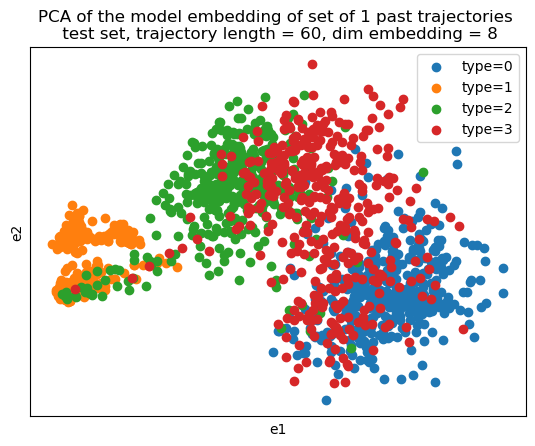

In [31]:
# Normalize
scaler = StandardScaler()
scaled_type_embedding = type_embedding #scaler.fit_transform(type_embedding)

fig = plt.figure()

# PCA
if model_config['e_char_dim'] > 2:
    transformed_type_embedding = PCA(n_components=2).fit_transform(scaled_type_embedding)
    transformed_type_embedding = transformed_type_embedding.reshape(num_types, num_demo_types, n_agent, 2)
else:
    transformed_type_embedding = scaled_type_embedding.reshape(num_types, num_demo_types, n_agent, 2)

for type in range(num_types):
    plt.scatter(transformed_type_embedding[type,...,0], transformed_type_embedding[type,...,1], label=f'type={type}')
plt.title(f"PCA of the model embedding of set of {num_past} past trajectories \n test set, trajectory length = {max_steps}, dim embedding = {model_config['e_char_dim']}")
plt.yticks([])
plt.xticks([])
plt.xlabel('e1')
plt.ylabel('e2')
plt.legend();

fig.savefig(f"./neural_network_ToM/figures/PCA/{saving_name}_e_char_dim_{model_config['e_char_dim']}_{criterion}.png")

#### T-SNE

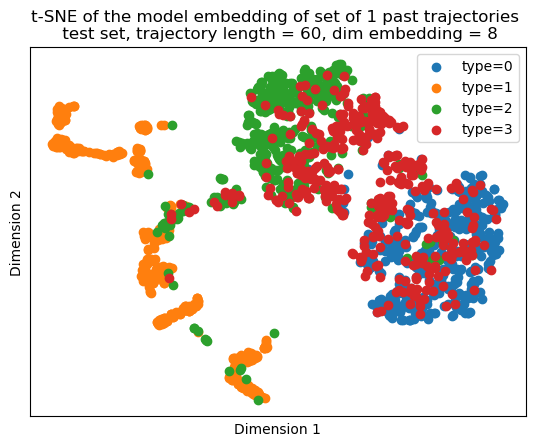

In [32]:
# Normalize
scaler = StandardScaler()
scaled_type_embedding = scaler.fit_transform(type_embedding)

fig = plt.figure()

# t-SNE
if model_config['e_char_dim'] > 2:
    transformed_type_embedding = TSNE(n_components=2).fit_transform(scaled_type_embedding)
    transformed_type_embedding = transformed_type_embedding.reshape(num_types, num_demo_types, n_agent, 2)
else:
    transformed_type_embedding = scaled_type_embedding.reshape(num_types, num_demo_types, n_agent, 2)

for type in range(num_types):
    plt.scatter(transformed_type_embedding[type,...,0], transformed_type_embedding[type,...,1], label=f'type={type}')
plt.title(f"t-SNE of the model embedding of set of {num_past} past trajectories \n test set, trajectory length = {max_steps}, dim embedding = {model_config['e_char_dim']}")
plt.yticks([])
plt.xticks([])
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend();

fig.savefig(f"./neural_network_ToM/figures/TSNE/{saving_name}_e_char_dim_{model_config['e_char_dim']}_{criterion}.png")

#### UMAP

/home/chetouani/miniforge-pypy3/envs/ISIR/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/chetouani/miniforge-pypy3/envs/ISIR/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/chetouani/miniforge-pypy3/envs/ISIR/lib/python3.11

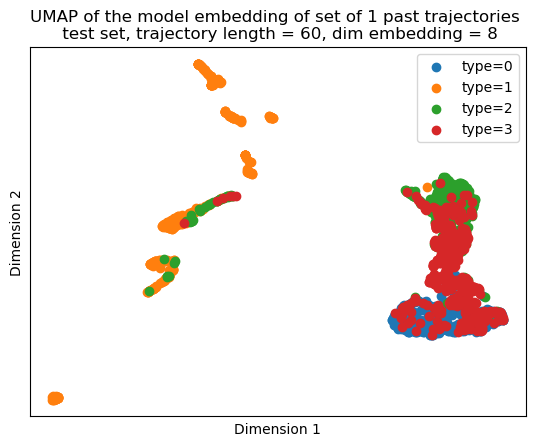

In [33]:
import umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Normalize
scaler = StandardScaler()
scaled_type_embedding = type_embedding #scaler.fit_transform(type_embedding)

fig = plt.figure()

# UMAP
if model_config['e_char_dim'] > 2:
    transformed_type_embedding = umap.UMAP(n_components=2).fit_transform(scaled_type_embedding)
    transformed_type_embedding = transformed_type_embedding.reshape(num_types, num_demo_types, n_agent, 2)
else:
    transformed_type_embedding = scaled_type_embedding.reshape(num_types, num_demo_types, n_agent, 2)

for type in range(num_types):
    plt.scatter(transformed_type_embedding[type, ..., 0], transformed_type_embedding[type, ..., 1], label=f'type={type}')
plt.title(f"UMAP of the model embedding of set of {num_past} past trajectories \n test set, trajectory length = {max_steps}, dim embedding = {model_config['e_char_dim']}")
plt.yticks([])
plt.xticks([])
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend();

# fig.savefig(f"./neural_network_ToM/figures/UMAP/{saving_name}_e_char_dim_{model_config['e_char_dim']}_{criterion}.png")

#### Try unsupervised clustering

/home/chetouani/miniforge-pypy3/envs/ISIR/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


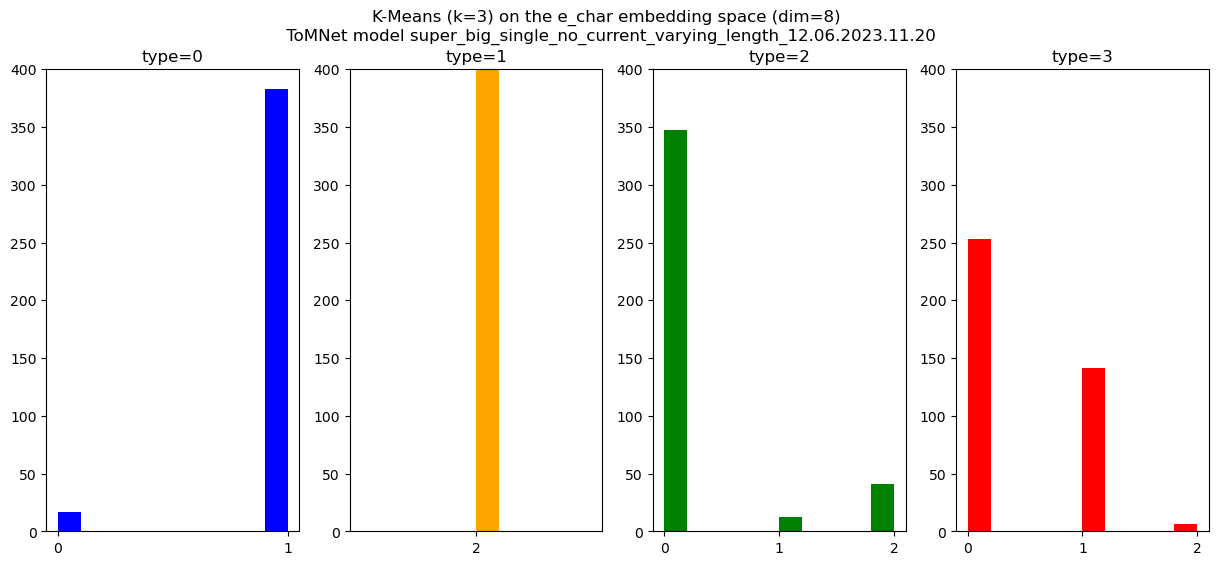

In [34]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Normalize
scaler = StandardScaler()
scaled_type_embedding = scaler.fit_transform(type_embedding)

k = 3
clustering_algorithm = KMeans(n_clusters=k)
clustering_algorithm.fit(scaled_type_embedding)
cluster_labels = clustering_algorithm.labels_

cluster_labels = cluster_labels.reshape(num_types, -1)

colors = ['b', 'orange', 'g', 'r']
fig = plt.figure(figsize=(15, 6))
for type in range(num_types):
    fig.add_subplot(1,4,type+1)
    plt.ylim(0,400)
    plt.xticks(np.arange(k))
    plt.hist(cluster_labels[type, :], color=colors[type])
    plt.title(f'type={type}')

fig.suptitle(f"K-Means (k={k}) on the e_char embedding space (dim={model_config['e_char_dim']}) \n ToMNet model {saving_name}");

### TomNet based teacher

We display evaluation metrics (same as Bayesian teacher)

In [5]:
from neural_network_ToM.nn_teacher import ToMNetTeacher

In [ ]:
criterion = 'acc'

# Load PreNet model
loading_path = './neural_network_ToM/model_weights/super_big_single_no_current_varying_length_12.06.2023.11.20'
saving_name = loading_path[35:]
print(f'Saving statistics and figures at {saving_name}')

model_loading_path = os.path.join(loading_path, f'prednet_model_best_{criterion}.pt')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'Working on device: {device}')

model_config = load_config(os.path.join(loading_path, f'config_best_{criterion}.json'))
training_outputs = load_config(os.path.join(loading_path, 'outputs.json'))

# # Evaluation dataset with single past trajectory and empty current trajectory
# data_loading_path = os.path.join('neural_network_ToM', './data/eval_single')
# data_loading_path = os.path.join('neural_network_ToM', './data/eval_single_no_current')

data_loading_path = os.path.join('neural_network_ToM', model_config['data_path'])
config = load_config(os.path.join(data_loading_path, 'config_dataset.json'))

# Dataset parameters
n_buttons, n_music = config['n_buttons'], config['n_music']
num_past, max_steps, min_steps, max_steps_current = config['num_past'], config['max_steps'], config['min_steps'], config['max_steps_current']
n_agent_train, n_agent_val, n_agent_test = config['n_agent_train'], config['n_agent_val'], config['n_agent_test']

using_dist = config['true_types'] if 'true_types' in config.keys() else False
print(f'Dataset with true learner types: {using_dist}')

varying_length = config['varying_length'] if 'varying_length' in config.keys() else False
print(f'Observed past trajectories with varying length: {varying_length}') 

use_e_mental = not (max_steps_current == 0)
print(f'Using MentalNet block: {use_e_mental}')

print(f"\n \
      max_step: {max_steps} \n \
      num_past: {num_past} \n \
      max_steps_current: {max_steps_current} \n \
      \n \
      batch_size: {model_config['batch_size']} \n \
      e_char_dim: {model_config['e_char_dim']} \n \
      basic layer: {model_config['basic_layer']} \n")

prednet = PredNet(num_input=2,
                  num_step=max_steps, 
                  n_buttons=n_buttons,
                  num_output_char=model_config['e_char_dim'],
                  basic_layer= model_config['basic_layer'],
                  device=device,
                  use_e_mental=use_e_mental)

prednet.load_state_dict(torch.load(model_loading_path))

print(f'Model with mask: {prednet.with_mask}')

model_epochs = str(model_config['n_epochs'])
print(f"Best model in validation achieved in epoch {model_epochs}")
print(f"Train | Loss | {training_outputs['train'][model_epochs]['loss']:.4f} | Acc | {training_outputs['train'][model_epochs]['accuracy']:.4f} | " + \
      f"Val | Loss | {training_outputs['val'][model_epochs]['loss']:.4f} | Acc | {training_outputs['val'][model_epochs]['accuracy']:.4f} | ")

In [8]:
# Global evaluation parameters
# DICT = load_output(f'./outputs/bayesian_ToM/teacher_eval.json')
# LOADED = False
DICT = load_output(f'./outputs/nn_ToM/teacher_eval_{saving_name}.json')
LOADED = True

N = 100
N_envs = 3
num_obs = 50

n_eval = 20

##### Generate results

In [ ]:
def evaluate(method: str, alpha: float) -> None:
    if method not in DICT.keys():
        DICT[method] = {}
    DICT[method][alpha] = {}
    for type in range(num_types):
        DICT[method][alpha][type] = {}
        DICT[method][alpha][type]['rewards'] = []
        DICT[method][alpha][type]['demo'] = []
        DICT[method][alpha][type]['uncertainty'] = []
        DICT[method][alpha][type]['teacher_regret'] = []
        for _ in range(N_envs):
            # Init envs
            observation_env = ButtonsToy(n_buttons, n_music)
            demonstration_env = ButtonsToy(n_buttons, n_music)
            for _ in trange(N):
                cum_rewards = []
                all_demo = []
                uncertainties = []
                teacher_regret = []
                for n in range(num_obs):
                    # Init teacher
                    if method == 'MAP' or method == 'Bayesian' or method == 'Oracle':
                        teacher = BaysesianTeacher(env=observation_env,
                                                    num_types=num_types)
                    elif method == 'Uniform' or method == 'Opt_non_adaptive':
                        teacher = NaiveTeacher(env=observation_env,
                                                    num_types=num_types)
                    elif method == 'ToMNet':
                        teacher = ToMNetTeacher(env=observation_env,
                                                num_types=num_types,
                                                max_steps=config['max_steps'],
                                                loading_path=loading_path,
                                                criterion=criterion,
                                                device=device,
                                                use_e_mental=use_e_mental)
                    # Init learner
                    learner = Learner(type)
                    learner.init_env(observation_env)
                    if method in ['MAP', 'Bayesian', 'ToMNet']:
                        # Observe the learner
                        traj = learner.act(size=n)
                        teacher.observe(traj)
                        if method in ['MAP', 'Bayesian']:
                            # Teacher uncertainty
                            uncertainties.append(Shannon_entropy(teacher.beliefs))
                    # Chose demonstration
                    teacher.init_env(demonstration_env)
                    if method != 'Oracle':
                        demo = teacher.demonstrate(method=method, alpha=alpha)
                    else:
                        demo = teacher.demonstrate(method=method, alpha=alpha, true_learner_type=type)
                    # Teacher regret on its demonstration choice
                    teacher_regret.append(cost(demo, alpha=alpha) - cost(teacher.demonstrations[type], alpha=alpha))
                    # Show the demonstration
                    learner.init_env(demonstration_env)
                    learner.observe(demo)
                    # Evaluate hwo helpful has been the demonstration
                    _, rewards = learner.act(size=n_eval)
                    # Append
                    cum_rewards.append(np.sum(rewards))
                    all_demo.append(len(demo[0]))
                DICT[method][alpha][type]['rewards'].append(cum_rewards)
                DICT[method][alpha][type]['demo'].append(all_demo)
                DICT[method][alpha][type]['uncertainty'].append(uncertainties)
                DICT[method][alpha][type]['teacher_regret'].append(teacher_regret)

In [ ]:
evaluate('ToMNet', alpha=0.01)

  0%|          | 0/100 [00:00<?, ?it/s]/home/chetouani/Documents/STAGE_Clemence/ISIR_internship_ToM/experimental_setup_meta/utils.py:35: RuntimeWarning: divide by zero encountered in log2
  tab = proba_dist * np.log2(proba_dist)
/home/chetouani/Documents/STAGE_Clemence/ISIR_internship_ToM/experimental_setup_meta/utils.py:35: RuntimeWarning: invalid value encountered in multiply
  tab = proba_dist * np.log2(proba_dist)
100%|██████████| 100/100 [07:44<00:00,  4.65s/it]


In [ ]:
evaluate('ToMNet', alpha=0.02)

100%|██████████| 100/100 [07:43<00:00,  4.64s/it]


##### Display results of the ToMNet teacher

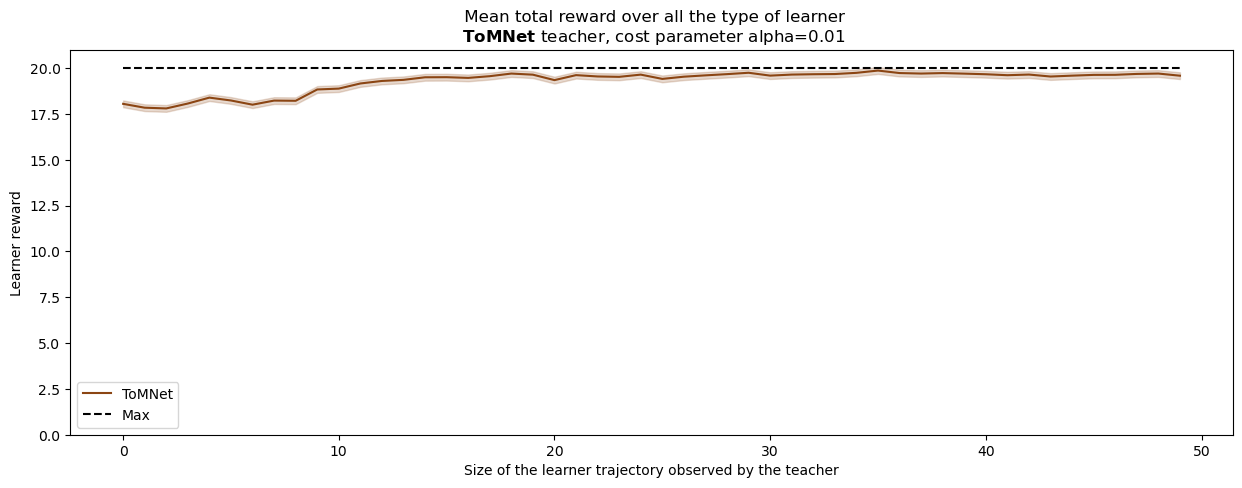

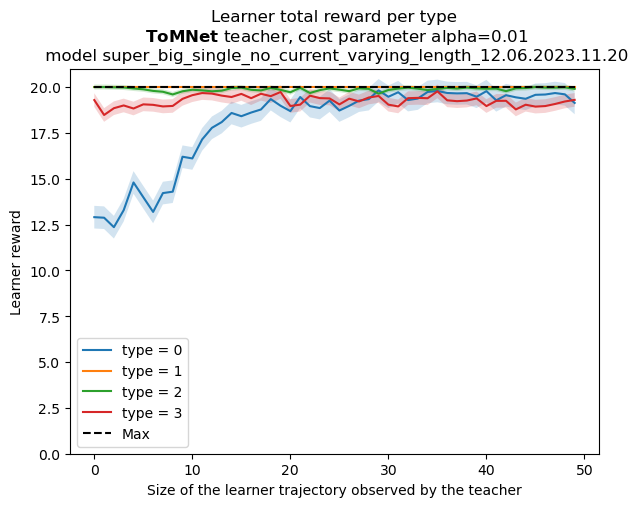

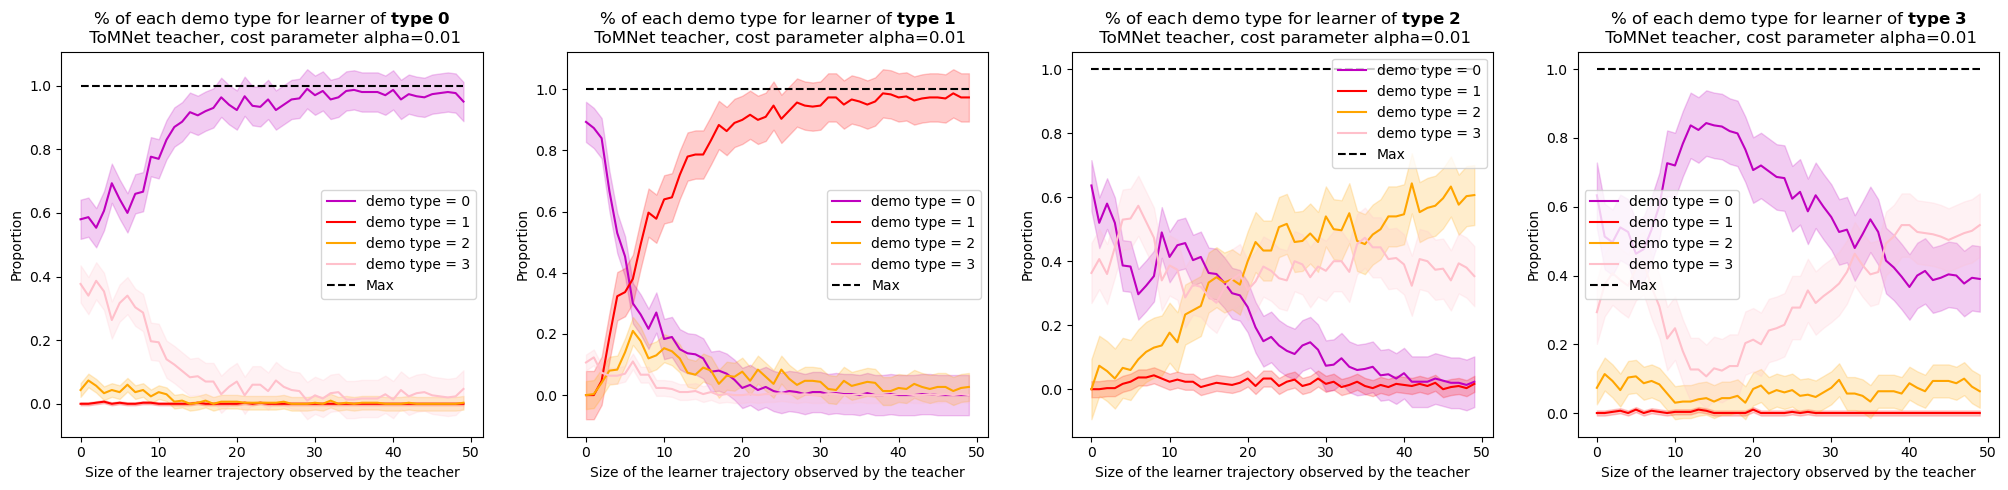

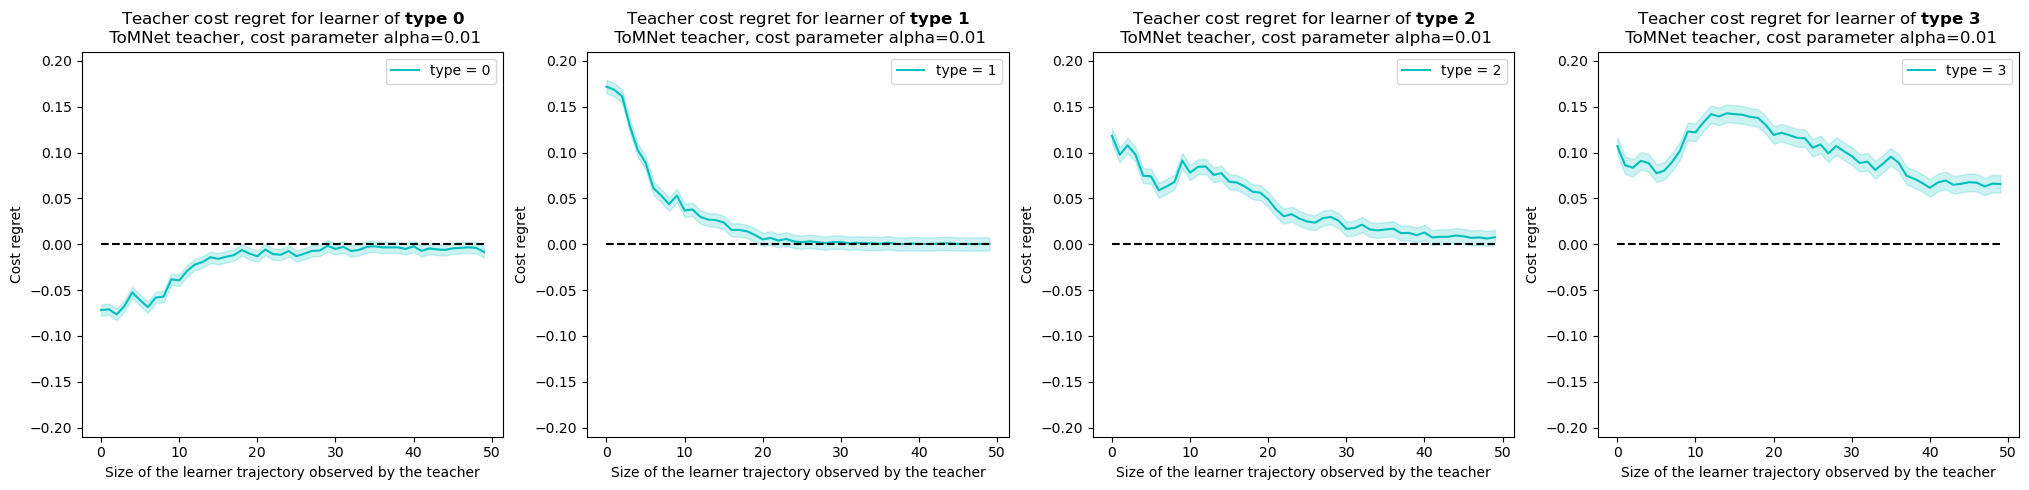

In [9]:
display_evaluation('ToMNet', alpha=0.01, num_obs=num_obs, N=N, N_envs=N_envs, DICT=DICT, LOADED=LOADED, save=True, saving_name=saving_name) 

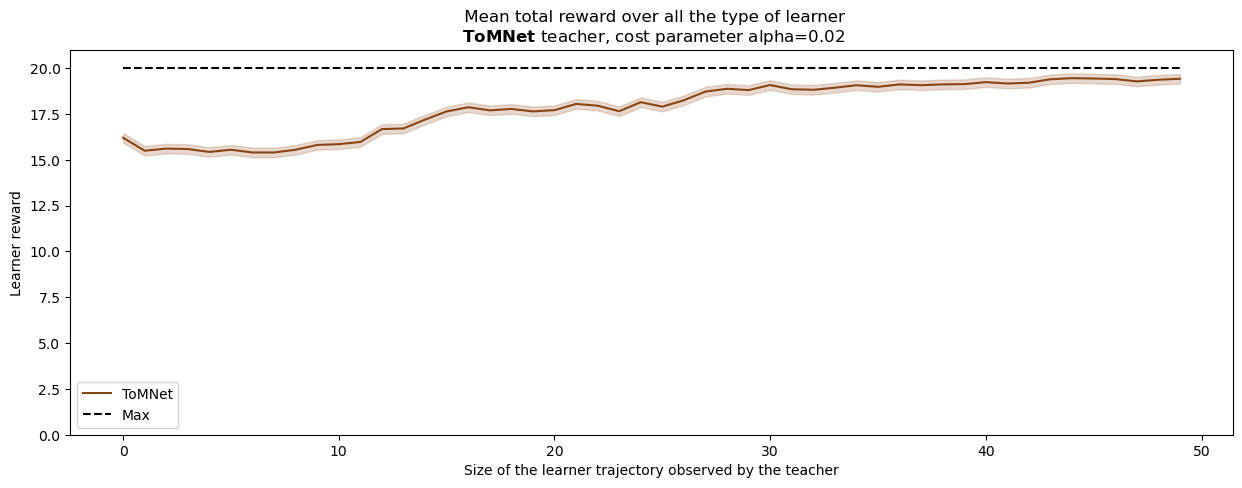

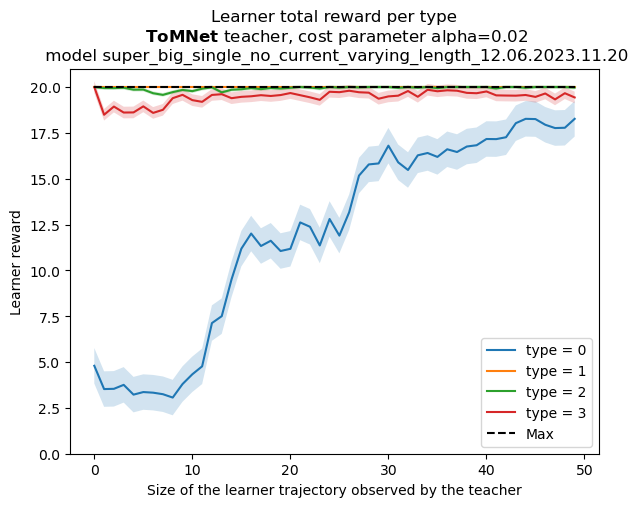

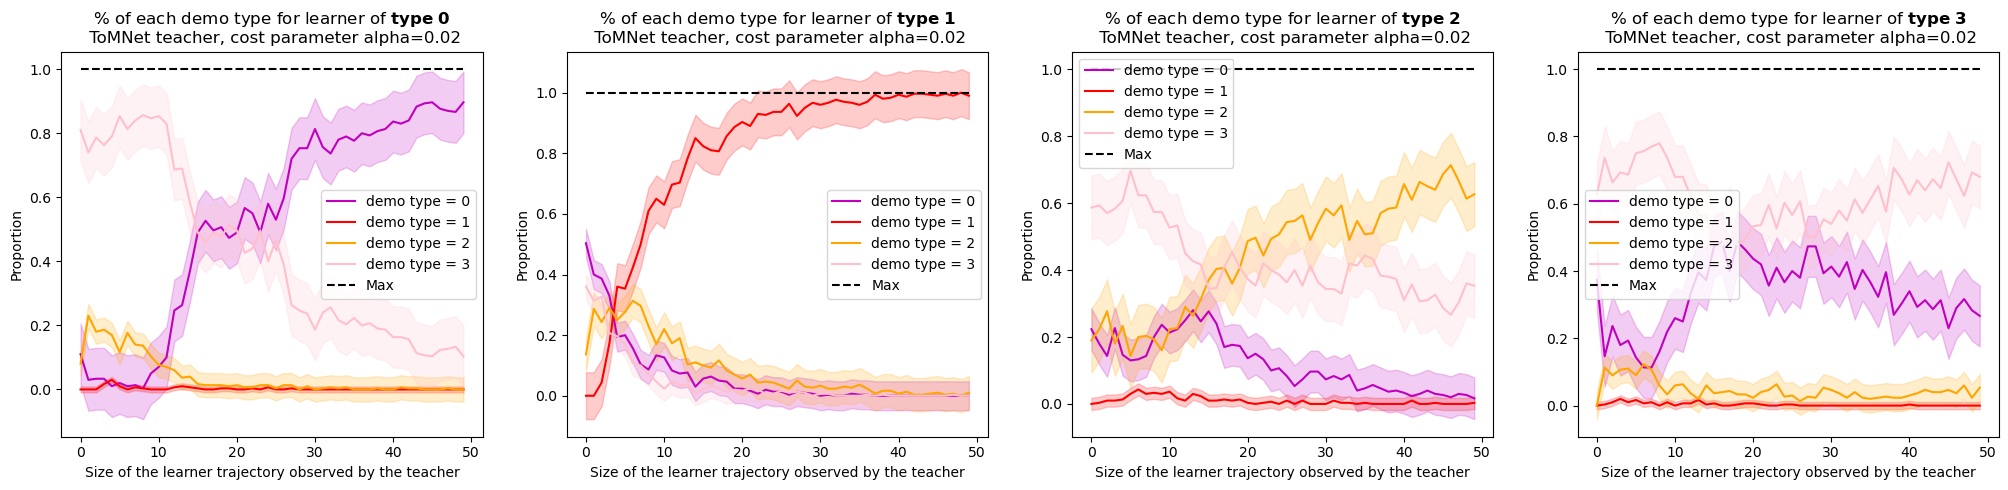

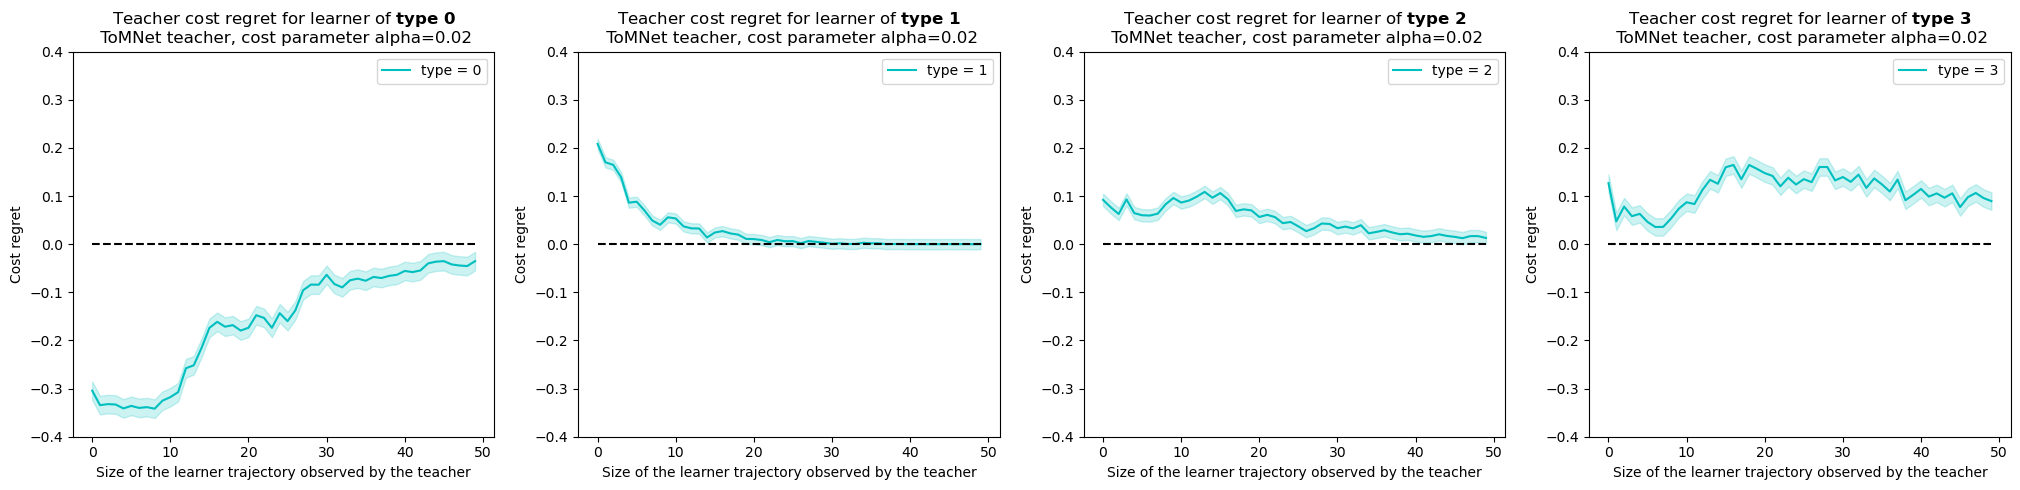

In [10]:
display_evaluation('ToMNet', alpha=0.02, num_obs=num_obs, N=N, N_envs=N_envs, DICT=DICT, LOADED=LOADED, save=True, saving_name=saving_name) 

##### Comparison of the utility of all the teachers (Bayesians and NN)

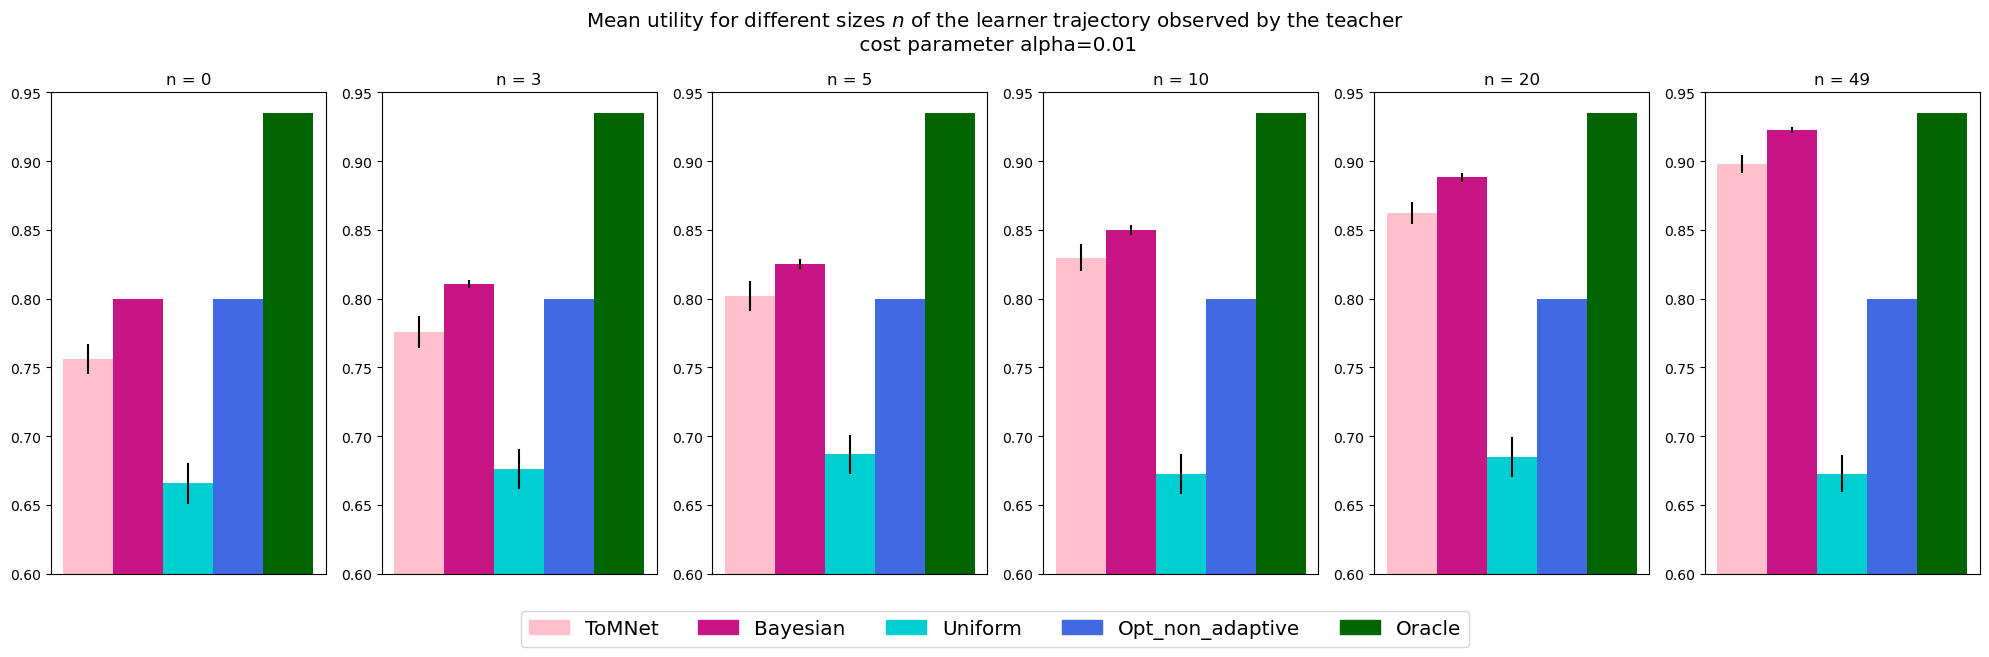

In [12]:
display_utility_hist(alpha=0.01, num_obs=num_obs, N=N, N_envs=N_envs, DICT=DICT, LOADED=LOADED, saving_name=saving_name) 

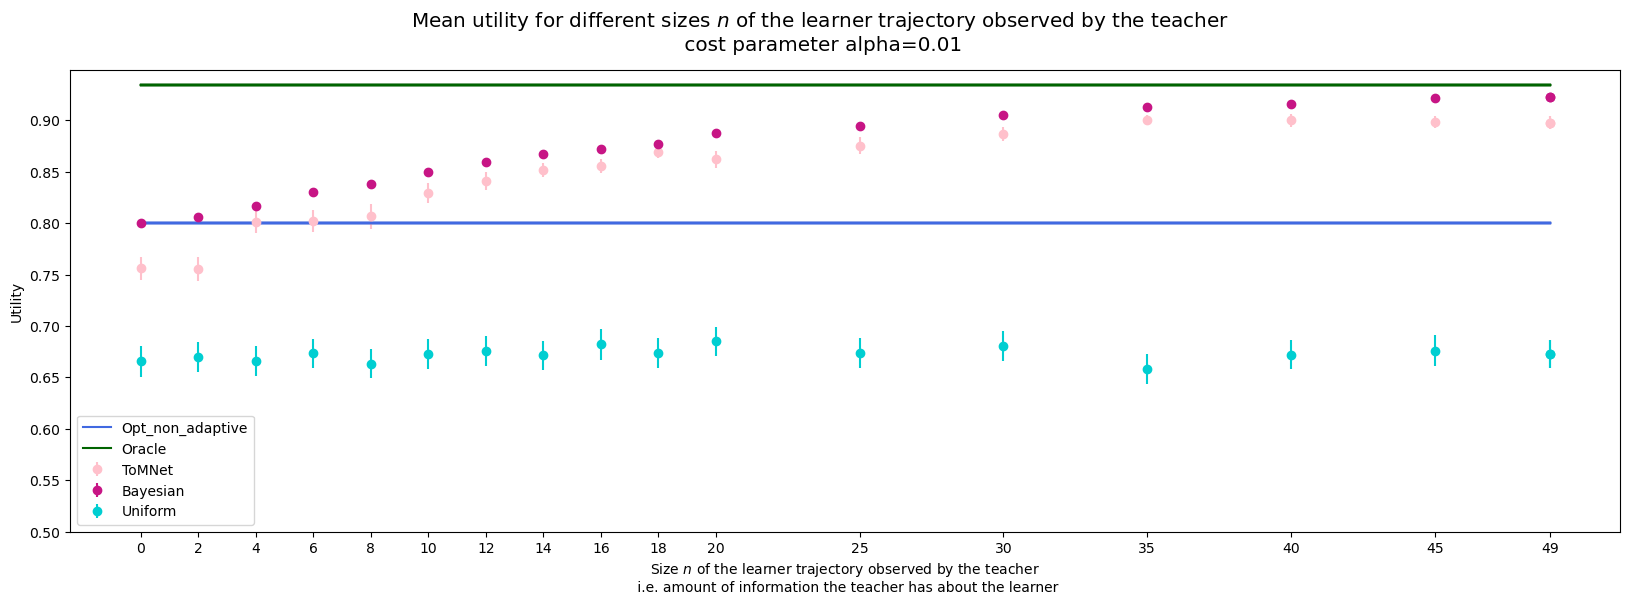

In [14]:
display_utility_errorbar(alpha=0.01, num_obs=num_obs, N=N, N_envs=N_envs, DICT=DICT, LOADED=LOADED, saving_name=saving_name)

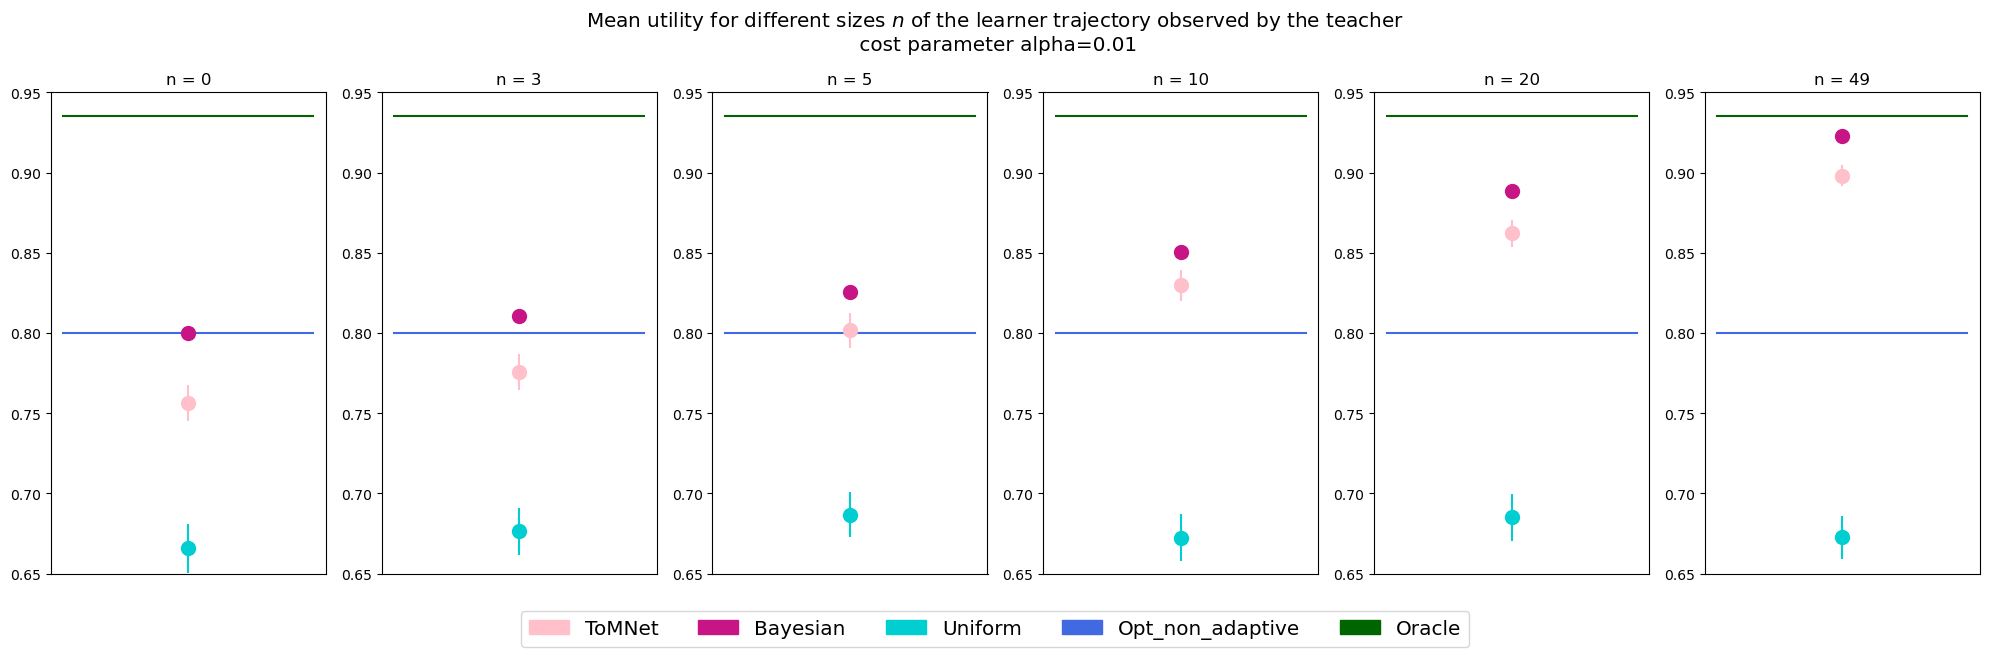

In [16]:
display_utility_errorbar_split(alpha=0.01, num_obs=num_obs, N=N, N_envs=N_envs, DICT=DICT, LOADED=LOADED, saving_name=saving_name)

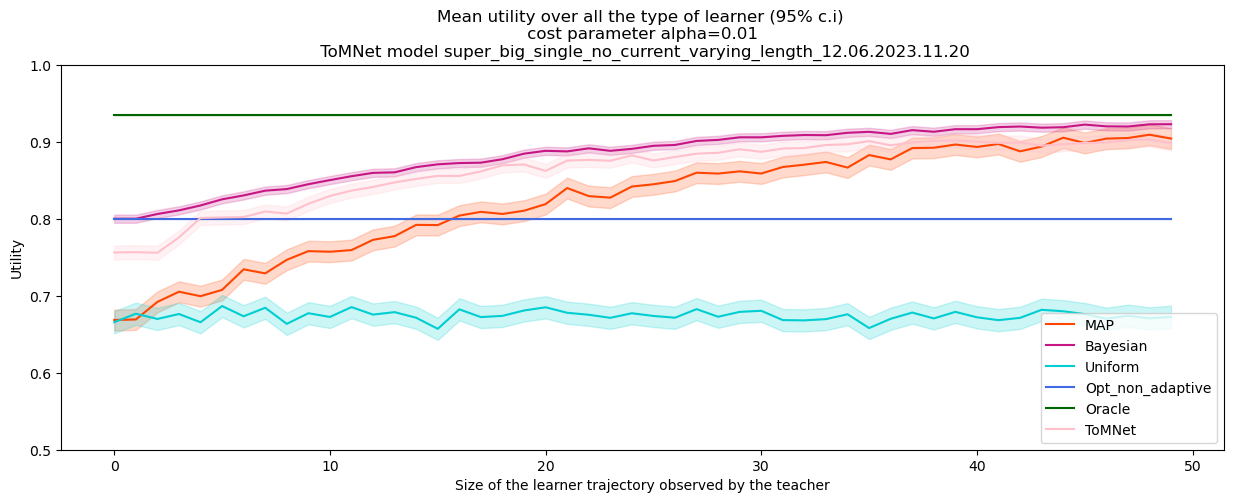

In [17]:
display_utility(alpha=0.01, num_obs=num_obs, N=N, N_envs=N_envs, DICT=DICT, LOADED=LOADED, saving_name=saving_name)

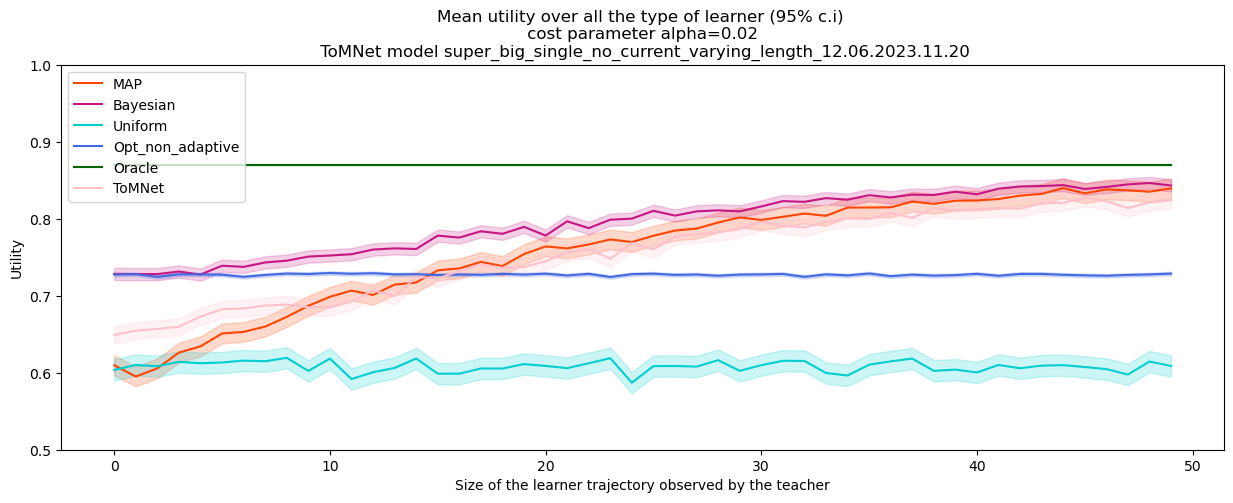

In [18]:
display_utility(alpha=0.02, num_obs=num_obs, N=N, N_envs=N_envs, DICT=DICT, LOADED=LOADED, saving_name=saving_name)

### Saving

In [ ]:
save_output(DICT, './outputs/nn_ToM', f'teacher_eval_{saving_name}')